In [1]:
import pandas as pd
# import scprep as sc
import scanpy as sc
import phate
import numpy as np
import seaborn as sns
import scprep
from sklearn.metrics import roc_auc_score, average_precision_score
import os
from tqdm import tqdm
import warnings


In [2]:
from tqdm import tqdm
import warnings
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss


def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print("Critial Values:")
    for key, value in critical_values.items():
        print(f"   {key} : {value}")
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


from statsmodels.tsa.stattools import grangercausalitytests

lag_order = 1
maxlag = (
    lag_order,  # becuase we got this value before. We are not suppose to add 1 to it
)
test = "ssr_chi2test"

from joblib import Parallel, delayed

def grangers_causation_matrix(
    data, in_variables, out_variables, test="ssr_chi2test", n_jobs=1, warn=False
):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """

    def get_pval(dd):
        if warn:
            test_result = grangercausalitytests(dd, maxlag=maxlag, verbose=True)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=FutureWarning)
                test_result = grangercausalitytests(dd, maxlag=maxlag, verbose=False)
                # according to the documentation https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html,
                # the dd has 2 columns, second causes the first.
        p_values = [test_result[i][0][test][1] for i in maxlag]
        min_p_value = np.min(p_values)
        return min_p_value

    out = Parallel(n_jobs=n_jobs)(
        # delayed(get_pval)(data[[r, c]]) # this is incorrect
        delayed(get_pval)(data[[c, r]]) # this means r causes c, so r is be in and c is out
        for c in tqdm(out_variables, desc="Processing columns")  # Outer loop progress bar
        for r in tqdm(in_variables, desc="Processing rows", leave=False)  # Inner loop progress bar
    )
    # Note that this is the wrong way and must be corrected
    # df = pd.DataFrame(
    #     np.array(out).reshape((len(in_variables), len(out_variables))), # this is incorrect
    #     columns=out_variables,
    #     index=in_variables,
    # )
    df = pd.DataFrame(
        np.array(out).reshape((len(out_variables), len(in_variables))), # should be reshaped to len(out_variables), len(in_variables) according to the for loop.
        columns=in_variables,
        index=out_variables,
    ).T # used the correct reshaping, and then transposed the matrix so the x and y are semantically correct (x causes y).
    df.index = [var + "_x" for var in in_variables]
    df.columns = [var + "_y" for var in out_variables]
    return df

def do_granger(trajs, in_genes, out_genes, n_jobs=1, warn=False):
    # in causes out
    # trajs = trajs.T[::10]
    trajs = trajs.T # do not shorten it
    trajs = trajs - trajs.shift(1)
    trajs = trajs.dropna()
    out_traj = grangers_causation_matrix(
        trajs, in_variables=in_genes, out_variables=out_genes, n_jobs=n_jobs, warn=warn
    )
    return out_traj

In [3]:
# traj_gene_sp = np.load("../data_human_samples/10-trajectories_gene_space.npy")
traj_gene_sp = np.load(f"../results_final_Dec22/traj_gene_space_T_extreme.npy", allow_pickle=True)

In [4]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

In [5]:
# sc.pp.highly_variable_genes(adata, n_top_genes=400)
alex_genes = open('../data/alex_genes.txt').read().splitlines()
alex_tfs = open('../data/alex_tfs.txt').read().splitlines()

In [6]:
# gene_mask = np.isin(adata.var_names, alex_genes)
# tf_mask = np.isin(adata.var_names, alex_tfs)

In [7]:
alex_gene_all = list(set(alex_genes) | set(alex_tfs))
alex_gene_all_mask = np.isin(adata.var_names, alex_gene_all)
traj_subset = traj_gene_sp[:, :, alex_gene_all_mask]
gene_names = adata.var_names[alex_gene_all_mask]

In [8]:
traj_subset.shape

(100, 19, 2226)

In [9]:
# traj_df = pd.DataFrame(np.transpose(traj_subset, (1, 0, 2)).mean(axis=0), columns=gene_names)
data = np.transpose(traj_subset, (1, 0, 2))
valid_mask = (data.mean(axis=0).var(axis=0) != 0.0)
data = data[:, :, valid_mask]
gene_names = np.array(gene_names)[valid_mask]
traj_df = pd.DataFrame(data.mean(axis=0), columns=gene_names)

In [10]:
gm = do_granger(traj_df.T, in_genes=alex_tfs, out_genes=alex_genes, n_jobs=-1)

Processing columns:   0%|          | 0/1970 [00:00<?, ?it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 8/331 [00:00<00:09, 34.98it/s]

Processing rows:   5%|▍         | 16/331 [00:04<01:41,  3.10it/s]

Processing rows:  31%|███       | 103/331 [00:04<00:07, 30.43it/s]

Processing rows:  71%|███████   | 235/331 [00:04<00:01, 86.01it/s]

Processing columns:   0%|          | 1/1970 [00:04<2:37:09,  4.79s/it]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1589.37it/s]

Processing columns:   0%|          | 2/1970 [00:04<1:08:26,  2.09s/it]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1888.88it/s]

Processing columns:   0%|          | 3/1970 [00:05<39:58,  1.22s/it]  

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1935.59it/s]

Processing columns:   0%|          | 4/1970 [00:05<26:19,  1.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 1922.91it/s]

Processing columns:   0%|          | 5/1970 [00:05<18:56,  1.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.57it/s]

Processing columns:   0%|          | 6/1970 [00:05<14:04,  2.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1965.94it/s]

Processing columns:   0%|          | 7/1970 [00:05<11:35,  2.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.36it/s]

Processing columns:   0%|          | 8/1970 [00:06<09:45,  3.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2438.71it/s]

Processing columns:   0%|          | 9/1970 [00:06<08:12,  3.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 180/331 [00:00<00:00, 1795.00it/s]

Processing columns:   1%|          | 10/1970 [00:06<07:41,  4.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2424.94it/s]

Processing columns:   1%|          | 11/1970 [00:06<07:02,  4.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.37it/s]

Processing columns:   1%|          | 12/1970 [00:06<06:20,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2186.50it/s]

Processing columns:   1%|          | 13/1970 [00:06<06:17,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2435.26it/s]

Processing columns:   1%|          | 14/1970 [00:07<06:06,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  42%|████▏     | 139/331 [00:00<00:00, 1387.38it/s]

Processing columns:   1%|          | 15/1970 [00:07<06:07,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1975.65it/s]

Processing columns:   1%|          | 16/1970 [00:07<06:04,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.55it/s]

Processing columns:   1%|          | 17/1970 [00:07<05:40,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 780.51it/s]

Processing columns:   1%|          | 18/1970 [00:07<07:11,  4.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2054.60it/s]

Processing columns:   1%|          | 19/1970 [00:08<06:48,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.34it/s]

Processing columns:   1%|          | 20/1970 [00:08<06:09,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1849.90it/s]

Processing columns:   1%|          | 21/1970 [00:08<06:03,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2017.88it/s]

Processing columns:   1%|          | 22/1970 [00:08<06:17,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.21it/s]

Processing columns:   1%|          | 23/1970 [00:08<05:57,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2047.41it/s]

Processing columns:   1%|          | 24/1970 [00:08<05:53,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.19it/s]

Processing columns:   1%|▏         | 25/1970 [00:09<05:49,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.08it/s]

Processing columns:   1%|▏         | 26/1970 [00:09<05:29,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1938.35it/s]

Processing columns:   1%|▏         | 27/1970 [00:09<05:49,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.10it/s]

Processing columns:   1%|▏         | 28/1970 [00:09<05:46,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2415.48it/s]

Processing columns:   1%|▏         | 29/1970 [00:09<05:29,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2127.38it/s]

Processing columns:   2%|▏         | 30/1970 [00:10<05:38,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2417.30it/s]

Processing columns:   2%|▏         | 31/1970 [00:10<05:49,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2431.08it/s]

Processing columns:   2%|▏         | 32/1970 [00:10<06:02,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2136.77it/s]

Processing columns:   2%|▏         | 33/1970 [00:10<05:56,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 245/331 [00:00<00:00, 2448.82it/s]

Processing columns:   2%|▏         | 34/1970 [00:10<05:30,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2062.11it/s]

Processing columns:   2%|▏         | 35/1970 [00:10<05:37,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2026.87it/s]

Processing columns:   2%|▏         | 36/1970 [00:11<06:06,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2427.02it/s]

Processing columns:   2%|▏         | 37/1970 [00:11<05:39,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  11%|█         | 37/331 [00:00<00:01, 203.45it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 864.69it/s]

Processing columns:   2%|▏         | 38/1970 [00:11<07:29,  4.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2061.70it/s]

Processing columns:   2%|▏         | 39/1970 [00:11<06:58,  4.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.40it/s]

Processing columns:   2%|▏         | 40/1970 [00:11<06:14,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1855.11it/s]

Processing columns:   2%|▏         | 41/1970 [00:12<06:17,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.79it/s]

Processing columns:   2%|▏         | 42/1970 [00:12<06:05,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2315.89it/s]

Processing columns:   2%|▏         | 43/1970 [00:12<05:40,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2235.53it/s]

Processing columns:   2%|▏         | 44/1970 [00:12<05:49,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.78it/s]

Processing columns:   2%|▏         | 45/1970 [00:12<05:46,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2308.87it/s]

Processing columns:   2%|▏         | 46/1970 [00:12<05:29,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2123.96it/s]

Processing columns:   2%|▏         | 47/1970 [00:13<05:52,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.89it/s]

Processing columns:   2%|▏         | 48/1970 [00:13<06:05,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1824.83it/s]

Processing columns:   2%|▏         | 49/1970 [00:13<05:52,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2195.98it/s]

Processing columns:   3%|▎         | 50/1970 [00:13<05:49,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.01it/s]

Processing columns:   3%|▎         | 51/1970 [00:13<05:36,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2141.61it/s]

Processing columns:   3%|▎         | 52/1970 [00:14<05:38,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 1949.24it/s]

Processing columns:   3%|▎         | 53/1970 [00:14<05:41,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2430.24it/s]

Processing columns:   3%|▎         | 54/1970 [00:14<05:20,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1957.05it/s]

Processing columns:   3%|▎         | 55/1970 [00:14<05:26,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.51it/s]

Processing columns:   3%|▎         | 56/1970 [00:14<05:33,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.33it/s]

Processing columns:   3%|▎         | 57/1970 [00:15<06:50,  4.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2135.10it/s]

Processing columns:   3%|▎         | 58/1970 [00:15<06:32,  4.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2395.56it/s]

Processing columns:   3%|▎         | 59/1970 [00:15<06:14,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.63it/s]

Processing columns:   3%|▎         | 60/1970 [00:15<05:54,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2128.40it/s]

Processing columns:   3%|▎         | 61/1970 [00:15<05:51,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.25it/s]

Processing columns:   3%|▎         | 62/1970 [00:15<05:46,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.05it/s]

Processing columns:   3%|▎         | 63/1970 [00:16<05:29,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1904.75it/s]

Processing columns:   3%|▎         | 64/1970 [00:16<05:34,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2323.10it/s]

Processing columns:   3%|▎         | 65/1970 [00:16<05:17,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1779.67it/s]

Processing columns:   3%|▎         | 66/1970 [00:16<05:25,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2233.70it/s]

Processing columns:   3%|▎         | 67/1970 [00:16<05:30,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.30it/s]

Processing columns:   3%|▎         | 68/1970 [00:16<05:12,  6.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2119.28it/s]

Processing columns:   4%|▎         | 69/1970 [00:17<05:21,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 2071.02it/s]

Processing columns:   4%|▎         | 70/1970 [00:17<05:26,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.18it/s]

Processing columns:   4%|▎         | 71/1970 [00:17<05:09,  6.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.06it/s]

Processing columns:   4%|▎         | 72/1970 [00:17<05:19,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.78it/s]

Processing columns:   4%|▎         | 73/1970 [00:17<05:44,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.30it/s]

Processing columns:   4%|▍         | 74/1970 [00:18<05:35,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2283.91it/s]

Processing columns:   4%|▍         | 75/1970 [00:18<05:53,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.78it/s]

Processing columns:   4%|▍         | 76/1970 [00:18<05:57,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.79it/s]

Processing columns:   4%|▍         | 77/1970 [00:18<06:54,  4.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.42it/s]

Processing columns:   4%|▍         | 78/1970 [00:18<06:38,  4.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2415.58it/s]

Processing columns:   4%|▍         | 79/1970 [00:19<06:20,  4.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1893.31it/s]

Processing columns:   4%|▍         | 80/1970 [00:19<06:11,  5.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 166/331 [00:00<00:00, 1655.75it/s]

Processing columns:   4%|▍         | 81/1970 [00:19<06:27,  4.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2400.27it/s]

Processing columns:   4%|▍         | 82/1970 [00:19<05:50,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2146.93it/s]

Processing columns:   4%|▍         | 83/1970 [00:19<05:45,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2005.92it/s]

Processing columns:   4%|▍         | 84/1970 [00:19<05:44,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2118.19it/s]

Processing columns:   4%|▍         | 85/1970 [00:20<05:28,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2073.74it/s]

Processing columns:   4%|▍         | 86/1970 [00:20<05:32,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 1803.77it/s]

Processing columns:   4%|▍         | 87/1970 [00:20<05:54,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 245/331 [00:00<00:00, 2449.71it/s]

Processing columns:   4%|▍         | 88/1970 [00:20<05:28,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1913.08it/s]

Processing columns:   5%|▍         | 89/1970 [00:20<05:45,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2424.08it/s]

Processing columns:   5%|▍         | 90/1970 [00:21<06:00,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 246/331 [00:00<00:00, 2456.79it/s]

Processing columns:   5%|▍         | 91/1970 [00:21<05:37,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2244.92it/s]

Processing columns:   5%|▍         | 92/1970 [00:21<05:38,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 245/331 [00:00<00:00, 2447.06it/s]

Processing columns:   5%|▍         | 93/1970 [00:21<05:24,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2398.39it/s]

Processing columns:   5%|▍         | 94/1970 [00:21<05:18,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 2161.56it/s]

Processing columns:   5%|▍         | 95/1970 [00:21<05:33,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2425.08it/s]

Processing columns:   5%|▍         | 96/1970 [00:22<05:29,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  31%|███       | 103/331 [00:00<00:00, 451.26it/s]

Processing columns:   5%|▍         | 97/1970 [00:22<06:55,  4.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.75it/s]

Processing columns:   5%|▍         | 98/1970 [00:22<06:31,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2318.73it/s]

Processing columns:   5%|▌         | 99/1970 [00:22<05:56,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1938.98it/s]

Processing columns:   5%|▌         | 100/1970 [00:22<05:48,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1910.08it/s]

Processing columns:   5%|▌         | 101/1970 [00:23<05:56,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2431.99it/s]

Processing columns:   5%|▌         | 102/1970 [00:23<05:29,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2242.80it/s]

Processing columns:   5%|▌         | 103/1970 [00:23<05:30,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 1916.34it/s]

Processing columns:   5%|▌         | 104/1970 [00:23<05:32,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.52it/s]

Processing columns:   5%|▌         | 105/1970 [00:23<05:13,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1922.91it/s]

Processing columns:   5%|▌         | 106/1970 [00:23<05:18,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.52it/s]

Processing columns:   5%|▌         | 107/1970 [00:24<05:23,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2317.70it/s]

Processing columns:   5%|▌         | 108/1970 [00:24<05:08,  6.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.81it/s]

Processing columns:   6%|▌         | 109/1970 [00:24<05:14,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.59it/s]

Processing columns:   6%|▌         | 110/1970 [00:24<05:29,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2431.12it/s]

Processing columns:   6%|▌         | 111/1970 [00:24<05:32,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2131.61it/s]

Processing columns:   6%|▌         | 112/1970 [00:25<05:44,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2273.08it/s]

Processing columns:   6%|▌         | 113/1970 [00:25<05:49,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.05it/s]

Processing columns:   6%|▌         | 114/1970 [00:25<05:58,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.62it/s]

Processing columns:   6%|▌         | 115/1970 [00:25<05:52,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2142.08it/s]

Processing columns:   6%|▌         | 116/1970 [00:25<07:03,  4.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.21it/s]

Processing columns:   6%|▌         | 117/1970 [00:26<06:35,  4.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 1971.10it/s]

Processing columns:   6%|▌         | 118/1970 [00:26<06:17,  4.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.16it/s]

Processing columns:   6%|▌         | 119/1970 [00:26<05:42,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1953.59it/s]

Processing columns:   6%|▌         | 120/1970 [00:26<05:39,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2075.79it/s]

Processing columns:   6%|▌         | 121/1970 [00:26<06:06,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.65it/s]

Processing columns:   6%|▌         | 122/1970 [00:27<05:35,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2109.10it/s]

Processing columns:   6%|▌         | 123/1970 [00:27<05:35,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.75it/s]

Processing columns:   6%|▋         | 124/1970 [00:27<05:33,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2423.92it/s]

Processing columns:   6%|▋         | 125/1970 [00:27<05:14,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2056.57it/s]

Processing columns:   6%|▋         | 126/1970 [00:27<05:15,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.90it/s]

Processing columns:   6%|▋         | 127/1970 [00:27<05:27,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2189.91it/s]

Processing columns:   6%|▋         | 128/1970 [00:28<05:19,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2051.95it/s]

Processing columns:   7%|▋         | 129/1970 [00:28<05:31,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2405.32it/s]

Processing columns:   7%|▋         | 130/1970 [00:28<05:26,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2436.91it/s]

Processing columns:   7%|▋         | 131/1970 [00:28<05:51,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1868.39it/s]

Processing columns:   7%|▋         | 132/1970 [00:28<05:58,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.87it/s]

Processing columns:   7%|▋         | 133/1970 [00:28<05:29,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2037.46it/s]

Processing columns:   7%|▋         | 134/1970 [00:29<05:35,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2077.76it/s]

Processing columns:   7%|▋         | 135/1970 [00:29<05:55,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.10it/s]

Processing columns:   7%|▋         | 136/1970 [00:29<06:42,  4.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1932.98it/s]

Processing columns:   7%|▋         | 137/1970 [00:29<06:19,  4.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2094.79it/s]

Processing columns:   7%|▋         | 138/1970 [00:30<06:22,  4.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.97it/s]

Processing columns:   7%|▋         | 139/1970 [00:30<05:55,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2148.56it/s]

Processing columns:   7%|▋         | 140/1970 [00:30<05:45,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2429.38it/s]

Processing columns:   7%|▋         | 141/1970 [00:30<05:34,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2276.76it/s]

Processing columns:   7%|▋         | 142/1970 [00:30<05:16,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2148.02it/s]

Processing columns:   7%|▋         | 143/1970 [00:30<05:30,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 246/331 [00:00<00:00, 2456.75it/s]

Processing columns:   7%|▋         | 144/1970 [00:31<05:49,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.99it/s]

Processing columns:   7%|▋         | 145/1970 [00:31<05:41,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2141.57it/s]

Processing columns:   7%|▋         | 146/1970 [00:31<05:50,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.50it/s]

Processing columns:   7%|▋         | 147/1970 [00:31<05:49,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2298.80it/s]

Processing columns:   8%|▊         | 148/1970 [00:31<05:26,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 180/331 [00:00<00:00, 1711.14it/s]

Processing columns:   8%|▊         | 149/1970 [00:32<05:38,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2395.59it/s]

Processing columns:   8%|▊         | 150/1970 [00:32<05:15,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2241.40it/s]

Processing columns:   8%|▊         | 151/1970 [00:32<05:29,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 1817.74it/s]

Processing columns:   8%|▊         | 152/1970 [00:32<05:45,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.04it/s]

Processing columns:   8%|▊         | 153/1970 [00:32<05:22,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1995.66it/s]

Processing columns:   8%|▊         | 154/1970 [00:32<05:28,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.10it/s]

Processing columns:   8%|▊         | 155/1970 [00:33<05:32,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 164/331 [00:00<00:00, 653.12it/s]

Processing columns:   8%|▊         | 156/1970 [00:33<06:50,  4.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1928.31it/s]

Processing columns:   8%|▊         | 157/1970 [00:33<06:24,  4.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 245/331 [00:00<00:00, 2443.25it/s]

Processing columns:   8%|▊         | 158/1970 [00:33<05:59,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.70it/s]

Processing columns:   8%|▊         | 159/1970 [00:33<05:33,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 166/331 [00:00<00:00, 1654.62it/s]

Processing columns:   8%|▊         | 160/1970 [00:34<05:49,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2421.39it/s]

Processing columns:   8%|▊         | 161/1970 [00:34<05:56,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.44it/s]

Processing columns:   8%|▊         | 162/1970 [00:34<05:52,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1855.62it/s]

Processing columns:   8%|▊         | 163/1970 [00:34<05:44,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.43it/s]

Processing columns:   8%|▊         | 164/1970 [00:34<05:21,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1954.65it/s]

Processing columns:   8%|▊         | 165/1970 [00:35<05:20,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 188/331 [00:00<00:00, 1872.56it/s]

Processing columns:   8%|▊         | 166/1970 [00:35<05:48,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2431.38it/s]

Processing columns:   8%|▊         | 167/1970 [00:35<05:19,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1925.71it/s]

Processing columns:   9%|▊         | 168/1970 [00:35<05:30,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2081.01it/s]

Processing columns:   9%|▊         | 169/1970 [00:35<05:36,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2301.99it/s]

Processing columns:   9%|▊         | 170/1970 [00:35<05:14,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2238.83it/s]

Processing columns:   9%|▊         | 171/1970 [00:36<05:22,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.89it/s]

Processing columns:   9%|▊         | 172/1970 [00:36<05:51,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2424.73it/s]

Processing columns:   9%|▉         | 173/1970 [00:36<05:39,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2239.64it/s]

Processing columns:   9%|▉         | 174/1970 [00:36<05:42,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2244.78it/s]

Processing columns:   9%|▉         | 175/1970 [00:36<05:35,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   9%|▉         | 31/331 [00:00<00:01, 199.09it/s]

Processing rows:  76%|███████▌  | 252/331 [00:00<00:00, 1160.23it/s]

Processing columns:   9%|▉         | 176/1970 [00:37<06:32,  4.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2112.55it/s]

Processing columns:   9%|▉         | 177/1970 [00:37<06:12,  4.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.17it/s]

Processing columns:   9%|▉         | 178/1970 [00:37<05:51,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.27it/s]

Processing columns:   9%|▉         | 179/1970 [00:37<05:26,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1965.68it/s]

Processing columns:   9%|▉         | 180/1970 [00:37<05:31,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2359.06it/s]

Processing columns:   9%|▉         | 181/1970 [00:38<05:10,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2218.34it/s]

Processing columns:   9%|▉         | 182/1970 [00:38<05:20,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2133.73it/s]

Processing columns:   9%|▉         | 183/1970 [00:38<05:23,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2246.71it/s]

Processing columns:   9%|▉         | 184/1970 [00:38<05:08,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2049.40it/s]

Processing columns:   9%|▉         | 185/1970 [00:38<05:10,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2141.70it/s]

Processing columns:   9%|▉         | 186/1970 [00:38<05:11,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.83it/s]

Processing columns:   9%|▉         | 187/1970 [00:39<04:59,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2123.19it/s]

Processing columns:  10%|▉         | 188/1970 [00:39<05:11,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.53it/s]

Processing columns:  10%|▉         | 189/1970 [00:39<05:04,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2065.03it/s]

Processing columns:  10%|▉         | 190/1970 [00:39<05:09,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  51%|█████▏    | 170/331 [00:00<00:00, 1695.88it/s]

Processing columns:  10%|▉         | 191/1970 [00:39<05:15,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2419.53it/s]

Processing columns:  10%|▉         | 192/1970 [00:40<05:32,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.84it/s]

Processing columns:  10%|▉         | 193/1970 [00:40<05:25,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1843.10it/s]

Processing columns:  10%|▉         | 194/1970 [00:40<05:48,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.48it/s]

Processing columns:  10%|▉         | 195/1970 [00:40<06:59,  4.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2434.59it/s]

Processing columns:  10%|▉         | 196/1970 [00:40<06:10,  4.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2152.21it/s]

Processing columns:  10%|█         | 197/1970 [00:41<05:54,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.24it/s]

Processing columns:  10%|█         | 198/1970 [00:41<05:23,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2058.21it/s]

Processing columns:  10%|█         | 199/1970 [00:41<05:21,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2046.64it/s]

Processing columns:  10%|█         | 200/1970 [00:41<05:20,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.61it/s]

Processing columns:  10%|█         | 201/1970 [00:41<04:59,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1947.56it/s]

Processing columns:  10%|█         | 202/1970 [00:41<05:16,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2153.27it/s]

Processing columns:  10%|█         | 203/1970 [00:42<05:31,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.19it/s]

Processing columns:  10%|█         | 204/1970 [00:42<05:16,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1826.28it/s]

Processing columns:  10%|█         | 205/1970 [00:42<05:17,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.87it/s]

Processing columns:  10%|█         | 206/1970 [00:42<05:18,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1917.93it/s]

Processing columns:  11%|█         | 207/1970 [00:42<05:09,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2128.49it/s]

Processing columns:  11%|█         | 208/1970 [00:43<05:20,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.46it/s]

Processing columns:  11%|█         | 209/1970 [00:43<05:18,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2182.50it/s]

Processing columns:  11%|█         | 210/1970 [00:43<05:02,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 2161.44it/s]

Processing columns:  11%|█         | 211/1970 [00:43<05:10,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.52it/s]

Processing columns:  11%|█         | 212/1970 [00:43<05:27,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.28it/s]

Processing columns:  11%|█         | 213/1970 [00:43<05:32,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1827.34it/s]

Processing columns:  11%|█         | 214/1970 [00:44<05:35,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 164/331 [00:00<00:00, 770.34it/s]

Processing columns:  11%|█         | 215/1970 [00:44<06:26,  4.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1829.68it/s]

Processing columns:  11%|█         | 216/1970 [00:44<06:14,  4.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1928.85it/s]

Processing columns:  11%|█         | 217/1970 [00:44<05:57,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.29it/s]

Processing columns:  11%|█         | 218/1970 [00:44<05:27,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.07it/s]

Processing columns:  11%|█         | 219/1970 [00:45<05:35,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2061.30it/s]

Processing columns:  11%|█         | 220/1970 [00:45<05:55,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.71it/s]

Processing columns:  11%|█         | 221/1970 [00:45<05:23,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1917.96it/s]

Processing columns:  11%|█▏        | 222/1970 [00:45<05:23,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.56it/s]

Processing columns:  11%|█▏        | 223/1970 [00:45<05:20,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2126.45it/s]

Processing columns:  11%|█▏        | 224/1970 [00:46<05:07,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1828.09it/s]

Processing columns:  11%|█▏        | 225/1970 [00:46<05:09,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.70it/s]

Processing columns:  11%|█▏        | 226/1970 [00:46<05:29,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.78it/s]

Processing columns:  12%|█▏        | 227/1970 [00:46<05:22,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2045.29it/s]

Processing columns:  12%|█▏        | 228/1970 [00:46<05:18,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.22it/s]

Processing columns:  12%|█▏        | 229/1970 [00:47<05:15,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2209.52it/s]

Processing columns:  12%|█▏        | 230/1970 [00:47<05:01,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.44it/s]

Processing columns:  12%|█▏        | 231/1970 [00:47<05:09,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.71it/s]

Processing columns:  12%|█▏        | 232/1970 [00:47<04:51,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1803.04it/s]

Processing columns:  12%|█▏        | 233/1970 [00:47<04:57,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2053.39it/s]

Processing columns:  12%|█▏        | 234/1970 [00:47<05:25,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  13%|█▎        | 42/331 [00:00<00:01, 286.17it/s]

Processing rows:  84%|████████▍ | 279/331 [00:00<00:00, 1313.01it/s]

Processing columns:  12%|█▏        | 235/1970 [00:48<06:09,  4.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.30it/s]

Processing columns:  12%|█▏        | 236/1970 [00:48<05:54,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2078.12it/s]

Processing columns:  12%|█▏        | 237/1970 [00:48<06:03,  4.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2438.20it/s]

Processing columns:  12%|█▏        | 238/1970 [00:48<05:27,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2126.78it/s]

Processing columns:  12%|█▏        | 239/1970 [00:48<05:25,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.89it/s]

Processing columns:  12%|█▏        | 240/1970 [00:49<05:19,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2328.44it/s]

Processing columns:  12%|█▏        | 241/1970 [00:49<05:02,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1856.58it/s]

Processing columns:  12%|█▏        | 242/1970 [00:49<05:22,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2375.63it/s]

Processing columns:  12%|█▏        | 243/1970 [00:49<05:32,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2398.52it/s]

Processing columns:  12%|█▏        | 244/1970 [00:49<05:35,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.41it/s]

Processing columns:  12%|█▏        | 245/1970 [00:50<05:28,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.35it/s]

Processing columns:  12%|█▏        | 246/1970 [00:50<05:35,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.19it/s]

Processing columns:  13%|█▎        | 247/1970 [00:50<05:42,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1846.10it/s]

Processing columns:  13%|█▎        | 248/1970 [00:50<06:00,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2425.12it/s]

Processing columns:  13%|█▎        | 249/1970 [00:50<05:24,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1832.37it/s]

Processing columns:  13%|█▎        | 250/1970 [00:50<05:19,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 1924.03it/s]

Processing columns:  13%|█▎        | 251/1970 [00:51<05:38,  5.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.30it/s]

Processing columns:  13%|█▎        | 252/1970 [00:51<05:09,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2119.86it/s]

Processing columns:  13%|█▎        | 253/1970 [00:51<05:08,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 907.20it/s]

Processing columns:  13%|█▎        | 254/1970 [00:51<06:22,  4.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 246/331 [00:00<00:00, 2450.65it/s]

Processing columns:  13%|█▎        | 255/1970 [00:52<05:43,  4.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2048.96it/s]

Processing columns:  13%|█▎        | 256/1970 [00:52<05:34,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.76it/s]

Processing columns:  13%|█▎        | 257/1970 [00:52<05:21,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2400.42it/s]

Processing columns:  13%|█▎        | 258/1970 [00:52<05:02,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1955.34it/s]

Processing columns:  13%|█▎        | 259/1970 [00:52<05:05,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.34it/s]

Processing columns:  13%|█▎        | 260/1970 [00:52<05:02,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.72it/s]

Processing columns:  13%|█▎        | 261/1970 [00:53<04:47,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.55it/s]

Processing columns:  13%|█▎        | 262/1970 [00:53<05:07,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.35it/s]

Processing columns:  13%|█▎        | 263/1970 [00:53<04:47,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2048.90it/s]

Processing columns:  13%|█▎        | 264/1970 [00:53<04:51,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1957.38it/s]

Processing columns:  13%|█▎        | 265/1970 [00:53<04:56,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2259.77it/s]

Processing columns:  14%|█▎        | 266/1970 [00:53<04:46,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1959.89it/s]

Processing columns:  14%|█▎        | 267/1970 [00:54<04:51,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 1963.93it/s]

Processing columns:  14%|█▎        | 268/1970 [00:54<04:53,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.43it/s]

Processing columns:  14%|█▎        | 269/1970 [00:54<04:41,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1809.47it/s]

Processing columns:  14%|█▎        | 270/1970 [00:54<04:52,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2417.64it/s]

Processing columns:  14%|█▍        | 271/1970 [00:54<04:52,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2418.87it/s]

Processing columns:  14%|█▍        | 272/1970 [00:54<04:39,  6.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1803.47it/s]

Processing columns:  14%|█▍        | 273/1970 [00:55<04:47,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 177/331 [00:00<00:00, 842.67it/s]

Processing columns:  14%|█▍        | 274/1970 [00:55<05:58,  4.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 245/331 [00:00<00:00, 2444.31it/s]

Processing columns:  14%|█▍        | 275/1970 [00:55<05:24,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2064.82it/s]

Processing columns:  14%|█▍        | 276/1970 [00:55<05:26,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.20it/s]

Processing columns:  14%|█▍        | 277/1970 [00:55<05:20,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.19it/s]

Processing columns:  14%|█▍        | 278/1970 [00:56<05:00,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 1754.20it/s]

Processing columns:  14%|█▍        | 279/1970 [00:56<05:27,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.76it/s]

Processing columns:  14%|█▍        | 280/1970 [00:56<05:01,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2146.64it/s]

Processing columns:  14%|█▍        | 281/1970 [00:56<05:02,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1893.29it/s]

Processing columns:  14%|█▍        | 282/1970 [00:56<05:03,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2258.06it/s]

Processing columns:  14%|█▍        | 283/1970 [00:56<04:51,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1958.25it/s]

Processing columns:  14%|█▍        | 284/1970 [00:57<05:03,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 1795.11it/s]

Processing columns:  14%|█▍        | 285/1970 [00:57<05:02,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.35it/s]

Processing columns:  15%|█▍        | 286/1970 [00:57<04:46,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2052.46it/s]

Processing columns:  15%|█▍        | 287/1970 [00:57<04:57,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.47it/s]

Processing columns:  15%|█▍        | 288/1970 [00:57<04:51,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.30it/s]

Processing columns:  15%|█▍        | 289/1970 [00:57<04:42,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.27it/s]

Processing columns:  15%|█▍        | 290/1970 [00:58<04:48,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.98it/s]

Processing columns:  15%|█▍        | 291/1970 [00:58<04:50,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.63it/s]

Processing columns:  15%|█▍        | 292/1970 [00:58<04:37,  6.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.60it/s]

Processing columns:  15%|█▍        | 293/1970 [00:58<04:58,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  28%|██▊       | 92/331 [00:00<00:00, 518.74it/s]

Processing rows:  95%|█████████▍| 313/331 [00:00<00:00, 1199.76it/s]

Processing columns:  15%|█▍        | 294/1970 [00:59<06:07,  4.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.44it/s]

Processing columns:  15%|█▍        | 295/1970 [00:59<05:31,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 175/331 [00:00<00:00, 1746.60it/s]

Processing columns:  15%|█▌        | 296/1970 [00:59<05:42,  4.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.40it/s]

Processing columns:  15%|█▌        | 297/1970 [00:59<05:10,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 188/331 [00:00<00:00, 1879.03it/s]

Processing columns:  15%|█▌        | 298/1970 [00:59<05:10,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2235.09it/s]

Processing columns:  15%|█▌        | 299/1970 [00:59<05:04,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2425.59it/s]

Processing columns:  15%|█▌        | 300/1970 [01:00<04:45,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1914.44it/s]

Processing columns:  15%|█▌        | 301/1970 [01:00<04:55,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2031.77it/s]

Processing columns:  15%|█▌        | 302/1970 [01:00<05:06,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2179.19it/s]

Processing columns:  15%|█▌        | 303/1970 [01:00<04:49,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.91it/s]

Processing columns:  15%|█▌        | 304/1970 [01:00<04:52,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2409.21it/s]

Processing columns:  15%|█▌        | 305/1970 [01:00<04:49,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2285.99it/s]

Processing columns:  16%|█▌        | 306/1970 [01:01<04:38,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 173/331 [00:00<00:00, 1724.54it/s]

Processing columns:  16%|█▌        | 307/1970 [01:01<04:53,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.91it/s]

Processing columns:  16%|█▌        | 308/1970 [01:01<04:50,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.54it/s]

Processing columns:  16%|█▌        | 309/1970 [01:01<04:47,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.99it/s]

Processing columns:  16%|█▌        | 310/1970 [01:01<04:57,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2411.48it/s]

Processing columns:  16%|█▌        | 311/1970 [01:01<05:03,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 179/331 [00:00<00:00, 1785.07it/s]

Processing columns:  16%|█▌        | 312/1970 [01:02<04:56,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1925.84it/s]

Processing columns:  16%|█▌        | 313/1970 [01:02<06:20,  4.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.98it/s]

Processing columns:  16%|█▌        | 314/1970 [01:02<05:36,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1946.72it/s]

Processing columns:  16%|█▌        | 315/1970 [01:02<05:28,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1919.61it/s]

Processing columns:  16%|█▌        | 316/1970 [01:03<05:46,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.78it/s]

Processing columns:  16%|█▌        | 317/1970 [01:03<05:14,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2066.14it/s]

Processing columns:  16%|█▌        | 318/1970 [01:03<05:10,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 1779.99it/s]

Processing columns:  16%|█▌        | 319/1970 [01:03<05:09,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.17it/s]

Processing columns:  16%|█▌        | 320/1970 [01:03<04:49,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2123.47it/s]

Processing columns:  16%|█▋        | 321/1970 [01:03<04:50,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.54it/s]

Processing columns:  16%|█▋        | 322/1970 [01:04<04:51,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2326.53it/s]

Processing columns:  16%|█▋        | 323/1970 [01:04<04:38,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 188/331 [00:00<00:00, 1872.92it/s]

Processing columns:  16%|█▋        | 324/1970 [01:04<04:59,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.71it/s]

Processing columns:  16%|█▋        | 325/1970 [01:04<04:56,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.98it/s]

Processing columns:  17%|█▋        | 326/1970 [01:04<04:40,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1995.76it/s]

Processing columns:  17%|█▋        | 327/1970 [01:04<04:46,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2336.65it/s]

Processing columns:  17%|█▋        | 328/1970 [01:05<04:54,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.21it/s]

Processing columns:  17%|█▋        | 329/1970 [01:05<04:38,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1849.18it/s]

Processing columns:  17%|█▋        | 330/1970 [01:05<04:42,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.45it/s]

Processing columns:  17%|█▋        | 331/1970 [01:05<04:26,  6.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2103.85it/s]

Processing columns:  17%|█▋        | 332/1970 [01:05<04:35,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  20%|██        | 67/331 [00:00<00:00, 404.76it/s]

Processing rows:  77%|███████▋  | 254/331 [00:00<00:00, 1081.94it/s]

Processing columns:  17%|█▋        | 333/1970 [01:06<05:52,  4.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.53it/s]

Processing columns:  17%|█▋        | 334/1970 [01:06<05:17,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.47it/s]

Processing columns:  17%|█▋        | 335/1970 [01:06<05:14,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2155.49it/s]

Processing columns:  17%|█▋        | 336/1970 [01:06<05:16,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2075.67it/s]

Processing columns:  17%|█▋        | 337/1970 [01:06<04:58,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1992.89it/s]

Processing columns:  17%|█▋        | 338/1970 [01:07<05:07,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.54it/s]

Processing columns:  17%|█▋        | 339/1970 [01:07<05:26,  5.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.50it/s]

Processing columns:  17%|█▋        | 340/1970 [01:07<05:01,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2225.32it/s]

Processing columns:  17%|█▋        | 341/1970 [01:07<04:59,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2415.92it/s]

Processing columns:  17%|█▋        | 342/1970 [01:07<04:57,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.65it/s]

Processing columns:  17%|█▋        | 343/1970 [01:07<04:40,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.19it/s]

Processing columns:  17%|█▋        | 344/1970 [01:08<04:48,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.63it/s]

Processing columns:  18%|█▊        | 345/1970 [01:08<04:42,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2406.89it/s]

Processing columns:  18%|█▊        | 346/1970 [01:08<04:33,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 178/331 [00:00<00:00, 1769.76it/s]

Processing columns:  18%|█▊        | 347/1970 [01:08<05:03,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2331.94it/s]

Processing columns:  18%|█▊        | 348/1970 [01:08<04:42,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.57it/s]

Processing columns:  18%|█▊        | 349/1970 [01:08<04:50,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2053.64it/s]

Processing columns:  18%|█▊        | 350/1970 [01:09<04:48,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2334.79it/s]

Processing columns:  18%|█▊        | 351/1970 [01:09<04:33,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2147.29it/s]

Processing columns:  18%|█▊        | 352/1970 [01:09<05:41,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 1945.59it/s]

Processing columns:  18%|█▊        | 353/1970 [01:09<05:33,  4.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2093.78it/s]

Processing columns:  18%|█▊        | 354/1970 [01:09<05:08,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 160/331 [00:00<00:00, 1598.38it/s]

Processing rows:  97%|█████████▋| 320/331 [00:00<00:00, 1504.27it/s]

Processing columns:  18%|█▊        | 355/1970 [01:10<05:22,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.77it/s]

Processing columns:  18%|█▊        | 356/1970 [01:10<05:26,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2435.44it/s]

Processing columns:  18%|█▊        | 357/1970 [01:10<05:13,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1935.90it/s]

Processing columns:  18%|█▊        | 358/1970 [01:10<05:05,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 245/331 [00:00<00:00, 2443.63it/s]

Processing columns:  18%|█▊        | 359/1970 [01:10<04:56,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.72it/s]

Processing columns:  18%|█▊        | 360/1970 [01:11<04:38,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.98it/s]

Processing columns:  18%|█▊        | 361/1970 [01:11<04:57,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.98it/s]

Processing columns:  18%|█▊        | 362/1970 [01:11<04:36,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.66it/s]

Processing columns:  18%|█▊        | 363/1970 [01:11<04:39,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2148.14it/s]

Processing columns:  18%|█▊        | 364/1970 [01:11<04:44,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.38it/s]

Processing columns:  19%|█▊        | 365/1970 [01:11<04:28,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2021.51it/s]

Processing columns:  19%|█▊        | 366/1970 [01:12<04:38,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2075.33it/s]

Processing columns:  19%|█▊        | 367/1970 [01:12<04:40,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.87it/s]

Processing columns:  19%|█▊        | 368/1970 [01:12<04:27,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2235.30it/s]

Processing columns:  19%|█▊        | 369/1970 [01:12<04:34,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2437.07it/s]

Processing columns:  19%|█▉        | 370/1970 [01:12<04:35,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2132.36it/s]

Processing columns:  19%|█▉        | 371/1970 [01:12<04:29,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 648.02it/s]

Processing columns:  19%|█▉        | 372/1970 [01:13<05:59,  4.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.95it/s]

Processing columns:  19%|█▉        | 373/1970 [01:13<05:33,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2304.67it/s]

Processing columns:  19%|█▉        | 374/1970 [01:13<05:05,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2044.08it/s]

Processing columns:  19%|█▉        | 375/1970 [01:13<04:59,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.86it/s]

Processing columns:  19%|█▉        | 376/1970 [01:13<04:52,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2211.60it/s]

Processing columns:  19%|█▉        | 377/1970 [01:14<04:41,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2116.83it/s]

Processing columns:  19%|█▉        | 378/1970 [01:14<04:44,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2406.30it/s]

Processing columns:  19%|█▉        | 379/1970 [01:14<04:26,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2149.34it/s]

Processing columns:  19%|█▉        | 380/1970 [01:14<04:31,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2123.04it/s]

Processing columns:  19%|█▉        | 381/1970 [01:14<04:34,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2245.33it/s]

Processing columns:  19%|█▉        | 382/1970 [01:14<04:23,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1897.26it/s]

Processing columns:  19%|█▉        | 383/1970 [01:15<04:31,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2090.64it/s]

Processing columns:  19%|█▉        | 384/1970 [01:15<04:33,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2233.59it/s]

Processing columns:  20%|█▉        | 385/1970 [01:15<04:22,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2145.15it/s]

Processing columns:  20%|█▉        | 386/1970 [01:15<04:34,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.31it/s]

Processing columns:  20%|█▉        | 387/1970 [01:15<05:00,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.38it/s]

Processing columns:  20%|█▉        | 388/1970 [01:16<04:41,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2158.09it/s]

Processing columns:  20%|█▉        | 389/1970 [01:16<04:40,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.72it/s]

Processing columns:  20%|█▉        | 390/1970 [01:16<04:38,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2307.58it/s]

Processing columns:  20%|█▉        | 391/1970 [01:16<05:29,  4.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.29it/s]

Processing columns:  20%|█▉        | 392/1970 [01:16<05:15,  5.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.12it/s]

Processing columns:  20%|█▉        | 393/1970 [01:17<05:25,  4.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.31it/s]

Processing columns:  20%|██        | 394/1970 [01:17<05:08,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.52it/s]

Processing columns:  20%|██        | 395/1970 [01:17<05:17,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.25it/s]

Processing columns:  20%|██        | 396/1970 [01:17<04:49,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1972.35it/s]

Processing columns:  20%|██        | 397/1970 [01:17<04:53,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1973.34it/s]

Processing columns:  20%|██        | 398/1970 [01:18<05:11,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.62it/s]

Processing columns:  20%|██        | 399/1970 [01:18<04:44,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2254.46it/s]

Processing columns:  20%|██        | 400/1970 [01:18<04:51,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2232.92it/s]

Processing columns:  20%|██        | 401/1970 [01:18<04:48,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2139.56it/s]

Processing columns:  20%|██        | 402/1970 [01:18<04:36,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 2164.44it/s]

Processing columns:  20%|██        | 403/1970 [01:18<04:41,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.84it/s]

Processing columns:  21%|██        | 404/1970 [01:19<04:44,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1999.72it/s]

Processing columns:  21%|██        | 405/1970 [01:19<04:33,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2233.15it/s]

Processing columns:  21%|██        | 406/1970 [01:19<04:42,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2242.33it/s]

Processing columns:  21%|██        | 407/1970 [01:19<04:58,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2415.31it/s]

Processing columns:  21%|██        | 408/1970 [01:19<04:51,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2242.45it/s]

Processing columns:  21%|██        | 409/1970 [01:20<04:58,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.03it/s]

Processing columns:  21%|██        | 410/1970 [01:20<05:05,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.38it/s]

Processing columns:  21%|██        | 411/1970 [01:20<05:47,  4.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2042.98it/s]

Processing columns:  21%|██        | 412/1970 [01:20<05:28,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.24it/s]

Processing columns:  21%|██        | 413/1970 [01:20<04:57,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.92it/s]

Processing columns:  21%|██        | 414/1970 [01:21<04:56,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1855.08it/s]

Processing columns:  21%|██        | 415/1970 [01:21<04:54,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2225.79it/s]

Processing columns:  21%|██        | 416/1970 [01:21<04:36,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1977.00it/s]

Processing columns:  21%|██        | 417/1970 [01:21<04:37,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2220.71it/s]

Processing columns:  21%|██        | 418/1970 [01:21<05:02,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2406.36it/s]

Processing columns:  21%|██▏       | 419/1970 [01:21<04:37,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2109.24it/s]

Processing columns:  21%|██▏       | 420/1970 [01:22<04:37,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.25it/s]

Processing columns:  21%|██▏       | 421/1970 [01:22<04:37,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2431.27it/s]

Processing columns:  21%|██▏       | 422/1970 [01:22<04:45,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.36it/s]

Processing columns:  21%|██▏       | 423/1970 [01:22<04:42,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.67it/s]

Processing columns:  22%|██▏       | 424/1970 [01:22<04:55,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.86it/s]

Processing columns:  22%|██▏       | 425/1970 [01:23<04:48,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.24it/s]

Processing columns:  22%|██▏       | 426/1970 [01:23<04:52,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2427.57it/s]

Processing columns:  22%|██▏       | 427/1970 [01:23<04:44,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  46%|████▌     | 152/331 [00:00<00:00, 1517.83it/s]

Processing columns:  22%|██▏       | 428/1970 [01:23<04:50,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2097.10it/s]

Processing columns:  22%|██▏       | 429/1970 [01:23<04:58,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2417.38it/s]

Processing columns:  22%|██▏       | 430/1970 [01:23<04:39,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  33%|███▎      | 110/331 [00:00<00:00, 534.61it/s]

Processing rows:  96%|█████████▌| 317/331 [00:00<00:00, 1163.39it/s]

Processing columns:  22%|██▏       | 431/1970 [01:24<05:41,  4.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 1955.99it/s]

Processing columns:  22%|██▏       | 432/1970 [01:24<05:42,  4.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.80it/s]

Processing columns:  22%|██▏       | 433/1970 [01:24<05:04,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1825.84it/s]

Processing columns:  22%|██▏       | 434/1970 [01:24<04:55,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2039.60it/s]

Processing columns:  22%|██▏       | 435/1970 [01:25<04:47,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.60it/s]

Processing columns:  22%|██▏       | 436/1970 [01:25<04:29,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1896.13it/s]

Processing columns:  22%|██▏       | 437/1970 [01:25<04:33,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.66it/s]

Processing columns:  22%|██▏       | 438/1970 [01:25<04:46,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2066.63it/s]

Processing columns:  22%|██▏       | 439/1970 [01:25<04:32,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2126.67it/s]

Processing columns:  22%|██▏       | 440/1970 [01:25<04:38,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.15it/s]

Processing columns:  22%|██▏       | 441/1970 [01:26<04:40,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1826.29it/s]

Processing columns:  22%|██▏       | 442/1970 [01:26<04:33,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2098.90it/s]

Processing columns:  22%|██▏       | 443/1970 [01:26<04:32,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.56it/s]

Processing columns:  23%|██▎       | 444/1970 [01:26<04:32,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.62it/s]

Processing columns:  23%|██▎       | 445/1970 [01:26<04:20,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 177/331 [00:00<00:00, 1724.16it/s]

Processing columns:  23%|██▎       | 446/1970 [01:26<04:22,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.76it/s]

Processing columns:  23%|██▎       | 447/1970 [01:27<04:10,  6.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1929.91it/s]

Processing columns:  23%|██▎       | 448/1970 [01:27<04:18,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2094.24it/s]

Processing columns:  23%|██▎       | 449/1970 [01:27<04:22,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2421.90it/s]

Processing columns:  23%|██▎       | 450/1970 [01:27<05:07,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2044.97it/s]

Processing columns:  23%|██▎       | 451/1970 [01:27<05:01,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2016.06it/s]

Processing columns:  23%|██▎       | 452/1970 [01:28<05:01,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.31it/s]

Processing columns:  23%|██▎       | 453/1970 [01:28<04:40,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1933.65it/s]

Processing columns:  23%|██▎       | 454/1970 [01:28<04:42,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.75it/s]

Processing columns:  23%|██▎       | 455/1970 [01:28<04:36,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.40it/s]

Processing columns:  23%|██▎       | 456/1970 [01:28<04:34,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1886.74it/s]

Processing columns:  23%|██▎       | 457/1970 [01:29<04:44,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.98it/s]

Processing columns:  23%|██▎       | 458/1970 [01:29<04:44,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2095.33it/s]

Processing columns:  23%|██▎       | 459/1970 [01:29<04:30,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.10it/s]

Processing columns:  23%|██▎       | 460/1970 [01:29<04:35,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.21it/s]

Processing columns:  23%|██▎       | 461/1970 [01:29<04:17,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2151.95it/s]

Processing columns:  23%|██▎       | 462/1970 [01:29<04:25,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1957.37it/s]

Processing columns:  24%|██▎       | 463/1970 [01:30<04:30,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2410.58it/s]

Processing columns:  24%|██▎       | 464/1970 [01:30<04:14,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2043.88it/s]

Processing columns:  24%|██▎       | 465/1970 [01:30<04:18,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2065.61it/s]

Processing columns:  24%|██▎       | 466/1970 [01:30<04:28,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2219.89it/s]

Processing columns:  24%|██▎       | 467/1970 [01:30<04:15,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 164/331 [00:00<00:00, 1636.82it/s]

Processing columns:  24%|██▍       | 468/1970 [01:30<04:21,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.88it/s]

Processing columns:  24%|██▍       | 469/1970 [01:31<04:23,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.05it/s]

Processing columns:  24%|██▍       | 470/1970 [01:31<05:25,  4.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 162/331 [00:00<00:00, 1617.67it/s]

Processing rows:  98%|█████████▊| 324/331 [00:00<00:00, 1466.39it/s]

Processing columns:  24%|██▍       | 471/1970 [01:31<05:29,  4.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.89it/s]

Processing columns:  24%|██▍       | 472/1970 [01:31<05:09,  4.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.77it/s]

Processing columns:  24%|██▍       | 473/1970 [01:31<04:42,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1809.10it/s]

Processing columns:  24%|██▍       | 474/1970 [01:32<04:47,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.45it/s]

Processing columns:  24%|██▍       | 475/1970 [01:32<04:40,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.70it/s]

Processing columns:  24%|██▍       | 476/1970 [01:32<04:23,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2108.45it/s]

Processing columns:  24%|██▍       | 477/1970 [01:32<04:40,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.34it/s]

Processing columns:  24%|██▍       | 478/1970 [01:32<04:19,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  31%|███       | 103/331 [00:00<00:00, 909.25it/s]

Processing columns:  24%|██▍       | 479/1970 [01:33<04:37,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2113.01it/s]

Processing columns:  24%|██▍       | 480/1970 [01:33<04:32,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2265.02it/s]

Processing columns:  24%|██▍       | 481/1970 [01:33<04:16,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 173/331 [00:00<00:00, 1725.39it/s]

Processing columns:  24%|██▍       | 482/1970 [01:33<04:31,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2131.52it/s]

Processing columns:  25%|██▍       | 483/1970 [01:33<04:51,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.77it/s]

Processing columns:  25%|██▍       | 484/1970 [01:33<04:27,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2124.44it/s]

Processing columns:  25%|██▍       | 485/1970 [01:34<04:37,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.91it/s]

Processing columns:  25%|██▍       | 486/1970 [01:34<04:32,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2270.56it/s]

Processing columns:  25%|██▍       | 487/1970 [01:34<04:16,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.27it/s]

Processing columns:  25%|██▍       | 488/1970 [01:34<04:23,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.19it/s]

Processing columns:  25%|██▍       | 489/1970 [01:34<04:21,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 159/331 [00:00<00:00, 745.76it/s]

Processing columns:  25%|██▍       | 490/1970 [01:35<05:14,  4.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1997.64it/s]

Processing columns:  25%|██▍       | 491/1970 [01:35<05:01,  4.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.06it/s]

Processing columns:  25%|██▍       | 492/1970 [01:35<04:49,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2241.90it/s]

Processing columns:  25%|██▌       | 493/1970 [01:35<04:28,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1905.15it/s]

Processing columns:  25%|██▌       | 494/1970 [01:35<04:30,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.40it/s]

Processing columns:  25%|██▌       | 495/1970 [01:35<04:17,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1963.85it/s]

Processing columns:  25%|██▌       | 496/1970 [01:36<04:26,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2076.54it/s]

Processing columns:  25%|██▌       | 497/1970 [01:36<04:41,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2400.34it/s]

Processing columns:  25%|██▌       | 498/1970 [01:36<04:19,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1807.79it/s]

Processing columns:  25%|██▌       | 499/1970 [01:36<04:28,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2123.78it/s]

Processing columns:  25%|██▌       | 500/1970 [01:36<04:25,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.52it/s]

Processing columns:  25%|██▌       | 501/1970 [01:37<04:11,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1866.97it/s]

Processing columns:  25%|██▌       | 502/1970 [01:37<04:21,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2395.11it/s]

Processing columns:  26%|██▌       | 503/1970 [01:37<04:44,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.54it/s]

Processing columns:  26%|██▌       | 504/1970 [01:37<04:27,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2084.11it/s]

Processing columns:  26%|██▌       | 505/1970 [01:37<04:26,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.84it/s]

Processing columns:  26%|██▌       | 506/1970 [01:38<04:23,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2277.01it/s]

Processing columns:  26%|██▌       | 507/1970 [01:38<04:10,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2048.02it/s]

Processing columns:  26%|██▌       | 508/1970 [01:38<04:23,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.01it/s]

Processing columns:  26%|██▌       | 509/1970 [01:38<04:30,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  21%|██▏       | 71/331 [00:00<00:00, 393.90it/s]

Processing rows:  92%|█████████▏| 305/331 [00:00<00:00, 1252.91it/s]

Processing columns:  26%|██▌       | 510/1970 [01:38<05:19,  4.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2078.27it/s]

Processing columns:  26%|██▌       | 511/1970 [01:39<05:01,  4.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2275.47it/s]

Processing columns:  26%|██▌       | 512/1970 [01:39<04:36,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1905.53it/s]

Processing columns:  26%|██▌       | 513/1970 [01:39<04:38,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2103.57it/s]

Processing columns:  26%|██▌       | 514/1970 [01:39<04:52,  4.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.30it/s]

Processing columns:  26%|██▌       | 515/1970 [01:39<04:26,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1912.77it/s]

Processing columns:  26%|██▌       | 516/1970 [01:39<04:25,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2045.64it/s]

Processing columns:  26%|██▌       | 517/1970 [01:40<04:23,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.56it/s]

Processing columns:  26%|██▋       | 518/1970 [01:40<04:11,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2005.68it/s]

Processing columns:  26%|██▋       | 519/1970 [01:40<04:14,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.28it/s]

Processing columns:  26%|██▋       | 520/1970 [01:40<04:15,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.78it/s]

Processing columns:  26%|██▋       | 521/1970 [01:40<04:02,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 1753.48it/s]

Processing columns:  26%|██▋       | 522/1970 [01:40<04:09,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.33it/s]

Processing columns:  27%|██▋       | 523/1970 [01:41<04:18,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2068.81it/s]

Processing columns:  27%|██▋       | 524/1970 [01:41<04:08,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1903.08it/s]

Processing columns:  27%|██▋       | 525/1970 [01:41<04:10,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.31it/s]

Processing columns:  27%|██▋       | 526/1970 [01:41<04:19,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.77it/s]

Processing columns:  27%|██▋       | 527/1970 [01:41<04:05,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2199.93it/s]

Processing columns:  27%|██▋       | 528/1970 [01:41<04:09,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2417.48it/s]

Processing columns:  27%|██▋       | 529/1970 [01:42<04:52,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2226.24it/s]

Processing columns:  27%|██▋       | 530/1970 [01:42<04:55,  4.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 1863.71it/s]

Processing columns:  27%|██▋       | 531/1970 [01:42<05:06,  4.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.76it/s]

Processing columns:  27%|██▋       | 532/1970 [01:42<04:35,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1944.51it/s]

Processing columns:  27%|██▋       | 533/1970 [01:43<04:28,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 1813.55it/s]

Processing columns:  27%|██▋       | 534/1970 [01:43<04:46,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2424.76it/s]

Processing columns:  27%|██▋       | 535/1970 [01:43<04:21,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2041.96it/s]

Processing columns:  27%|██▋       | 536/1970 [01:43<04:21,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.28it/s]

Processing columns:  27%|██▋       | 537/1970 [01:43<04:23,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.80it/s]

Processing columns:  27%|██▋       | 538/1970 [01:43<04:05,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.16it/s]

Processing columns:  27%|██▋       | 539/1970 [01:44<04:14,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.88it/s]

Processing columns:  27%|██▋       | 540/1970 [01:44<04:12,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.56it/s]

Processing columns:  27%|██▋       | 541/1970 [01:44<03:59,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 164/331 [00:00<00:00, 1636.17it/s]

Processing rows:  99%|█████████▉| 328/331 [00:00<00:00, 1491.99it/s]

Processing columns:  28%|██▊       | 542/1970 [01:44<04:22,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.05it/s]

Processing columns:  28%|██▊       | 543/1970 [01:44<04:18,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.90it/s]

Processing columns:  28%|██▊       | 544/1970 [01:44<04:03,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1939.16it/s]

Processing columns:  28%|██▊       | 545/1970 [01:45<04:06,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.84it/s]

Processing columns:  28%|██▊       | 546/1970 [01:45<03:53,  6.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1952.25it/s]

Processing columns:  28%|██▊       | 547/1970 [01:45<03:58,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 1883.04it/s]

Processing columns:  28%|██▊       | 548/1970 [01:45<04:24,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2426.40it/s]

Processing columns:  28%|██▊       | 549/1970 [01:45<05:00,  4.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.59it/s]

Processing columns:  28%|██▊       | 550/1970 [01:46<04:47,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2042.95it/s]

Processing columns:  28%|██▊       | 551/1970 [01:46<04:55,  4.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.40it/s]

Processing columns:  28%|██▊       | 552/1970 [01:46<04:27,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  47%|████▋     | 157/331 [00:00<00:00, 1565.60it/s]

Processing rows:  95%|█████████▍| 314/331 [00:00<00:00, 1512.54it/s]

Processing columns:  28%|██▊       | 553/1970 [01:46<04:39,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.18it/s]

Processing columns:  28%|██▊       | 554/1970 [01:46<04:28,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2248.37it/s]

Processing columns:  28%|██▊       | 555/1970 [01:47<04:13,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2192.86it/s]

Processing columns:  28%|██▊       | 556/1970 [01:47<04:14,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.45it/s]

Processing columns:  28%|██▊       | 557/1970 [01:47<04:22,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2057.50it/s]

Processing columns:  28%|██▊       | 558/1970 [01:47<04:10,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1988.72it/s]

Processing columns:  28%|██▊       | 559/1970 [01:47<04:14,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2411.73it/s]

Processing columns:  28%|██▊       | 560/1970 [01:47<04:04,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2415.80it/s]

Processing columns:  28%|██▊       | 561/1970 [01:48<04:00,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2145.67it/s]

Processing columns:  29%|██▊       | 562/1970 [01:48<04:05,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.88it/s]

Processing columns:  29%|██▊       | 563/1970 [01:48<03:51,  6.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1943.19it/s]

Processing columns:  29%|██▊       | 564/1970 [01:48<03:57,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 1977.49it/s]

Processing columns:  29%|██▊       | 565/1970 [01:48<04:03,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.12it/s]

Processing columns:  29%|██▊       | 566/1970 [01:48<03:50,  6.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2061.63it/s]

Processing columns:  29%|██▉       | 567/1970 [01:49<03:56,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2180.84it/s]

Processing columns:  29%|██▉       | 568/1970 [01:49<04:00,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 849.22it/s]

Processing columns:  29%|██▉       | 569/1970 [01:49<04:53,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2055.38it/s]

Processing columns:  29%|██▉       | 570/1970 [01:49<04:43,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.30it/s]

Processing columns:  29%|██▉       | 571/1970 [01:49<04:36,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2296.45it/s]

Processing columns:  29%|██▉       | 572/1970 [01:50<04:17,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1846.51it/s]

Processing columns:  29%|██▉       | 573/1970 [01:50<04:14,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2415.26it/s]

Processing columns:  29%|██▉       | 574/1970 [01:50<04:23,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1894.97it/s]

Processing columns:  29%|██▉       | 575/1970 [01:50<04:12,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2137.92it/s]

Processing columns:  29%|██▉       | 576/1970 [01:50<04:13,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2409.33it/s]

Processing columns:  29%|██▉       | 577/1970 [01:50<03:58,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.16it/s]

Processing columns:  29%|██▉       | 578/1970 [01:51<04:01,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2138.86it/s]

Processing columns:  29%|██▉       | 579/1970 [01:51<04:10,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2436.25it/s]

Processing columns:  29%|██▉       | 580/1970 [01:51<03:54,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2036.39it/s]

Processing columns:  29%|██▉       | 581/1970 [01:51<03:58,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 1908.32it/s]

Processing columns:  30%|██▉       | 582/1970 [01:51<04:20,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.23it/s]

Processing columns:  30%|██▉       | 583/1970 [01:52<04:00,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2118.91it/s]

Processing columns:  30%|██▉       | 584/1970 [01:52<04:03,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.72it/s]

Processing columns:  30%|██▉       | 585/1970 [01:52<04:03,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2421.76it/s]

Processing columns:  30%|██▉       | 586/1970 [01:52<03:50,  6.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1905.35it/s]

Processing columns:  30%|██▉       | 587/1970 [01:52<03:55,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2427.88it/s]

Processing columns:  30%|██▉       | 588/1970 [01:52<03:56,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  24%|██▎       | 78/331 [00:00<00:00, 487.72it/s]

Processing rows:  95%|█████████▌| 316/331 [00:00<00:00, 1378.98it/s]

Processing columns:  30%|██▉       | 589/1970 [01:53<05:01,  4.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1935.71it/s]

Processing columns:  30%|██▉       | 590/1970 [01:53<05:01,  4.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2394.16it/s]

Processing columns:  30%|███       | 591/1970 [01:53<04:38,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2114.07it/s]

Processing columns:  30%|███       | 592/1970 [01:53<04:45,  4.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 160/331 [00:00<00:00, 1555.41it/s]

Processing rows:  95%|█████████▌| 316/331 [00:00<00:00, 1468.62it/s]

Processing columns:  30%|███       | 593/1970 [01:54<04:51,  4.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.00it/s]

Processing columns:  30%|███       | 594/1970 [01:54<04:22,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2064.93it/s]

Processing columns:  30%|███       | 595/1970 [01:54<04:16,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1900.23it/s]

Processing columns:  30%|███       | 596/1970 [01:54<04:14,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2434.55it/s]

Processing columns:  30%|███       | 597/1970 [01:54<03:56,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1964.54it/s]

Processing columns:  30%|███       | 598/1970 [01:54<03:58,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2047.91it/s]

Processing columns:  30%|███       | 599/1970 [01:55<04:05,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 245/331 [00:00<00:00, 2447.55it/s]

Processing columns:  30%|███       | 600/1970 [01:55<03:57,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.72it/s]

Processing columns:  31%|███       | 601/1970 [01:55<04:06,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.60it/s]

Processing columns:  31%|███       | 602/1970 [01:55<04:07,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2417.29it/s]

Processing columns:  31%|███       | 603/1970 [01:55<03:54,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1817.71it/s]

Processing columns:  31%|███       | 604/1970 [01:55<03:59,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.50it/s]

Processing columns:  31%|███       | 605/1970 [01:56<04:11,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2409.78it/s]

Processing columns:  31%|███       | 606/1970 [01:56<04:12,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1825.21it/s]

Processing columns:  31%|███       | 607/1970 [01:56<04:26,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.19it/s]

Processing columns:  31%|███       | 608/1970 [01:56<05:25,  4.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2435.24it/s]

Processing columns:  31%|███       | 609/1970 [01:57<05:05,  4.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1827.08it/s]

Processing columns:  31%|███       | 610/1970 [01:57<04:51,  4.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2390.54it/s]

Processing columns:  31%|███       | 611/1970 [01:57<04:22,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2054.01it/s]

Processing columns:  31%|███       | 612/1970 [01:57<04:15,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1864.29it/s]

Processing columns:  31%|███       | 613/1970 [01:57<04:32,  4.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.89it/s]

Processing columns:  31%|███       | 614/1970 [01:57<04:07,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1857.34it/s]

Processing columns:  31%|███       | 615/1970 [01:58<04:15,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2066.88it/s]

Processing columns:  31%|███▏      | 616/1970 [01:58<04:29,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 246/331 [00:00<00:00, 2452.32it/s]

Processing columns:  31%|███▏      | 617/1970 [01:58<04:05,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.90it/s]

Processing columns:  31%|███▏      | 618/1970 [01:58<04:12,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.57it/s]

Processing columns:  31%|███▏      | 619/1970 [01:58<04:20,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.18it/s]

Processing columns:  31%|███▏      | 620/1970 [01:59<04:14,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.08it/s]

Processing columns:  32%|███▏      | 621/1970 [01:59<04:22,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2400.21it/s]

Processing columns:  32%|███▏      | 622/1970 [01:59<04:21,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2283.74it/s]

Processing columns:  32%|███▏      | 623/1970 [01:59<04:06,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2039.41it/s]

Processing columns:  32%|███▏      | 624/1970 [01:59<04:03,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.14it/s]

Processing columns:  32%|███▏      | 625/1970 [02:00<03:58,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.72it/s]

Processing columns:  32%|███▏      | 626/1970 [02:00<04:11,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2151.37it/s]

Processing columns:  32%|███▏      | 627/1970 [02:00<04:14,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.82it/s]

Processing columns:  32%|███▏      | 628/1970 [02:00<04:47,  4.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1944.73it/s]

Processing columns:  32%|███▏      | 629/1970 [02:00<04:38,  4.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2109.03it/s]

Processing columns:  32%|███▏      | 630/1970 [02:01<04:27,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2379.42it/s]

Processing columns:  32%|███▏      | 631/1970 [02:01<04:07,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1886.88it/s]

Processing columns:  32%|███▏      | 632/1970 [02:01<04:14,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 1930.26it/s]

Processing columns:  32%|███▏      | 633/1970 [02:01<04:07,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.46it/s]

Processing columns:  32%|███▏      | 634/1970 [02:01<03:52,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  39%|███▉      | 129/331 [00:00<00:00, 1286.30it/s]

Processing rows:  88%|████████▊ | 290/331 [00:00<00:00, 1473.11it/s]

Processing columns:  32%|███▏      | 635/1970 [02:01<04:11,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.50it/s]

Processing columns:  32%|███▏      | 636/1970 [02:02<04:13,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.76it/s]

Processing columns:  32%|███▏      | 637/1970 [02:02<04:09,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1905.63it/s]

Processing columns:  32%|███▏      | 638/1970 [02:02<04:11,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.13it/s]

Processing columns:  32%|███▏      | 639/1970 [02:02<04:14,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.18it/s]

Processing columns:  32%|███▏      | 640/1970 [02:02<04:14,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 174/331 [00:00<00:00, 1738.83it/s]

Processing columns:  33%|███▎      | 641/1970 [02:03<04:29,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.30it/s]

Processing columns:  33%|███▎      | 642/1970 [02:03<04:17,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2224.11it/s]

Processing columns:  33%|███▎      | 643/1970 [02:03<04:01,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1978.15it/s]

Processing columns:  33%|███▎      | 644/1970 [02:03<04:16,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2390.97it/s]

Processing columns:  33%|███▎      | 645/1970 [02:03<03:56,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1867.40it/s]

Processing columns:  33%|███▎      | 646/1970 [02:04<04:02,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2237.55it/s]

Processing columns:  33%|███▎      | 647/1970 [02:04<03:58,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 167/331 [00:00<00:00, 784.20it/s]

Processing columns:  33%|███▎      | 648/1970 [02:04<04:39,  4.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2056.06it/s]

Processing columns:  33%|███▎      | 649/1970 [02:04<04:26,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 1829.61it/s]

Processing columns:  33%|███▎      | 650/1970 [02:04<04:14,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.40it/s]

Processing columns:  33%|███▎      | 651/1970 [02:04<03:55,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2226.00it/s]

Processing columns:  33%|███▎      | 652/1970 [02:05<04:03,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.28it/s]

Processing columns:  33%|███▎      | 653/1970 [02:05<03:57,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1936.88it/s]

Processing columns:  33%|███▎      | 654/1970 [02:05<03:57,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2216.18it/s]

Processing columns:  33%|███▎      | 655/1970 [02:05<04:06,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2429.15it/s]

Processing columns:  33%|███▎      | 656/1970 [02:05<04:01,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.76it/s]

Processing columns:  33%|███▎      | 657/1970 [02:06<03:47,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.94it/s]

Processing columns:  33%|███▎      | 658/1970 [02:06<03:49,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2418.87it/s]

Processing columns:  33%|███▎      | 659/1970 [02:06<03:47,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.83it/s]

Processing columns:  34%|███▎      | 660/1970 [02:06<03:41,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2052.73it/s]

Processing columns:  34%|███▎      | 661/1970 [02:06<03:46,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2269.46it/s]

Processing columns:  34%|███▎      | 662/1970 [02:06<03:36,  6.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1828.48it/s]

Processing columns:  34%|███▎      | 663/1970 [02:07<03:41,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 1975.85it/s]

Processing columns:  34%|███▎      | 664/1970 [02:07<03:43,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2152.08it/s]

Processing columns:  34%|███▍      | 665/1970 [02:07<03:35,  6.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2239.85it/s]

Processing columns:  34%|███▍      | 666/1970 [02:07<03:40,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2310.66it/s]

Processing columns:  34%|███▍      | 667/1970 [02:07<03:47,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  11%|█▏        | 38/331 [00:00<00:01, 245.44it/s]

Processing rows:  83%|████████▎ | 276/331 [00:00<00:00, 1267.55it/s]

Processing columns:  34%|███▍      | 668/1970 [02:08<04:29,  4.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2229.49it/s]

Processing columns:  34%|███▍      | 669/1970 [02:08<04:17,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2255.94it/s]

Processing columns:  34%|███▍      | 670/1970 [02:08<04:05,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.26it/s]

Processing columns:  34%|███▍      | 671/1970 [02:08<04:09,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1918.86it/s]

Processing columns:  34%|███▍      | 672/1970 [02:08<04:04,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2417.55it/s]

Processing columns:  34%|███▍      | 673/1970 [02:08<04:01,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.54it/s]

Processing columns:  34%|███▍      | 674/1970 [02:09<03:46,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1825.22it/s]

Processing columns:  34%|███▍      | 675/1970 [02:09<03:52,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.34it/s]

Processing columns:  34%|███▍      | 676/1970 [02:09<03:38,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2054.25it/s]

Processing columns:  34%|███▍      | 677/1970 [02:09<03:43,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.78it/s]

Processing columns:  34%|███▍      | 678/1970 [02:09<03:52,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2417.83it/s]

Processing columns:  34%|███▍      | 679/1970 [02:09<03:39,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2054.36it/s]

Processing columns:  35%|███▍      | 680/1970 [02:10<03:45,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2212.09it/s]

Processing columns:  35%|███▍      | 681/1970 [02:10<04:01,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2406.70it/s]

Processing columns:  35%|███▍      | 682/1970 [02:10<03:43,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.88it/s]

Processing columns:  35%|███▍      | 683/1970 [02:10<03:54,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.11it/s]

Processing columns:  35%|███▍      | 684/1970 [02:10<03:55,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2074.68it/s]

Processing columns:  35%|███▍      | 685/1970 [02:11<03:45,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.53it/s]

Processing columns:  35%|███▍      | 686/1970 [02:11<03:46,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.97it/s]

Processing columns:  35%|███▍      | 687/1970 [02:11<04:36,  4.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2429.09it/s]

Processing columns:  35%|███▍      | 688/1970 [02:11<04:09,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1848.22it/s]

Processing columns:  35%|███▍      | 689/1970 [02:11<04:05,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2323.94it/s]

Processing columns:  35%|███▌      | 690/1970 [02:12<04:00,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.20it/s]

Processing columns:  35%|███▌      | 691/1970 [02:12<04:11,  5.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1836.17it/s]

Processing columns:  35%|███▌      | 692/1970 [02:12<04:05,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2391.67it/s]

Processing columns:  35%|███▌      | 693/1970 [02:12<03:47,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2148.83it/s]

Processing columns:  35%|███▌      | 694/1970 [02:12<03:52,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1919.94it/s]

Processing columns:  35%|███▌      | 695/1970 [02:12<03:55,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2414.61it/s]

Processing columns:  35%|███▌      | 696/1970 [02:13<03:41,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2056.08it/s]

Processing columns:  35%|███▌      | 697/1970 [02:13<03:49,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2131.43it/s]

Processing columns:  35%|███▌      | 698/1970 [02:13<03:49,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2172.78it/s]

Processing columns:  35%|███▌      | 699/1970 [02:13<03:39,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2052.56it/s]

Processing columns:  36%|███▌      | 700/1970 [02:13<03:42,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.05it/s]

Processing columns:  36%|███▌      | 701/1970 [02:14<03:54,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2411.27it/s]

Processing columns:  36%|███▌      | 702/1970 [02:14<03:49,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1975.72it/s]

Processing columns:  36%|███▌      | 703/1970 [02:14<03:58,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.33it/s]

Processing columns:  36%|███▌      | 704/1970 [02:14<03:52,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2331.97it/s]

Processing columns:  36%|███▌      | 705/1970 [02:14<03:39,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2126.39it/s]

Processing columns:  36%|███▌      | 706/1970 [02:14<03:41,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.69it/s]

Processing columns:  36%|███▌      | 707/1970 [02:15<04:31,  4.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2424.60it/s]

Processing columns:  36%|███▌      | 708/1970 [02:15<04:05,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1942.09it/s]

Processing columns:  36%|███▌      | 709/1970 [02:15<04:14,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.72it/s]

Processing columns:  36%|███▌      | 710/1970 [02:15<03:52,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2057.15it/s]

Processing columns:  36%|███▌      | 711/1970 [02:15<03:49,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1795.64it/s]

Processing columns:  36%|███▌      | 712/1970 [02:16<03:57,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2411.29it/s]

Processing columns:  36%|███▌      | 713/1970 [02:16<03:42,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1857.51it/s]

Processing columns:  36%|███▌      | 714/1970 [02:16<03:42,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2073.01it/s]

Processing columns:  36%|███▋      | 715/1970 [02:16<03:42,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2272.48it/s]

Processing columns:  36%|███▋      | 716/1970 [02:16<03:33,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2095.93it/s]

Processing columns:  36%|███▋      | 717/1970 [02:16<03:46,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.42it/s]

Processing columns:  36%|███▋      | 718/1970 [02:17<04:02,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.72it/s]

Processing columns:  36%|███▋      | 719/1970 [02:17<03:45,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1985.73it/s]

Processing columns:  37%|███▋      | 720/1970 [02:17<03:55,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.39it/s]

Processing columns:  37%|███▋      | 721/1970 [02:17<04:04,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2406.65it/s]

Processing columns:  37%|███▋      | 722/1970 [02:17<03:55,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1917.18it/s]

Processing columns:  37%|███▋      | 723/1970 [02:18<03:57,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.79it/s]

Processing columns:  37%|███▋      | 724/1970 [02:18<03:49,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.80it/s]

Processing columns:  37%|███▋      | 725/1970 [02:18<03:39,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2003.24it/s]

Processing columns:  37%|███▋      | 726/1970 [02:18<03:41,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 160/331 [00:00<00:00, 705.86it/s]

Processing columns:  37%|███▋      | 727/1970 [02:18<04:27,  4.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2039.50it/s]

Processing columns:  37%|███▋      | 728/1970 [02:19<04:13,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2057.86it/s]

Processing columns:  37%|███▋      | 729/1970 [02:19<04:23,  4.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.44it/s]

Processing columns:  37%|███▋      | 730/1970 [02:19<03:57,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1847.38it/s]

Processing columns:  37%|███▋      | 731/1970 [02:19<03:52,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2020.86it/s]

Processing columns:  37%|███▋      | 732/1970 [02:19<03:48,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2395.47it/s]

Processing columns:  37%|███▋      | 733/1970 [02:20<03:34,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  51%|█████     | 168/331 [00:00<00:00, 1679.88it/s]

Processing columns:  37%|███▋      | 734/1970 [02:20<03:37,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2414.01it/s]

Processing columns:  37%|███▋      | 735/1970 [02:20<03:35,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.85it/s]

Processing columns:  37%|███▋      | 736/1970 [02:20<03:47,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.11it/s]

Processing columns:  37%|███▋      | 737/1970 [02:20<04:00,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.80it/s]

Processing columns:  37%|███▋      | 738/1970 [02:20<03:50,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2159.51it/s]

Processing columns:  38%|███▊      | 739/1970 [02:21<03:37,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1947.61it/s]

Processing columns:  38%|███▊      | 740/1970 [02:21<03:37,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2432.14it/s]

Processing columns:  38%|███▊      | 741/1970 [02:21<03:43,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.02it/s]

Processing columns:  38%|███▊      | 742/1970 [02:21<03:51,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1972.11it/s]

Processing columns:  38%|███▊      | 743/1970 [02:21<03:49,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2419.71it/s]

Processing columns:  38%|███▊      | 744/1970 [02:22<03:33,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 166/331 [00:00<00:00, 1655.96it/s]

Processing columns:  38%|███▊      | 745/1970 [02:22<03:42,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2059.43it/s]

Processing columns:  38%|███▊      | 746/1970 [02:22<03:39,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  25%|██▍       | 82/331 [00:00<00:00, 478.47it/s]

Processing rows:  96%|█████████▋| 319/331 [00:00<00:00, 1338.11it/s]

Processing columns:  38%|███▊      | 747/1970 [02:22<04:16,  4.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.15it/s]

Processing columns:  38%|███▊      | 748/1970 [02:22<04:07,  4.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 1934.79it/s]

Processing columns:  38%|███▊      | 749/1970 [02:23<03:58,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2431.02it/s]

Processing columns:  38%|███▊      | 750/1970 [02:23<03:38,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2036.81it/s]

Processing columns:  38%|███▊      | 751/1970 [02:23<03:47,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2392.55it/s]

Processing columns:  38%|███▊      | 752/1970 [02:23<03:43,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2414.11it/s]

Processing columns:  38%|███▊      | 753/1970 [02:23<03:33,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2209.52it/s]

Processing columns:  38%|███▊      | 754/1970 [02:23<03:33,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2320.72it/s]

Processing columns:  38%|███▊      | 755/1970 [02:24<03:33,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.85it/s]

Processing columns:  38%|███▊      | 756/1970 [02:24<03:24,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  47%|████▋     | 157/331 [00:00<00:00, 1567.66it/s]

Processing rows:  95%|█████████▍| 314/331 [00:00<00:00, 1474.97it/s]

Processing columns:  38%|███▊      | 757/1970 [02:24<03:43,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2421.99it/s]

Processing columns:  38%|███▊      | 758/1970 [02:24<03:45,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2295.91it/s]

Processing columns:  39%|███▊      | 759/1970 [02:24<03:33,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2096.64it/s]

Processing columns:  39%|███▊      | 760/1970 [02:24<03:39,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.79it/s]

Processing columns:  39%|███▊      | 761/1970 [02:25<03:25,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1922.96it/s]

Processing columns:  39%|███▊      | 762/1970 [02:25<03:28,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2040.91it/s]

Processing columns:  39%|███▊      | 763/1970 [02:25<03:45,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2419.81it/s]

Processing columns:  39%|███▉      | 764/1970 [02:25<03:28,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1924.51it/s]

Processing columns:  39%|███▉      | 765/1970 [02:25<03:35,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.42it/s]

Processing columns:  39%|███▉      | 766/1970 [02:26<04:19,  4.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.88it/s]

Processing columns:  39%|███▉      | 767/1970 [02:26<04:02,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.66it/s]

Processing columns:  39%|███▉      | 768/1970 [02:26<03:53,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2390.05it/s]

Processing columns:  39%|███▉      | 769/1970 [02:26<03:45,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2417.14it/s]

Processing columns:  39%|███▉      | 770/1970 [02:26<03:30,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 167/331 [00:00<00:00, 1667.21it/s]

Processing columns:  39%|███▉      | 771/1970 [02:27<03:42,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2395.23it/s]

Processing columns:  39%|███▉      | 772/1970 [02:27<03:37,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2419.45it/s]

Processing columns:  39%|███▉      | 773/1970 [02:27<03:25,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1977.31it/s]

Processing columns:  39%|███▉      | 774/1970 [02:27<03:32,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.43it/s]

Processing columns:  39%|███▉      | 775/1970 [02:27<03:19,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1964.01it/s]

Processing columns:  39%|███▉      | 776/1970 [02:27<03:23,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2238.59it/s]

Processing columns:  39%|███▉      | 777/1970 [02:28<03:25,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.77it/s]

Processing columns:  39%|███▉      | 778/1970 [02:28<03:15,  6.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.61it/s]

Processing columns:  40%|███▉      | 779/1970 [02:28<03:20,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 1953.02it/s]

Processing columns:  40%|███▉      | 780/1970 [02:28<03:23,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.74it/s]

Processing columns:  40%|███▉      | 781/1970 [02:28<03:13,  6.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1844.45it/s]

Processing columns:  40%|███▉      | 782/1970 [02:28<03:27,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.05it/s]

Processing columns:  40%|███▉      | 783/1970 [02:29<03:26,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.19it/s]

Processing columns:  40%|███▉      | 784/1970 [02:29<03:16,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2156.78it/s]

Processing columns:  40%|███▉      | 785/1970 [02:29<03:20,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  37%|███▋      | 124/331 [00:00<00:00, 673.11it/s]

Processing columns:  40%|███▉      | 786/1970 [02:29<04:09,  4.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2309.15it/s]

Processing columns:  40%|███▉      | 787/1970 [02:29<03:46,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2155.75it/s]

Processing columns:  40%|████      | 788/1970 [02:30<03:41,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2411.78it/s]

Processing columns:  40%|████      | 789/1970 [02:30<03:35,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.09it/s]

Processing columns:  40%|████      | 790/1970 [02:30<03:23,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1944.11it/s]

Processing columns:  40%|████      | 791/1970 [02:30<03:25,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2437.75it/s]

Processing columns:  40%|████      | 792/1970 [02:30<03:13,  6.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.64it/s]

Processing columns:  40%|████      | 793/1970 [02:30<03:17,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1852.51it/s]

Processing columns:  40%|████      | 794/1970 [02:31<03:20,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.86it/s]

Processing columns:  40%|████      | 795/1970 [02:31<03:10,  6.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.06it/s]

Processing columns:  40%|████      | 796/1970 [02:31<03:16,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2044.08it/s]

Processing columns:  40%|████      | 797/1970 [02:31<03:27,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.61it/s]

Processing columns:  41%|████      | 798/1970 [02:31<03:14,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.64it/s]

Processing columns:  41%|████      | 799/1970 [02:31<03:19,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2409.89it/s]

Processing columns:  41%|████      | 800/1970 [02:32<03:26,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2278.67it/s]

Processing columns:  41%|████      | 801/1970 [02:32<03:18,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 167/331 [00:00<00:00, 1664.08it/s]

Processing columns:  41%|████      | 802/1970 [02:32<03:35,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2428.41it/s]

Processing columns:  41%|████      | 803/1970 [02:32<03:30,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.55it/s]

Processing columns:  41%|████      | 804/1970 [02:32<03:18,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1949.86it/s]

Processing columns:  41%|████      | 805/1970 [02:33<04:06,  4.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2406.07it/s]

Processing columns:  41%|████      | 806/1970 [02:33<03:51,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.73it/s]

Processing columns:  41%|████      | 807/1970 [02:33<03:34,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1854.06it/s]

Processing columns:  41%|████      | 808/1970 [02:33<03:32,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2410.34it/s]

Processing columns:  41%|████      | 809/1970 [02:33<03:17,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 163/331 [00:00<00:00, 1626.62it/s]

Processing columns:  41%|████      | 810/1970 [02:33<03:22,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1959.90it/s]

Processing columns:  41%|████      | 811/1970 [02:34<03:23,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2409.90it/s]

Processing columns:  41%|████      | 812/1970 [02:34<03:11,  6.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1916.52it/s]

Processing columns:  41%|████▏     | 813/1970 [02:34<03:22,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 1988.19it/s]

Processing columns:  41%|████▏     | 814/1970 [02:34<03:28,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  75%|███████▍  | 247/331 [00:00<00:00, 2462.14it/s]

Processing columns:  41%|████▏     | 815/1970 [02:34<03:20,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2123.62it/s]

Processing columns:  41%|████▏     | 816/1970 [02:34<03:30,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2423.73it/s]

Processing columns:  41%|████▏     | 817/1970 [02:35<03:35,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.04it/s]

Processing columns:  42%|████▏     | 818/1970 [02:35<03:35,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1908.33it/s]

Processing columns:  42%|████▏     | 819/1970 [02:35<03:34,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2415.93it/s]

Processing columns:  42%|████▏     | 820/1970 [02:35<03:36,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2415.13it/s]

Processing columns:  42%|████▏     | 821/1970 [02:35<03:21,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1815.99it/s]

Processing columns:  42%|████▏     | 822/1970 [02:36<03:34,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.61it/s]

Processing columns:  42%|████▏     | 823/1970 [02:36<03:28,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.74it/s]

Processing columns:  42%|████▏     | 824/1970 [02:36<03:18,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1945.43it/s]

Processing columns:  42%|████▏     | 825/1970 [02:36<04:15,  4.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.91it/s]

Processing columns:  42%|████▏     | 826/1970 [02:36<03:48,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 163/331 [00:00<00:00, 1624.13it/s]

Processing columns:  42%|████▏     | 827/1970 [02:37<03:40,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1946.51it/s]

Processing columns:  42%|████▏     | 828/1970 [02:37<03:44,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 246/331 [00:00<00:00, 2451.82it/s]

Processing columns:  42%|████▏     | 829/1970 [02:37<03:24,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2257.17it/s]

Processing columns:  42%|████▏     | 830/1970 [02:37<03:24,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2154.69it/s]

Processing columns:  42%|████▏     | 831/1970 [02:37<03:31,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2414.83it/s]

Processing columns:  42%|████▏     | 832/1970 [02:37<03:16,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2108.10it/s]

Processing columns:  42%|████▏     | 833/1970 [02:38<03:23,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.28it/s]

Processing columns:  42%|████▏     | 834/1970 [02:38<03:22,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2269.50it/s]

Processing columns:  42%|████▏     | 835/1970 [02:38<03:17,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 175/331 [00:00<00:00, 1731.91it/s]

Processing columns:  42%|████▏     | 836/1970 [02:38<03:20,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.45it/s]

Processing columns:  42%|████▏     | 837/1970 [02:38<03:19,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2304.18it/s]

Processing columns:  43%|████▎     | 838/1970 [02:38<03:09,  5.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2129.12it/s]

Processing columns:  43%|████▎     | 839/1970 [02:39<03:12,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.18it/s]

Processing columns:  43%|████▎     | 840/1970 [02:39<03:17,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1839.67it/s]

Processing columns:  43%|████▎     | 841/1970 [02:39<03:14,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.79it/s]

Processing columns:  43%|████▎     | 842/1970 [02:39<03:26,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.09it/s]

Processing columns:  43%|████▎     | 843/1970 [02:39<03:12,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1954.33it/s]

Processing columns:  43%|████▎     | 844/1970 [02:40<03:16,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  44%|████▍     | 147/331 [00:00<00:00, 762.84it/s]

Processing columns:  43%|████▎     | 845/1970 [02:40<04:00,  4.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2399.83it/s]

Processing columns:  43%|████▎     | 846/1970 [02:40<03:47,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1936.00it/s]

Processing columns:  43%|████▎     | 847/1970 [02:40<03:46,  4.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2012.02it/s]

Processing columns:  43%|████▎     | 848/1970 [02:40<03:49,  4.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2415.17it/s]

Processing columns:  43%|████▎     | 849/1970 [02:41<03:28,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2054.20it/s]

Processing columns:  43%|████▎     | 850/1970 [02:41<03:33,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.80it/s]

Processing columns:  43%|████▎     | 851/1970 [02:41<03:31,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2097.89it/s]

Processing columns:  43%|████▎     | 852/1970 [02:41<03:20,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2133.55it/s]

Processing columns:  43%|████▎     | 853/1970 [02:41<03:25,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.17it/s]

Processing columns:  43%|████▎     | 854/1970 [02:41<03:22,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2206.39it/s]

Processing columns:  43%|████▎     | 855/1970 [02:42<03:13,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2262.36it/s]

Processing columns:  43%|████▎     | 856/1970 [02:42<03:15,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.96it/s]

Processing columns:  44%|████▎     | 857/1970 [02:42<03:25,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2417.20it/s]

Processing columns:  44%|████▎     | 858/1970 [02:42<03:29,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2039.73it/s]

Processing columns:  44%|████▎     | 859/1970 [02:42<03:31,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.98it/s]

Processing columns:  44%|████▎     | 860/1970 [02:43<03:17,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2055.69it/s]

Processing columns:  44%|████▎     | 861/1970 [02:43<03:20,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2149.95it/s]

Processing columns:  44%|████▍     | 862/1970 [02:43<03:23,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.29it/s]

Processing columns:  44%|████▍     | 863/1970 [02:43<03:09,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2255.53it/s]

Processing columns:  44%|████▍     | 864/1970 [02:43<03:09,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  19%|█▊        | 62/331 [00:00<00:00, 377.74it/s]

Processing rows:  79%|███████▉  | 262/331 [00:00<00:00, 1130.60it/s]

Processing columns:  44%|████▍     | 865/1970 [02:44<04:02,  4.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2410.65it/s]

Processing columns:  44%|████▍     | 866/1970 [02:44<03:38,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1845.69it/s]

Processing columns:  44%|████▍     | 867/1970 [02:44<03:41,  4.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2409.40it/s]

Processing columns:  44%|████▍     | 868/1970 [02:44<03:30,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1913.26it/s]

Processing columns:  44%|████▍     | 869/1970 [02:44<03:21,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 165/331 [00:00<00:00, 1647.26it/s]

Processing rows: 100%|█████████▉| 330/331 [00:00<00:00, 1586.85it/s]

Processing columns:  44%|████▍     | 870/1970 [02:44<03:30,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2419.83it/s]

Processing columns:  44%|████▍     | 871/1970 [02:45<03:25,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.96it/s]

Processing columns:  44%|████▍     | 872/1970 [02:45<03:10,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.13it/s]

Processing columns:  44%|████▍     | 873/1970 [02:45<03:21,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▍  | 245/331 [00:00<00:00, 2441.27it/s]

Processing columns:  44%|████▍     | 874/1970 [02:45<03:07,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1816.71it/s]

Processing columns:  44%|████▍     | 875/1970 [02:45<03:13,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2044.10it/s]

Processing columns:  44%|████▍     | 876/1970 [02:45<03:13,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2429.19it/s]

Processing columns:  45%|████▍     | 877/1970 [02:46<03:01,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.67it/s]

Processing columns:  45%|████▍     | 878/1970 [02:46<03:05,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2156.36it/s]

Processing columns:  45%|████▍     | 879/1970 [02:46<03:08,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2410.73it/s]

Processing columns:  45%|████▍     | 880/1970 [02:46<02:59,  6.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2136.13it/s]

Processing columns:  45%|████▍     | 881/1970 [02:46<03:03,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.84it/s]

Processing columns:  45%|████▍     | 882/1970 [02:46<03:07,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2125.89it/s]

Processing columns:  45%|████▍     | 883/1970 [02:47<03:02,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 178/331 [00:00<00:00, 1777.70it/s]

Processing columns:  45%|████▍     | 884/1970 [02:47<03:57,  4.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.57it/s]

Processing columns:  45%|████▍     | 885/1970 [02:47<03:44,  4.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2111.21it/s]

Processing columns:  45%|████▍     | 886/1970 [02:47<03:37,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2052.90it/s]

Processing columns:  45%|████▌     | 887/1970 [02:48<03:34,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.40it/s]

Processing columns:  45%|████▌     | 888/1970 [02:48<03:30,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 172/331 [00:00<00:00, 1714.90it/s]

Processing columns:  45%|████▌     | 889/1970 [02:48<03:22,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2030.21it/s]

Processing columns:  45%|████▌     | 890/1970 [02:48<03:22,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.25it/s]

Processing columns:  45%|████▌     | 891/1970 [02:48<03:08,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1975.00it/s]

Processing columns:  45%|████▌     | 892/1970 [02:48<03:11,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1899.06it/s]

Processing columns:  45%|████▌     | 893/1970 [02:49<03:13,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2405.64it/s]

Processing columns:  45%|████▌     | 894/1970 [02:49<03:02,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.40it/s]

Processing columns:  45%|████▌     | 895/1970 [02:49<03:13,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2031.12it/s]

Processing columns:  45%|████▌     | 896/1970 [02:49<03:17,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.08it/s]

Processing columns:  46%|████▌     | 897/1970 [02:49<03:04,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1895.93it/s]

Processing columns:  46%|████▌     | 898/1970 [02:49<03:11,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.55it/s]

Processing columns:  46%|████▌     | 899/1970 [02:50<03:20,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.84it/s]

Processing columns:  46%|████▌     | 900/1970 [02:50<03:13,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2119.18it/s]

Processing columns:  46%|████▌     | 901/1970 [02:50<03:12,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2398.79it/s]

Processing columns:  46%|████▌     | 902/1970 [02:50<03:10,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2423.70it/s]

Processing columns:  46%|████▌     | 903/1970 [02:50<03:00,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 178/331 [00:00<00:00, 720.19it/s]

Processing columns:  46%|████▌     | 904/1970 [02:51<03:50,  4.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.17it/s]

Processing columns:  46%|████▌     | 905/1970 [02:51<03:34,  4.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2114.34it/s]

Processing columns:  46%|████▌     | 906/1970 [02:51<03:34,  4.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2075.19it/s]

Processing columns:  46%|████▌     | 907/1970 [02:51<03:27,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.89it/s]

Processing columns:  46%|████▌     | 908/1970 [02:51<03:12,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  44%|████▎     | 144/331 [00:00<00:00, 1433.93it/s]

Processing columns:  46%|████▌     | 909/1970 [02:52<03:14,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.82it/s]

Processing columns:  46%|████▌     | 910/1970 [02:52<03:11,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.68it/s]

Processing columns:  46%|████▌     | 911/1970 [02:52<03:00,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2045.87it/s]

Processing columns:  46%|████▋     | 912/1970 [02:52<03:02,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2142.37it/s]

Processing columns:  46%|████▋     | 913/1970 [02:52<03:02,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.14it/s]

Processing columns:  46%|████▋     | 914/1970 [02:52<02:54,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1962.28it/s]

Processing columns:  46%|████▋     | 915/1970 [02:53<02:58,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.05it/s]

Processing columns:  46%|████▋     | 916/1970 [02:53<02:58,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2327.24it/s]

Processing columns:  47%|████▋     | 917/1970 [02:53<02:53,  6.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2151.60it/s]

Processing columns:  47%|████▋     | 918/1970 [02:53<02:59,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2400.83it/s]

Processing columns:  47%|████▋     | 919/1970 [02:53<02:59,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1945.38it/s]

Processing columns:  47%|████▋     | 920/1970 [02:53<02:58,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1859.00it/s]

Processing columns:  47%|████▋     | 921/1970 [02:54<02:59,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.94it/s]

Processing columns:  47%|████▋     | 922/1970 [02:54<02:58,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2219.48it/s]

Processing columns:  47%|████▋     | 923/1970 [02:54<02:53,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 26/331 [00:00<00:01, 184.40it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 1052.27it/s]

Processing columns:  47%|████▋     | 924/1970 [02:54<03:48,  4.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2399.94it/s]

Processing columns:  47%|████▋     | 925/1970 [02:54<03:24,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2072.29it/s]

Processing columns:  47%|████▋     | 926/1970 [02:55<03:18,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2148.25it/s]

Processing columns:  47%|████▋     | 927/1970 [02:55<03:17,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.73it/s]

Processing columns:  47%|████▋     | 928/1970 [02:55<03:05,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1985.82it/s]

Processing columns:  47%|████▋     | 929/1970 [02:55<03:07,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2031.39it/s]

Processing columns:  47%|████▋     | 930/1970 [02:55<03:10,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2411.93it/s]

Processing columns:  47%|████▋     | 931/1970 [02:55<02:57,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2065.23it/s]

Processing columns:  47%|████▋     | 932/1970 [02:56<03:03,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.79it/s]

Processing columns:  47%|████▋     | 933/1970 [02:56<03:08,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.78it/s]

Processing columns:  47%|████▋     | 934/1970 [02:56<02:56,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 174/331 [00:00<00:00, 1735.36it/s]

Processing columns:  47%|████▋     | 935/1970 [02:56<03:09,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.05it/s]

Processing columns:  48%|████▊     | 936/1970 [02:56<03:15,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2055.81it/s]

Processing columns:  48%|████▊     | 937/1970 [02:57<03:06,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 177/331 [00:00<00:00, 1769.62it/s]

Processing columns:  48%|████▊     | 938/1970 [02:57<03:08,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.73it/s]

Processing columns:  48%|████▊     | 939/1970 [02:57<03:04,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 173/331 [00:00<00:00, 1723.34it/s]

Processing columns:  48%|████▊     | 940/1970 [02:57<03:06,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2137.45it/s]

Processing columns:  48%|████▊     | 941/1970 [02:57<03:13,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.25it/s]

Processing columns:  48%|████▊     | 942/1970 [02:57<02:59,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1964.55it/s]

Processing columns:  48%|████▊     | 943/1970 [02:58<03:42,  4.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 1968.45it/s]

Processing columns:  48%|████▊     | 944/1970 [02:58<03:45,  4.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.46it/s]

Processing columns:  48%|████▊     | 945/1970 [02:58<03:21,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 162/331 [00:00<00:00, 1618.97it/s]

Processing columns:  48%|████▊     | 946/1970 [02:58<03:16,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2097.36it/s]

Processing columns:  48%|████▊     | 947/1970 [02:58<03:10,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2409.18it/s]

Processing columns:  48%|████▊     | 948/1970 [02:59<02:58,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1926.77it/s]

Processing columns:  48%|████▊     | 949/1970 [02:59<02:58,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.75it/s]

Processing columns:  48%|████▊     | 950/1970 [02:59<03:14,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.84it/s]

Processing columns:  48%|████▊     | 951/1970 [02:59<03:04,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2133.38it/s]

Processing columns:  48%|████▊     | 952/1970 [02:59<03:02,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2414.03it/s]

Processing columns:  48%|████▊     | 953/1970 [03:00<03:13,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.04it/s]

Processing columns:  48%|████▊     | 954/1970 [03:00<03:07,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2053.60it/s]

Processing columns:  48%|████▊     | 955/1970 [03:00<03:05,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2419.43it/s]

Processing columns:  49%|████▊     | 956/1970 [03:00<03:03,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.67it/s]

Processing columns:  49%|████▊     | 957/1970 [03:00<02:53,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 1959.42it/s]

Processing columns:  49%|████▊     | 958/1970 [03:00<03:11,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.00it/s]

Processing columns:  49%|████▊     | 959/1970 [03:01<02:56,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1922.49it/s]

Processing columns:  49%|████▊     | 960/1970 [03:01<03:00,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 1854.43it/s]

Processing columns:  49%|████▉     | 961/1970 [03:01<03:01,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2221.20it/s]

Processing columns:  49%|████▉     | 962/1970 [03:01<02:52,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 763.95it/s]

Processing columns:  49%|████▉     | 963/1970 [03:01<03:39,  4.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.08it/s]

Processing columns:  49%|████▉     | 964/1970 [03:02<03:26,  4.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.42it/s]

Processing columns:  49%|████▉     | 965/1970 [03:02<03:23,  4.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1974.32it/s]

Processing columns:  49%|████▉     | 966/1970 [03:02<03:24,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.46it/s]

Processing columns:  49%|████▉     | 967/1970 [03:02<03:13,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  51%|█████▏    | 170/331 [00:00<00:00, 1696.40it/s]

Processing columns:  49%|████▉     | 968/1970 [03:02<03:10,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1898.48it/s]

Processing columns:  49%|████▉     | 969/1970 [03:03<03:07,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.44it/s]

Processing columns:  49%|████▉     | 970/1970 [03:03<03:05,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2286.11it/s]

Processing columns:  49%|████▉     | 971/1970 [03:03<02:54,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  46%|████▌     | 151/331 [00:00<00:00, 1278.21it/s]

Processing rows:  84%|████████▍ | 279/331 [00:00<00:00, 1272.28it/s]

Processing columns:  49%|████▉     | 972/1970 [03:03<03:15,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.22it/s]

Processing columns:  49%|████▉     | 973/1970 [03:03<02:59,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1915.49it/s]

Processing columns:  49%|████▉     | 974/1970 [03:03<02:58,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1938.56it/s]

Processing columns:  49%|████▉     | 975/1970 [03:04<03:05,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.22it/s]

Processing columns:  50%|████▉     | 976/1970 [03:04<02:52,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1939.84it/s]

Processing columns:  50%|████▉     | 977/1970 [03:04<02:53,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 1975.94it/s]

Processing columns:  50%|████▉     | 978/1970 [03:04<02:56,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2052.93it/s]

Processing columns:  50%|████▉     | 979/1970 [03:04<02:49,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1934.70it/s]

Processing columns:  50%|████▉     | 980/1970 [03:05<02:58,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.45it/s]

Processing columns:  50%|████▉     | 981/1970 [03:05<02:55,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.68it/s]

Processing columns:  50%|████▉     | 982/1970 [03:05<02:47,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  23%|██▎       | 77/331 [00:00<00:00, 468.78it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 1004.17it/s]

Processing columns:  50%|████▉     | 983/1970 [03:05<03:30,  4.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.21it/s]

Processing columns:  50%|████▉     | 984/1970 [03:05<03:18,  4.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2405.76it/s]

Processing columns:  50%|█████     | 985/1970 [03:05<03:01,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1926.21it/s]

Processing columns:  50%|█████     | 986/1970 [03:06<03:00,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.09it/s]

Processing columns:  50%|█████     | 987/1970 [03:06<03:00,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.92it/s]

Processing columns:  50%|█████     | 988/1970 [03:06<02:49,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1938.16it/s]

Processing columns:  50%|█████     | 989/1970 [03:06<02:50,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.25it/s]

Processing columns:  50%|█████     | 990/1970 [03:06<02:41,  6.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1949.46it/s]

Processing columns:  50%|█████     | 991/1970 [03:07<02:48,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.39it/s]

Processing columns:  50%|█████     | 992/1970 [03:07<02:49,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2425.23it/s]

Processing columns:  50%|█████     | 993/1970 [03:07<02:40,  6.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 165/331 [00:00<00:00, 1647.95it/s]

Processing columns:  50%|█████     | 994/1970 [03:07<02:48,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2058.63it/s]

Processing columns:  51%|█████     | 995/1970 [03:07<03:01,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2418.95it/s]

Processing columns:  51%|█████     | 996/1970 [03:07<02:48,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2056.80it/s]

Processing columns:  51%|█████     | 997/1970 [03:08<02:49,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.38it/s]

Processing columns:  51%|█████     | 998/1970 [03:08<02:48,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.08it/s]

Processing columns:  51%|█████     | 999/1970 [03:08<02:42,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1933.30it/s]

Processing columns:  51%|█████     | 1000/1970 [03:08<02:46,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.12it/s]

Processing columns:  51%|█████     | 1001/1970 [03:08<02:46,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1853.10it/s]

Processing columns:  51%|█████     | 1002/1970 [03:08<02:50,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  22%|██▏       | 73/331 [00:00<00:00, 411.95it/s]

Processing rows:  76%|███████▋  | 253/331 [00:00<00:00, 1030.10it/s]

Processing columns:  51%|█████     | 1003/1970 [03:09<03:41,  4.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2395.78it/s]

Processing columns:  51%|█████     | 1004/1970 [03:09<03:30,  4.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.55it/s]

Processing columns:  51%|█████     | 1005/1970 [03:09<03:25,  4.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1956.34it/s]

Processing columns:  51%|█████     | 1006/1970 [03:09<03:16,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.21it/s]

Processing columns:  51%|█████     | 1007/1970 [03:10<02:59,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 167/331 [00:00<00:00, 1663.65it/s]

Processing columns:  51%|█████     | 1008/1970 [03:10<02:56,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1917.90it/s]

Processing columns:  51%|█████     | 1009/1970 [03:10<03:10,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.92it/s]

Processing columns:  51%|█████▏    | 1010/1970 [03:10<02:54,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 178/331 [00:00<00:00, 1773.04it/s]

Processing columns:  51%|█████▏    | 1011/1970 [03:10<02:54,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 1981.57it/s]

Processing columns:  51%|█████▏    | 1012/1970 [03:10<02:52,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2077.58it/s]

Processing columns:  51%|█████▏    | 1013/1970 [03:11<02:45,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2143.46it/s]

Processing columns:  51%|█████▏    | 1014/1970 [03:11<02:53,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.55it/s]

Processing columns:  52%|█████▏    | 1015/1970 [03:11<03:02,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.78it/s]

Processing columns:  52%|█████▏    | 1016/1970 [03:11<02:55,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.10it/s]

Processing columns:  52%|█████▏    | 1017/1970 [03:11<02:54,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2329.54it/s]

Processing columns:  52%|█████▏    | 1018/1970 [03:12<02:56,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.30it/s]

Processing columns:  52%|█████▏    | 1019/1970 [03:12<03:01,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  49%|████▊     | 161/331 [00:00<00:00, 1608.25it/s]

Processing columns:  52%|█████▏    | 1020/1970 [03:12<03:02,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.84it/s]

Processing columns:  52%|█████▏    | 1021/1970 [03:12<02:55,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.10it/s]

Processing columns:  52%|█████▏    | 1022/1970 [03:12<03:23,  4.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1924.62it/s]

Processing columns:  52%|█████▏    | 1023/1970 [03:13<03:12,  4.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2414.06it/s]

Processing columns:  52%|█████▏    | 1024/1970 [03:13<02:54,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 174/331 [00:00<00:00, 1736.92it/s]

Processing columns:  52%|█████▏    | 1025/1970 [03:13<02:55,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1810.46it/s]

Processing columns:  52%|█████▏    | 1026/1970 [03:13<03:06,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.15it/s]

Processing columns:  52%|█████▏    | 1027/1970 [03:13<02:51,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2047.51it/s]

Processing columns:  52%|█████▏    | 1028/1970 [03:13<02:49,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 1997.94it/s]

Processing columns:  52%|█████▏    | 1029/1970 [03:14<03:04,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.23it/s]

Processing columns:  52%|█████▏    | 1030/1970 [03:14<02:48,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 1754.61it/s]

Processing columns:  52%|█████▏    | 1031/1970 [03:14<02:47,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2423.25it/s]

Processing columns:  52%|█████▏    | 1032/1970 [03:14<02:48,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2054.29it/s]

Processing columns:  52%|█████▏    | 1033/1970 [03:14<02:41,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1837.36it/s]

Processing columns:  52%|█████▏    | 1034/1970 [03:15<02:45,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.64it/s]

Processing columns:  53%|█████▎    | 1035/1970 [03:15<02:51,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.96it/s]

Processing columns:  53%|█████▎    | 1036/1970 [03:15<02:52,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 172/331 [00:00<00:00, 1717.59it/s]

Processing columns:  53%|█████▎    | 1037/1970 [03:15<03:05,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.90it/s]

Processing columns:  53%|█████▎    | 1038/1970 [03:15<03:06,  5.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1885.25it/s]

Processing columns:  53%|█████▎    | 1039/1970 [03:15<02:56,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2122.47it/s]

Processing columns:  53%|█████▎    | 1040/1970 [03:16<02:53,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2276.66it/s]

Processing columns:  53%|█████▎    | 1041/1970 [03:16<02:43,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1979.11it/s]

Processing columns:  53%|█████▎    | 1042/1970 [03:16<03:22,  4.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 1875.77it/s]

Processing columns:  53%|█████▎    | 1043/1970 [03:16<03:11,  4.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.43it/s]

Processing columns:  53%|█████▎    | 1044/1970 [03:16<02:53,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1994.50it/s]

Processing columns:  53%|█████▎    | 1045/1970 [03:17<02:52,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2042.55it/s]

Processing columns:  53%|█████▎    | 1046/1970 [03:17<03:03,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.81it/s]

Processing columns:  53%|█████▎    | 1047/1970 [03:17<02:48,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2112.77it/s]

Processing columns:  53%|█████▎    | 1048/1970 [03:17<02:52,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2428.01it/s]

Processing columns:  53%|█████▎    | 1049/1970 [03:17<02:48,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2172.95it/s]

Processing columns:  53%|█████▎    | 1050/1970 [03:18<02:45,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1986.22it/s]

Processing columns:  53%|█████▎    | 1051/1970 [03:18<02:46,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.37it/s]

Processing columns:  53%|█████▎    | 1052/1970 [03:18<02:44,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.72it/s]

Processing columns:  53%|█████▎    | 1053/1970 [03:18<02:36,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1891.95it/s]

Processing columns:  54%|█████▎    | 1054/1970 [03:18<02:50,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.52it/s]

Processing columns:  54%|█████▎    | 1055/1970 [03:18<02:49,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2061.88it/s]

Processing columns:  54%|█████▎    | 1056/1970 [03:19<02:41,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1824.54it/s]

Processing columns:  54%|█████▎    | 1057/1970 [03:19<02:43,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.20it/s]

Processing columns:  54%|█████▎    | 1058/1970 [03:19<02:33,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1952.14it/s]

Processing columns:  54%|█████▍    | 1059/1970 [03:19<02:37,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 1864.05it/s]

Processing columns:  54%|█████▍    | 1060/1970 [03:19<02:42,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.57it/s]

Processing columns:  54%|█████▍    | 1061/1970 [03:19<02:34,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  31%|███       | 102/331 [00:00<00:00, 444.05it/s]

Processing rows:  92%|█████████▏| 304/331 [00:00<00:00, 1048.16it/s]

Processing columns:  54%|█████▍    | 1062/1970 [03:20<03:22,  4.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2003.93it/s]

Processing columns:  54%|█████▍    | 1063/1970 [03:20<03:22,  4.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.44it/s]

Processing columns:  54%|█████▍    | 1064/1970 [03:20<02:59,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2059.01it/s]

Processing columns:  54%|█████▍    | 1065/1970 [03:20<02:53,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.79it/s]

Processing columns:  54%|█████▍    | 1066/1970 [03:21<02:49,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.39it/s]

Processing columns:  54%|█████▍    | 1067/1970 [03:21<02:39,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.91it/s]

Processing columns:  54%|█████▍    | 1068/1970 [03:21<02:45,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.17it/s]

Processing columns:  54%|█████▍    | 1069/1970 [03:21<02:42,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2263.35it/s]

Processing columns:  54%|█████▍    | 1070/1970 [03:21<02:35,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1947.22it/s]

Processing columns:  54%|█████▍    | 1071/1970 [03:21<02:46,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.70it/s]

Processing columns:  54%|█████▍    | 1072/1970 [03:22<02:47,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 162/331 [00:00<00:00, 1613.45it/s]

Processing columns:  54%|█████▍    | 1073/1970 [03:22<02:44,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1725.71it/s]

Processing columns:  55%|█████▍    | 1074/1970 [03:22<02:58,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.90it/s]

Processing columns:  55%|█████▍    | 1075/1970 [03:22<02:43,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 188/331 [00:00<00:00, 1873.84it/s]

Processing columns:  55%|█████▍    | 1076/1970 [03:22<02:43,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 1989.03it/s]

Processing columns:  55%|█████▍    | 1077/1970 [03:23<02:42,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2398.20it/s]

Processing columns:  55%|█████▍    | 1078/1970 [03:23<02:32,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1942.66it/s]

Processing columns:  55%|█████▍    | 1079/1970 [03:23<02:40,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.71it/s]

Processing columns:  55%|█████▍    | 1080/1970 [03:23<02:35,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2294.70it/s]

Processing columns:  55%|█████▍    | 1081/1970 [03:23<03:07,  4.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 180/331 [00:00<00:00, 1797.94it/s]

Processing columns:  55%|█████▍    | 1082/1970 [03:24<03:03,  4.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.29it/s]

Processing columns:  55%|█████▍    | 1083/1970 [03:24<02:54,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.53it/s]

Processing columns:  55%|█████▌    | 1084/1970 [03:24<02:58,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2144.25it/s]

Processing columns:  55%|█████▌    | 1085/1970 [03:24<02:58,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.24it/s]

Processing columns:  55%|█████▌    | 1086/1970 [03:24<03:00,  4.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.51it/s]

Processing columns:  55%|█████▌    | 1087/1970 [03:25<02:55,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2044.40it/s]

Processing columns:  55%|█████▌    | 1088/1970 [03:25<02:52,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.20it/s]

Processing columns:  55%|█████▌    | 1089/1970 [03:25<02:41,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1952.08it/s]

Processing columns:  55%|█████▌    | 1090/1970 [03:25<02:45,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2171.54it/s]

Processing columns:  55%|█████▌    | 1091/1970 [03:25<02:41,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2096.48it/s]

Processing columns:  55%|█████▌    | 1092/1970 [03:25<02:33,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1958.07it/s]

Processing columns:  55%|█████▌    | 1093/1970 [03:26<02:34,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 1910.32it/s]

Processing columns:  56%|█████▌    | 1094/1970 [03:26<02:34,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.56it/s]

Processing columns:  56%|█████▌    | 1095/1970 [03:26<02:25,  6.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2053.46it/s]

Processing columns:  56%|█████▌    | 1096/1970 [03:26<02:31,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.17it/s]

Processing columns:  56%|█████▌    | 1097/1970 [03:26<02:33,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.45it/s]

Processing columns:  56%|█████▌    | 1098/1970 [03:26<02:36,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1935.56it/s]

Processing columns:  56%|█████▌    | 1099/1970 [03:27<02:36,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.88it/s]

Processing columns:  56%|█████▌    | 1100/1970 [03:27<02:39,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 896.72it/s]

Processing columns:  56%|█████▌    | 1101/1970 [03:27<03:04,  4.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2232.22it/s]

Processing columns:  56%|█████▌    | 1102/1970 [03:27<02:54,  4.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2432.30it/s]

Processing columns:  56%|█████▌    | 1103/1970 [03:27<02:48,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.48it/s]

Processing columns:  56%|█████▌    | 1104/1970 [03:28<02:35,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2021.89it/s]

Processing columns:  56%|█████▌    | 1105/1970 [03:28<02:40,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.83it/s]

Processing columns:  56%|█████▌    | 1106/1970 [03:28<02:28,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.43it/s]

Processing columns:  56%|█████▌    | 1107/1970 [03:28<02:30,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1944.84it/s]

Processing columns:  56%|█████▌    | 1108/1970 [03:28<02:31,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.54it/s]

Processing columns:  56%|█████▋    | 1109/1970 [03:28<02:22,  6.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.21it/s]

Processing columns:  56%|█████▋    | 1110/1970 [03:29<02:29,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 1844.18it/s]

Processing columns:  56%|█████▋    | 1111/1970 [03:29<02:44,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.02it/s]

Processing columns:  56%|█████▋    | 1112/1970 [03:29<02:32,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1893.51it/s]

Processing columns:  56%|█████▋    | 1113/1970 [03:29<02:32,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.36it/s]

Processing columns:  57%|█████▋    | 1114/1970 [03:29<02:30,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2291.63it/s]

Processing columns:  57%|█████▋    | 1115/1970 [03:30<02:26,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.50it/s]

Processing columns:  57%|█████▋    | 1116/1970 [03:30<02:28,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.28it/s]

Processing columns:  57%|█████▋    | 1117/1970 [03:30<02:28,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.89it/s]

Processing columns:  57%|█████▋    | 1118/1970 [03:30<02:21,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.10it/s]

Processing columns:  57%|█████▋    | 1119/1970 [03:30<02:25,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.96it/s]

Processing columns:  57%|█████▋    | 1120/1970 [03:30<02:28,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  22%|██▏       | 73/331 [00:00<00:00, 431.37it/s]

Processing rows:  94%|█████████▍| 312/331 [00:00<00:00, 1325.55it/s]

Processing columns:  57%|█████▋    | 1121/1970 [03:31<03:12,  4.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1954.70it/s]

Processing columns:  57%|█████▋    | 1122/1970 [03:31<02:58,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.47it/s]

Processing columns:  57%|█████▋    | 1123/1970 [03:31<02:43,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2066.92it/s]

Processing columns:  57%|█████▋    | 1124/1970 [03:31<02:41,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1941.14it/s]

Processing columns:  57%|█████▋    | 1125/1970 [03:31<02:36,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.07it/s]

Processing columns:  57%|█████▋    | 1126/1970 [03:32<02:27,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1855.40it/s]

Processing columns:  57%|█████▋    | 1127/1970 [03:32<02:27,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2045.85it/s]

Processing columns:  57%|█████▋    | 1128/1970 [03:32<02:29,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.54it/s]

Processing columns:  57%|█████▋    | 1129/1970 [03:32<02:23,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2045.28it/s]

Processing columns:  57%|█████▋    | 1130/1970 [03:32<02:25,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.73it/s]

Processing columns:  57%|█████▋    | 1131/1970 [03:32<02:34,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.89it/s]

Processing columns:  57%|█████▋    | 1132/1970 [03:33<02:31,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1904.41it/s]

Processing columns:  58%|█████▊    | 1133/1970 [03:33<02:36,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.87it/s]

Processing columns:  58%|█████▊    | 1134/1970 [03:33<02:39,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2089.81it/s]

Processing columns:  58%|█████▊    | 1135/1970 [03:33<02:31,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 177/331 [00:00<00:00, 1763.52it/s]

Processing columns:  58%|█████▊    | 1136/1970 [03:33<02:41,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.70it/s]

Processing columns:  58%|█████▊    | 1137/1970 [03:34<02:36,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.04it/s]

Processing columns:  58%|█████▊    | 1138/1970 [03:34<02:26,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.03it/s]

Processing columns:  58%|█████▊    | 1139/1970 [03:34<02:26,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.94it/s]

Processing columns:  58%|█████▊    | 1140/1970 [03:34<02:52,  4.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.76it/s]

Processing columns:  58%|█████▊    | 1141/1970 [03:34<02:44,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 1943.71it/s]

Processing columns:  58%|█████▊    | 1142/1970 [03:35<02:47,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.80it/s]

Processing columns:  58%|█████▊    | 1143/1970 [03:35<02:32,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 142/331 [00:00<00:00, 1416.89it/s]

Processing columns:  58%|█████▊    | 1144/1970 [03:35<02:33,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2033.11it/s]

Processing columns:  58%|█████▊    | 1145/1970 [03:35<02:31,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.88it/s]

Processing columns:  58%|█████▊    | 1146/1970 [03:35<02:22,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  46%|████▌     | 153/331 [00:00<00:00, 1527.84it/s]

Processing rows:  92%|█████████▏| 306/331 [00:00<00:00, 1494.20it/s]

Processing columns:  58%|█████▊    | 1147/1970 [03:35<02:33,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2405.21it/s]

Processing columns:  58%|█████▊    | 1148/1970 [03:36<02:33,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.83it/s]

Processing columns:  58%|█████▊    | 1149/1970 [03:36<02:37,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.95it/s]

Processing columns:  58%|█████▊    | 1150/1970 [03:36<02:34,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.84it/s]

Processing columns:  58%|█████▊    | 1151/1970 [03:36<02:30,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2052.74it/s]

Processing columns:  58%|█████▊    | 1152/1970 [03:36<02:29,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2245.87it/s]

Processing columns:  59%|█████▊    | 1153/1970 [03:37<02:29,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.45it/s]

Processing columns:  59%|█████▊    | 1154/1970 [03:37<02:27,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1946.96it/s]

Processing columns:  59%|█████▊    | 1155/1970 [03:37<02:23,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1882.81it/s]

Processing columns:  59%|█████▊    | 1156/1970 [03:37<02:26,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.82it/s]

Processing columns:  59%|█████▊    | 1157/1970 [03:37<02:17,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.95it/s]

Processing columns:  59%|█████▉    | 1158/1970 [03:37<02:23,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 1924.76it/s]

Processing columns:  59%|█████▉    | 1159/1970 [03:38<02:25,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 164/331 [00:00<00:00, 778.90it/s]

Processing columns:  59%|█████▉    | 1160/1970 [03:38<02:50,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.89it/s]

Processing columns:  59%|█████▉    | 1161/1970 [03:38<02:42,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 1833.43it/s]

Processing columns:  59%|█████▉    | 1162/1970 [03:38<02:41,  5.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2345.38it/s]

Processing columns:  59%|█████▉    | 1163/1970 [03:38<02:30,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1842.57it/s]

Processing columns:  59%|█████▉    | 1164/1970 [03:39<02:34,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2410.55it/s]

Processing columns:  59%|█████▉    | 1165/1970 [03:39<02:31,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.17it/s]

Processing columns:  59%|█████▉    | 1166/1970 [03:39<02:33,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 174/331 [00:00<00:00, 1737.57it/s]

Processing columns:  59%|█████▉    | 1167/1970 [03:39<02:37,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.79it/s]

Processing columns:  59%|█████▉    | 1168/1970 [03:39<02:31,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2263.70it/s]

Processing columns:  59%|█████▉    | 1169/1970 [03:40<02:22,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2148.11it/s]

Processing columns:  59%|█████▉    | 1170/1970 [03:40<02:24,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2423.39it/s]

Processing columns:  59%|█████▉    | 1171/1970 [03:40<02:22,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.56it/s]

Processing columns:  59%|█████▉    | 1172/1970 [03:40<02:14,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1915.55it/s]

Processing columns:  60%|█████▉    | 1173/1970 [03:40<02:18,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.23it/s]

Processing columns:  60%|█████▉    | 1174/1970 [03:40<02:10,  6.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2126.63it/s]

Processing columns:  60%|█████▉    | 1175/1970 [03:41<02:17,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2028.58it/s]

Processing columns:  60%|█████▉    | 1176/1970 [03:41<02:18,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2418.47it/s]

Processing columns:  60%|█████▉    | 1177/1970 [03:41<02:11,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1987.50it/s]

Processing columns:  60%|█████▉    | 1178/1970 [03:41<02:14,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.20it/s]

Processing columns:  60%|█████▉    | 1179/1970 [03:41<02:16,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  12%|█▏        | 39/331 [00:00<00:01, 250.29it/s]

Processing rows:  83%|████████▎ | 276/331 [00:00<00:00, 1261.88it/s]

Processing columns:  60%|█████▉    | 1180/1970 [03:42<02:42,  4.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1922.55it/s]

Processing columns:  60%|█████▉    | 1181/1970 [03:42<02:42,  4.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.19it/s]

Processing columns:  60%|██████    | 1182/1970 [03:42<02:36,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2114.27it/s]

Processing columns:  60%|██████    | 1183/1970 [03:42<02:27,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.21it/s]

Processing columns:  60%|██████    | 1184/1970 [03:42<02:31,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2419.02it/s]

Processing columns:  60%|██████    | 1185/1970 [03:43<02:28,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 166/331 [00:00<00:00, 1657.33it/s]

Processing columns:  60%|██████    | 1186/1970 [03:43<02:25,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.55it/s]

Processing columns:  60%|██████    | 1187/1970 [03:43<02:27,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.22it/s]

Processing columns:  60%|██████    | 1188/1970 [03:43<02:17,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1954.03it/s]

Processing columns:  60%|██████    | 1189/1970 [03:43<02:19,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1964.80it/s]

Processing columns:  60%|██████    | 1190/1970 [03:43<02:18,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2291.74it/s]

Processing columns:  60%|██████    | 1191/1970 [03:44<02:11,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1936.49it/s]

Processing columns:  61%|██████    | 1192/1970 [03:44<02:19,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 1896.57it/s]

Processing columns:  61%|██████    | 1193/1970 [03:44<02:30,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.57it/s]

Processing columns:  61%|██████    | 1194/1970 [03:44<02:18,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 175/331 [00:00<00:00, 1747.89it/s]

Processing columns:  61%|██████    | 1195/1970 [03:44<02:26,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.46it/s]

Processing columns:  61%|██████    | 1196/1970 [03:44<02:23,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.58it/s]

Processing columns:  61%|██████    | 1197/1970 [03:45<02:15,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 188/331 [00:00<00:00, 1875.06it/s]

Processing columns:  61%|██████    | 1198/1970 [03:45<02:23,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.31it/s]

Processing columns:  61%|██████    | 1199/1970 [03:45<02:51,  4.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2308.57it/s]

Processing columns:  61%|██████    | 1200/1970 [03:45<02:34,  4.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2138.14it/s]

Processing columns:  61%|██████    | 1201/1970 [03:46<02:31,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.27it/s]

Processing columns:  61%|██████    | 1202/1970 [03:46<02:39,  4.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.34it/s]

Processing columns:  61%|██████    | 1203/1970 [03:46<02:30,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2118.11it/s]

Processing columns:  61%|██████    | 1204/1970 [03:46<02:31,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.44it/s]

Processing columns:  61%|██████    | 1205/1970 [03:46<02:23,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.85it/s]

Processing columns:  61%|██████    | 1206/1970 [03:46<02:24,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.85it/s]

Processing columns:  61%|██████▏   | 1207/1970 [03:47<02:23,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.84it/s]

Processing columns:  61%|██████▏   | 1208/1970 [03:47<02:13,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2144.80it/s]

Processing columns:  61%|██████▏   | 1209/1970 [03:47<02:16,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2118.78it/s]

Processing columns:  61%|██████▏   | 1210/1970 [03:47<02:15,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2093.77it/s]

Processing columns:  61%|██████▏   | 1211/1970 [03:47<02:10,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 167/331 [00:00<00:00, 1665.89it/s]

Processing columns:  62%|██████▏   | 1212/1970 [03:48<02:18,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.66it/s]

Processing columns:  62%|██████▏   | 1213/1970 [03:48<02:16,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2429.22it/s]

Processing columns:  62%|██████▏   | 1214/1970 [03:48<02:19,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2237.42it/s]

Processing columns:  62%|██████▏   | 1215/1970 [03:48<02:20,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2336.66it/s]

Processing columns:  62%|██████▏   | 1216/1970 [03:48<02:19,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2298.79it/s]

Processing columns:  62%|██████▏   | 1217/1970 [03:48<02:13,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1964.72it/s]

Processing columns:  62%|██████▏   | 1218/1970 [03:49<02:17,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 955.90it/s]

Processing columns:  62%|██████▏   | 1219/1970 [03:49<02:54,  4.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2414.08it/s]

Processing columns:  62%|██████▏   | 1220/1970 [03:49<02:42,  4.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2048.44it/s]

Processing columns:  62%|██████▏   | 1221/1970 [03:49<02:35,  4.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2390.31it/s]

Processing columns:  62%|██████▏   | 1222/1970 [03:49<02:20,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 142/331 [00:00<00:00, 1378.84it/s]

Processing rows:  96%|█████████▌| 318/331 [00:00<00:00, 1599.35it/s]

Processing columns:  62%|██████▏   | 1223/1970 [03:50<02:25,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 2162.87it/s]

Processing columns:  62%|██████▏   | 1224/1970 [03:50<02:31,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2395.33it/s]

Processing columns:  62%|██████▏   | 1225/1970 [03:50<02:17,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1956.47it/s]

Processing columns:  62%|██████▏   | 1226/1970 [03:50<02:21,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 1997.58it/s]

Processing columns:  62%|██████▏   | 1227/1970 [03:50<02:29,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.55it/s]

Processing columns:  62%|██████▏   | 1228/1970 [03:51<02:16,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1889.12it/s]

Processing columns:  62%|██████▏   | 1229/1970 [03:51<02:18,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.49it/s]

Processing columns:  62%|██████▏   | 1230/1970 [03:51<02:15,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.01it/s]

Processing columns:  62%|██████▏   | 1231/1970 [03:51<02:17,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1903.95it/s]

Processing columns:  63%|██████▎   | 1232/1970 [03:51<02:17,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.21it/s]

Processing columns:  63%|██████▎   | 1233/1970 [03:52<02:23,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.95it/s]

Processing columns:  63%|██████▎   | 1234/1970 [03:52<02:19,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2147.06it/s]

Processing columns:  63%|██████▎   | 1235/1970 [03:52<02:17,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2332.23it/s]

Processing columns:  63%|██████▎   | 1236/1970 [03:52<02:15,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1823.62it/s]

Processing columns:  63%|██████▎   | 1237/1970 [03:52<02:12,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1991.74it/s]

Processing columns:  63%|██████▎   | 1238/1970 [03:52<02:12,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  38%|███▊      | 126/331 [00:00<00:00, 575.44it/s]

Processing columns:  63%|██████▎   | 1239/1970 [03:53<02:40,  4.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2049.58it/s]

Processing columns:  63%|██████▎   | 1240/1970 [03:53<02:30,  4.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1951.57it/s]

Processing columns:  63%|██████▎   | 1241/1970 [03:53<02:33,  4.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2425.92it/s]

Processing columns:  63%|██████▎   | 1242/1970 [03:53<02:17,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.94it/s]

Processing columns:  63%|██████▎   | 1243/1970 [03:54<02:15,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 1980.49it/s]

Processing columns:  63%|██████▎   | 1244/1970 [03:54<02:13,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2410.11it/s]

Processing columns:  63%|██████▎   | 1245/1970 [03:54<02:04,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2105.02it/s]

Processing columns:  63%|██████▎   | 1246/1970 [03:54<02:06,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.87it/s]

Processing columns:  63%|██████▎   | 1247/1970 [03:54<02:05,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2287.47it/s]

Processing columns:  63%|██████▎   | 1248/1970 [03:54<02:05,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1844.53it/s]

Processing columns:  63%|██████▎   | 1249/1970 [03:55<02:09,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2395.94it/s]

Processing columns:  63%|██████▎   | 1250/1970 [03:55<02:16,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.09it/s]

Processing columns:  64%|██████▎   | 1251/1970 [03:55<02:12,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.06it/s]

Processing columns:  64%|██████▎   | 1252/1970 [03:55<02:14,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2410.18it/s]

Processing columns:  64%|██████▎   | 1253/1970 [03:55<02:11,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.48it/s]

Processing columns:  64%|██████▎   | 1254/1970 [03:55<02:03,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2041.52it/s]

Processing columns:  64%|██████▎   | 1255/1970 [03:56<02:13,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2410.90it/s]

Processing columns:  64%|██████▍   | 1256/1970 [03:56<02:03,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  31%|███▏      | 104/331 [00:00<00:00, 978.21it/s]

Processing columns:  64%|██████▍   | 1257/1970 [03:56<02:10,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 1964.17it/s]

Processing columns:  64%|██████▍   | 1258/1970 [03:56<02:37,  4.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.01it/s]

Processing columns:  64%|██████▍   | 1259/1970 [03:56<02:20,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2134.00it/s]

Processing columns:  64%|██████▍   | 1260/1970 [03:57<02:16,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2018.97it/s]

Processing columns:  64%|██████▍   | 1261/1970 [03:57<02:24,  4.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.63it/s]

Processing columns:  64%|██████▍   | 1262/1970 [03:57<02:11,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2102.99it/s]

Processing columns:  64%|██████▍   | 1263/1970 [03:57<02:10,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.57it/s]

Processing columns:  64%|██████▍   | 1264/1970 [03:57<02:09,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2429.31it/s]

Processing columns:  64%|██████▍   | 1265/1970 [03:58<02:00,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2119.43it/s]

Processing columns:  64%|██████▍   | 1266/1970 [03:58<02:03,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.59it/s]

Processing columns:  64%|██████▍   | 1267/1970 [03:58<02:03,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2421.09it/s]

Processing columns:  64%|██████▍   | 1268/1970 [03:58<01:56,  6.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 162/331 [00:00<00:00, 1606.80it/s]

Processing rows:  98%|█████████▊| 323/331 [00:00<00:00, 1394.32it/s]

Processing columns:  64%|██████▍   | 1269/1970 [03:58<02:11,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2417.54it/s]

Processing columns:  64%|██████▍   | 1270/1970 [03:58<02:08,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  51%|█████     | 169/331 [00:00<00:00, 1682.95it/s]

Processing columns:  65%|██████▍   | 1271/1970 [03:59<02:08,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1978.86it/s]

Processing columns:  65%|██████▍   | 1272/1970 [03:59<02:09,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2292.30it/s]

Processing columns:  65%|██████▍   | 1273/1970 [03:59<02:02,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 2162.70it/s]

Processing columns:  65%|██████▍   | 1274/1970 [03:59<02:02,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2033.71it/s]

Processing columns:  65%|██████▍   | 1275/1970 [03:59<02:03,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2340.29it/s]

Processing columns:  65%|██████▍   | 1276/1970 [03:59<01:56,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1942.91it/s]

Processing columns:  65%|██████▍   | 1277/1970 [04:00<01:58,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 996.65it/s]

Processing columns:  65%|██████▍   | 1278/1970 [04:00<02:34,  4.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2410.58it/s]

Processing columns:  65%|██████▍   | 1279/1970 [04:00<02:19,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  45%|████▍     | 148/331 [00:00<00:00, 1441.27it/s]

Processing columns:  65%|██████▍   | 1280/1970 [04:00<02:16,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.45it/s]

Processing columns:  65%|██████▌   | 1281/1970 [04:01<02:15,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.37it/s]

Processing columns:  65%|██████▌   | 1282/1970 [04:01<02:14,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1838.12it/s]

Processing columns:  65%|██████▌   | 1283/1970 [04:01<02:17,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.14it/s]

Processing columns:  65%|██████▌   | 1284/1970 [04:01<02:16,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.19it/s]

Processing columns:  65%|██████▌   | 1285/1970 [04:01<02:15,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1955.34it/s]

Processing columns:  65%|██████▌   | 1286/1970 [04:02<02:13,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2316.40it/s]

Processing columns:  65%|██████▌   | 1287/1970 [04:02<02:02,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 175/331 [00:00<00:00, 1749.55it/s]

Processing columns:  65%|██████▌   | 1288/1970 [04:02<02:03,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1748.99it/s]

Processing columns:  65%|██████▌   | 1289/1970 [04:02<02:07,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.42it/s]

Processing columns:  65%|██████▌   | 1290/1970 [04:02<01:58,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2148.13it/s]

Processing columns:  66%|██████▌   | 1291/1970 [04:02<01:59,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2195.51it/s]

Processing columns:  66%|██████▌   | 1292/1970 [04:03<01:59,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.91it/s]

Processing columns:  66%|██████▌   | 1293/1970 [04:03<01:53,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2135.92it/s]

Processing columns:  66%|██████▌   | 1294/1970 [04:03<01:58,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.80it/s]

Processing columns:  66%|██████▌   | 1295/1970 [04:03<01:57,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2202.86it/s]

Processing columns:  66%|██████▌   | 1296/1970 [04:03<01:52,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2118.53it/s]

Processing columns:  66%|██████▌   | 1297/1970 [04:03<01:55,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 166/331 [00:00<00:00, 786.78it/s]

Processing columns:  66%|██████▌   | 1298/1970 [04:04<02:23,  4.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2414.77it/s]

Processing columns:  66%|██████▌   | 1299/1970 [04:04<02:10,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2154.44it/s]

Processing columns:  66%|██████▌   | 1300/1970 [04:04<02:08,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.83it/s]

Processing columns:  66%|██████▌   | 1301/1970 [04:04<02:03,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.79it/s]

Processing columns:  66%|██████▌   | 1302/1970 [04:04<01:59,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1944.88it/s]

Processing columns:  66%|██████▌   | 1303/1970 [04:05<02:06,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.85it/s]

Processing columns:  66%|██████▌   | 1304/1970 [04:05<01:56,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 141/331 [00:00<00:00, 1405.63it/s]

Processing columns:  66%|██████▌   | 1305/1970 [04:05<01:59,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2158.09it/s]

Processing columns:  66%|██████▋   | 1306/1970 [04:05<01:59,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.75it/s]

Processing columns:  66%|██████▋   | 1307/1970 [04:05<01:52,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1954.20it/s]

Processing columns:  66%|██████▋   | 1308/1970 [04:05<01:59,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2026.02it/s]

Processing columns:  66%|██████▋   | 1309/1970 [04:06<02:01,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2319.49it/s]

Processing columns:  66%|██████▋   | 1310/1970 [04:06<01:55,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 1757.66it/s]

Processing columns:  67%|██████▋   | 1311/1970 [04:06<01:59,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2400.32it/s]

Processing columns:  67%|██████▋   | 1312/1970 [04:06<01:57,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.02it/s]

Processing columns:  67%|██████▋   | 1313/1970 [04:06<01:52,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.25it/s]

Processing columns:  67%|██████▋   | 1314/1970 [04:06<01:53,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.12it/s]

Processing columns:  67%|██████▋   | 1315/1970 [04:07<01:53,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.36it/s]

Processing columns:  67%|██████▋   | 1316/1970 [04:07<01:48,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2148.58it/s]

Processing columns:  67%|██████▋   | 1317/1970 [04:07<01:50,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  25%|██▌       | 84/331 [00:00<00:00, 502.64it/s]

Processing rows:  95%|█████████▍| 313/331 [00:00<00:00, 1229.23it/s]

Processing columns:  67%|██████▋   | 1318/1970 [04:07<02:22,  4.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 172/331 [00:00<00:00, 1715.96it/s]

Processing columns:  67%|██████▋   | 1319/1970 [04:07<02:12,  4.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2244.90it/s]

Processing columns:  67%|██████▋   | 1320/1970 [04:08<02:09,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2181.30it/s]

Processing columns:  67%|██████▋   | 1321/1970 [04:08<02:00,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1905.86it/s]

Processing columns:  67%|██████▋   | 1322/1970 [04:08<01:58,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2134.80it/s]

Processing columns:  67%|██████▋   | 1323/1970 [04:08<01:59,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.80it/s]

Processing columns:  67%|██████▋   | 1324/1970 [04:08<01:51,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1894.19it/s]

Processing columns:  67%|██████▋   | 1325/1970 [04:09<01:56,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 1921.47it/s]

Processing columns:  67%|██████▋   | 1326/1970 [04:09<02:05,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2400.53it/s]

Processing columns:  67%|██████▋   | 1327/1970 [04:09<01:55,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1912.56it/s]

Processing columns:  67%|██████▋   | 1328/1970 [04:09<01:55,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.78it/s]

Processing columns:  67%|██████▋   | 1329/1970 [04:09<01:54,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.33it/s]

Processing columns:  68%|██████▊   | 1330/1970 [04:09<01:49,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2108.49it/s]

Processing columns:  68%|██████▊   | 1331/1970 [04:10<01:54,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.30it/s]

Processing columns:  68%|██████▊   | 1332/1970 [04:10<01:54,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.26it/s]

Processing columns:  68%|██████▊   | 1333/1970 [04:10<01:47,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1832.36it/s]

Processing columns:  68%|██████▊   | 1334/1970 [04:10<01:49,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2431.97it/s]

Processing columns:  68%|██████▊   | 1335/1970 [04:10<01:51,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 166/331 [00:00<00:00, 1659.80it/s]

Processing columns:  68%|██████▊   | 1336/1970 [04:10<01:51,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2133.57it/s]

Processing columns:  68%|██████▊   | 1337/1970 [04:11<02:16,  4.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2406.15it/s]

Processing columns:  68%|██████▊   | 1338/1970 [04:11<02:02,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1925.21it/s]

Processing columns:  68%|██████▊   | 1339/1970 [04:11<01:59,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1999.21it/s]

Processing columns:  68%|██████▊   | 1340/1970 [04:11<01:58,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.11it/s]

Processing columns:  68%|██████▊   | 1341/1970 [04:11<01:50,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1892.00it/s]

Processing columns:  68%|██████▊   | 1342/1970 [04:12<01:51,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 1963.40it/s]

Processing columns:  68%|██████▊   | 1343/1970 [04:12<01:52,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.02it/s]

Processing columns:  68%|██████▊   | 1344/1970 [04:12<01:46,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1919.37it/s]

Processing columns:  68%|██████▊   | 1345/1970 [04:12<01:52,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.20it/s]

Processing columns:  68%|██████▊   | 1346/1970 [04:12<01:58,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.83it/s]

Processing columns:  68%|██████▊   | 1347/1970 [04:13<01:54,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2003.62it/s]

Processing columns:  68%|██████▊   | 1348/1970 [04:13<01:53,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.07it/s]

Processing columns:  68%|██████▊   | 1349/1970 [04:13<01:54,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1993.95it/s]

Processing columns:  69%|██████▊   | 1350/1970 [04:13<01:50,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1939.06it/s]

Processing columns:  69%|██████▊   | 1351/1970 [04:13<01:58,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.87it/s]

Processing columns:  69%|██████▊   | 1352/1970 [04:13<01:55,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.76it/s]

Processing columns:  69%|██████▊   | 1353/1970 [04:14<01:48,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.94it/s]

Processing columns:  69%|██████▊   | 1354/1970 [04:14<01:49,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.67it/s]

Processing columns:  69%|██████▉   | 1355/1970 [04:14<01:43,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1932.80it/s]

Processing columns:  69%|██████▉   | 1356/1970 [04:14<01:47,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  45%|████▍     | 148/331 [00:00<00:00, 763.72it/s]

Processing rows:  99%|█████████▉| 329/331 [00:00<00:00, 1206.27it/s]

Processing columns:  69%|██████▉   | 1357/1970 [04:14<02:14,  4.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.74it/s]

Processing columns:  69%|██████▉   | 1358/1970 [04:15<02:01,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2131.81it/s]

Processing columns:  69%|██████▉   | 1359/1970 [04:15<01:58,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.24it/s]

Processing columns:  69%|██████▉   | 1360/1970 [04:15<01:59,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.01it/s]

Processing columns:  69%|██████▉   | 1361/1970 [04:15<01:51,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2043.17it/s]

Processing columns:  69%|██████▉   | 1362/1970 [04:15<01:50,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.65it/s]

Processing columns:  69%|██████▉   | 1363/1970 [04:16<01:51,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2172.75it/s]

Processing columns:  69%|██████▉   | 1364/1970 [04:16<01:48,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1936.10it/s]

Processing columns:  69%|██████▉   | 1365/1970 [04:16<01:48,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.82it/s]

Processing columns:  69%|██████▉   | 1366/1970 [04:16<01:51,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.43it/s]

Processing columns:  69%|██████▉   | 1367/1970 [04:16<01:53,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2145.09it/s]

Processing columns:  69%|██████▉   | 1368/1970 [04:16<01:53,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.81it/s]

Processing columns:  69%|██████▉   | 1369/1970 [04:17<01:53,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1844.68it/s]

Processing columns:  70%|██████▉   | 1370/1970 [04:17<01:49,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2172.05it/s]

Processing columns:  70%|██████▉   | 1371/1970 [04:17<01:49,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2411.22it/s]

Processing columns:  70%|██████▉   | 1372/1970 [04:17<01:41,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1987.34it/s]

Processing columns:  70%|██████▉   | 1373/1970 [04:17<01:43,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 1867.33it/s]

Processing columns:  70%|██████▉   | 1374/1970 [04:18<01:50,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.29it/s]

Processing columns:  70%|██████▉   | 1375/1970 [04:18<01:42,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2146.56it/s]

Processing columns:  70%|██████▉   | 1376/1970 [04:18<01:45,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  31%|███       | 102/331 [00:00<00:00, 576.31it/s]

Processing rows:  94%|█████████▍| 312/331 [00:00<00:00, 1255.44it/s]

Processing columns:  70%|██████▉   | 1377/1970 [04:18<02:09,  4.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.15it/s]

Processing columns:  70%|██████▉   | 1378/1970 [04:18<01:57,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1993.75it/s]

Processing columns:  70%|███████   | 1379/1970 [04:19<01:55,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.67it/s]

Processing columns:  70%|███████   | 1380/1970 [04:19<01:51,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2287.20it/s]

Processing columns:  70%|███████   | 1381/1970 [04:19<01:44,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2136.89it/s]

Processing columns:  70%|███████   | 1382/1970 [04:19<01:44,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.97it/s]

Processing columns:  70%|███████   | 1383/1970 [04:19<01:49,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.86it/s]

Processing columns:  70%|███████   | 1384/1970 [04:19<01:49,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2037.91it/s]

Processing columns:  70%|███████   | 1385/1970 [04:20<01:52,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.54it/s]

Processing columns:  70%|███████   | 1386/1970 [04:20<01:43,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2111.74it/s]

Processing columns:  70%|███████   | 1387/1970 [04:20<01:44,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2136.19it/s]

Processing columns:  70%|███████   | 1388/1970 [04:20<01:50,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.00it/s]

Processing columns:  71%|███████   | 1389/1970 [04:20<01:42,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1855.32it/s]

Processing columns:  71%|███████   | 1390/1970 [04:21<01:45,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2066.92it/s]

Processing columns:  71%|███████   | 1391/1970 [04:21<01:44,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2409.82it/s]

Processing columns:  71%|███████   | 1392/1970 [04:21<01:37,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2061.84it/s]

Processing columns:  71%|███████   | 1393/1970 [04:21<01:43,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.76it/s]

Processing columns:  71%|███████   | 1394/1970 [04:21<01:42,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2276.86it/s]

Processing columns:  71%|███████   | 1395/1970 [04:21<01:36,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2129.53it/s]

Processing columns:  71%|███████   | 1396/1970 [04:22<02:03,  4.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2379.99it/s]

Processing columns:  71%|███████   | 1397/1970 [04:22<02:05,  4.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.90it/s]

Processing columns:  71%|███████   | 1398/1970 [04:22<01:54,  5.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2234.25it/s]

Processing columns:  71%|███████   | 1399/1970 [04:22<01:53,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2428.24it/s]

Processing columns:  71%|███████   | 1400/1970 [04:22<01:50,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.91it/s]

Processing columns:  71%|███████   | 1401/1970 [04:23<01:52,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1923.39it/s]

Processing columns:  71%|███████   | 1402/1970 [04:23<01:55,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2400.68it/s]

Processing columns:  71%|███████   | 1403/1970 [04:23<01:44,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1856.16it/s]

Processing columns:  71%|███████▏  | 1404/1970 [04:23<01:44,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1909.30it/s]

Processing columns:  71%|███████▏  | 1405/1970 [04:23<01:52,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.96it/s]

Processing columns:  71%|███████▏  | 1406/1970 [04:24<01:42,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1896.44it/s]

Processing columns:  71%|███████▏  | 1407/1970 [04:24<01:45,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2124.13it/s]

Processing columns:  71%|███████▏  | 1408/1970 [04:24<01:45,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2418.69it/s]

Processing columns:  72%|███████▏  | 1409/1970 [04:24<01:37,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1975.60it/s]

Processing columns:  72%|███████▏  | 1410/1970 [04:24<01:42,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2418.22it/s]

Processing columns:  72%|███████▏  | 1411/1970 [04:24<01:45,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2426.24it/s]

Processing columns:  72%|███████▏  | 1412/1970 [04:25<01:38,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 188/331 [00:00<00:00, 1877.41it/s]

Processing columns:  72%|███████▏  | 1413/1970 [04:25<01:39,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.00it/s]

Processing columns:  72%|███████▏  | 1414/1970 [04:25<01:43,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2067.85it/s]

Processing columns:  72%|███████▏  | 1415/1970 [04:25<01:37,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.91it/s]

Processing columns:  72%|███████▏  | 1416/1970 [04:26<02:06,  4.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.25it/s]

Processing columns:  72%|███████▏  | 1417/1970 [04:26<01:58,  4.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2290.49it/s]

Processing columns:  72%|███████▏  | 1418/1970 [04:26<01:47,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2007.68it/s]

Processing columns:  72%|███████▏  | 1419/1970 [04:26<01:52,  4.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.91it/s]

Processing columns:  72%|███████▏  | 1420/1970 [04:26<01:42,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 180/331 [00:00<00:00, 1794.38it/s]

Processing columns:  72%|███████▏  | 1421/1970 [04:26<01:41,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1872.63it/s]

Processing columns:  72%|███████▏  | 1422/1970 [04:27<01:41,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2390.72it/s]

Processing columns:  72%|███████▏  | 1423/1970 [04:27<01:34,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1865.39it/s]

Processing columns:  72%|███████▏  | 1424/1970 [04:27<01:36,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 1763.73it/s]

Processing columns:  72%|███████▏  | 1425/1970 [04:27<01:40,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2398.37it/s]

Processing columns:  72%|███████▏  | 1426/1970 [04:27<01:34,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1915.24it/s]

Processing columns:  72%|███████▏  | 1427/1970 [04:27<01:38,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.70it/s]

Processing columns:  72%|███████▏  | 1428/1970 [04:28<01:39,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.43it/s]

Processing columns:  73%|███████▎  | 1429/1970 [04:28<01:40,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2078.94it/s]

Processing columns:  73%|███████▎  | 1430/1970 [04:28<01:44,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.54it/s]

Processing columns:  73%|███████▎  | 1431/1970 [04:28<01:40,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2413.40it/s]

Processing columns:  73%|███████▎  | 1432/1970 [04:28<01:34,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.63it/s]

Processing columns:  73%|███████▎  | 1433/1970 [04:29<01:36,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.43it/s]

Processing columns:  73%|███████▎  | 1434/1970 [04:29<01:36,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.88it/s]

Processing columns:  73%|███████▎  | 1435/1970 [04:29<01:40,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  33%|███▎      | 110/331 [00:00<00:00, 623.67it/s]

Processing rows:  97%|█████████▋| 321/331 [00:00<00:00, 1287.04it/s]

Processing columns:  73%|███████▎  | 1436/1970 [04:29<01:59,  4.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2180.98it/s]

Processing columns:  73%|███████▎  | 1437/1970 [04:29<01:47,  4.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 166/331 [00:00<00:00, 1654.45it/s]

Processing columns:  73%|███████▎  | 1438/1970 [04:30<01:45,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2089.41it/s]

Processing columns:  73%|███████▎  | 1439/1970 [04:30<01:46,  4.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.58it/s]

Processing columns:  73%|███████▎  | 1440/1970 [04:30<01:37,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 160/331 [00:00<00:00, 1594.62it/s]

Processing columns:  73%|███████▎  | 1441/1970 [04:30<01:36,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2050.44it/s]

Processing columns:  73%|███████▎  | 1442/1970 [04:30<01:36,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2282.83it/s]

Processing columns:  73%|███████▎  | 1443/1970 [04:30<01:30,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.77it/s]

Processing columns:  73%|███████▎  | 1444/1970 [04:31<01:31,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.01it/s]

Processing columns:  73%|███████▎  | 1445/1970 [04:31<01:33,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.64it/s]

Processing columns:  73%|███████▎  | 1446/1970 [04:31<01:35,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1899.72it/s]

Processing columns:  73%|███████▎  | 1447/1970 [04:31<01:38,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.54it/s]

Processing columns:  74%|███████▎  | 1448/1970 [04:31<01:36,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2307.20it/s]

Processing columns:  74%|███████▎  | 1449/1970 [04:32<01:31,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 164/331 [00:00<00:00, 1637.40it/s]

Processing rows:  99%|█████████▉| 328/331 [00:00<00:00, 1532.82it/s]

Processing columns:  74%|███████▎  | 1450/1970 [04:32<01:37,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.26it/s]

Processing columns:  74%|███████▎  | 1451/1970 [04:32<01:35,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2182.42it/s]

Processing columns:  74%|███████▎  | 1452/1970 [04:32<01:31,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 174/331 [00:00<00:00, 1732.25it/s]

Processing columns:  74%|███████▍  | 1453/1970 [04:32<01:36,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.57it/s]

Processing columns:  74%|███████▍  | 1454/1970 [04:32<01:29,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.54it/s]

Processing columns:  74%|███████▍  | 1455/1970 [04:33<01:30,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 23/331 [00:00<00:02, 129.57it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 954.15it/s]

Processing columns:  74%|███████▍  | 1456/1970 [04:33<01:58,  4.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2112.56it/s]

Processing columns:  74%|███████▍  | 1457/1970 [04:33<01:46,  4.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1893.76it/s]

Processing columns:  74%|███████▍  | 1458/1970 [04:33<01:42,  4.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2047.16it/s]

Processing columns:  74%|███████▍  | 1459/1970 [04:34<01:39,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.49it/s]

Processing columns:  74%|███████▍  | 1460/1970 [04:34<01:31,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1814.20it/s]

Processing columns:  74%|███████▍  | 1461/1970 [04:34<01:35,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.86it/s]

Processing columns:  74%|███████▍  | 1462/1970 [04:34<01:32,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.57it/s]

Processing columns:  74%|███████▍  | 1463/1970 [04:34<01:28,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1895.24it/s]

Processing columns:  74%|███████▍  | 1464/1970 [04:34<01:29,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.89it/s]

Processing columns:  74%|███████▍  | 1465/1970 [04:35<01:29,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.67it/s]

Processing columns:  74%|███████▍  | 1466/1970 [04:35<01:24,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1903.62it/s]

Processing columns:  74%|███████▍  | 1467/1970 [04:35<01:26,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.64it/s]

Processing columns:  75%|███████▍  | 1468/1970 [04:35<01:25,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.24it/s]

Processing columns:  75%|███████▍  | 1469/1970 [04:35<01:23,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.88it/s]

Processing columns:  75%|███████▍  | 1470/1970 [04:35<01:25,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.51it/s]

Processing columns:  75%|███████▍  | 1471/1970 [04:36<01:21,  6.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1972.36it/s]

Processing columns:  75%|███████▍  | 1472/1970 [04:36<01:24,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 1865.44it/s]

Processing columns:  75%|███████▍  | 1473/1970 [04:36<01:33,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.42it/s]

Processing columns:  75%|███████▍  | 1474/1970 [04:36<01:26,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1906.56it/s]

Processing columns:  75%|███████▍  | 1475/1970 [04:36<01:48,  4.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2062.88it/s]

Processing columns:  75%|███████▍  | 1476/1970 [04:37<01:48,  4.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.22it/s]

Processing columns:  75%|███████▍  | 1477/1970 [04:37<01:36,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2091.92it/s]

Processing columns:  75%|███████▌  | 1478/1970 [04:37<01:34,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.55it/s]

Processing columns:  75%|███████▌  | 1479/1970 [04:37<01:31,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2268.33it/s]

Processing columns:  75%|███████▌  | 1480/1970 [04:37<01:26,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1863.77it/s]

Processing columns:  75%|███████▌  | 1481/1970 [04:37<01:28,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.78it/s]

Processing columns:  75%|███████▌  | 1482/1970 [04:38<01:29,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.51it/s]

Processing columns:  75%|███████▌  | 1483/1970 [04:38<01:32,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1893.59it/s]

Processing columns:  75%|███████▌  | 1484/1970 [04:38<01:31,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.33it/s]

Processing columns:  75%|███████▌  | 1485/1970 [04:38<01:25,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1939.03it/s]

Processing columns:  75%|███████▌  | 1486/1970 [04:38<01:26,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1893.82it/s]

Processing columns:  75%|███████▌  | 1487/1970 [04:39<01:26,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2417.45it/s]

Processing columns:  76%|███████▌  | 1488/1970 [04:39<01:21,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1974.71it/s]

Processing columns:  76%|███████▌  | 1489/1970 [04:39<01:24,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2014.86it/s]

Processing columns:  76%|███████▌  | 1490/1970 [04:39<01:25,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.06it/s]

Processing columns:  76%|███████▌  | 1491/1970 [04:39<01:20,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1837.71it/s]

Processing columns:  76%|███████▌  | 1492/1970 [04:39<01:25,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.28it/s]

Processing columns:  76%|███████▌  | 1493/1970 [04:40<01:24,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.07it/s]

Processing columns:  76%|███████▌  | 1494/1970 [04:40<01:27,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 177/331 [00:00<00:00, 1763.56it/s]

Processing columns:  76%|███████▌  | 1495/1970 [04:40<01:46,  4.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.49it/s]

Processing columns:  76%|███████▌  | 1496/1970 [04:40<01:39,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2283.47it/s]

Processing columns:  76%|███████▌  | 1497/1970 [04:40<01:30,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1958.61it/s]

Processing columns:  76%|███████▌  | 1498/1970 [04:41<01:30,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.89it/s]

Processing columns:  76%|███████▌  | 1499/1970 [04:41<01:29,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.19it/s]

Processing columns:  76%|███████▌  | 1500/1970 [04:41<01:31,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2061.63it/s]

Processing columns:  76%|███████▌  | 1501/1970 [04:41<01:32,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.21it/s]

Processing columns:  76%|███████▌  | 1502/1970 [04:41<01:25,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1897.50it/s]

Processing columns:  76%|███████▋  | 1503/1970 [04:42<01:25,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1928.34it/s]

Processing columns:  76%|███████▋  | 1504/1970 [04:42<01:30,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.83it/s]

Processing columns:  76%|███████▋  | 1505/1970 [04:42<01:23,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2112.33it/s]

Processing columns:  76%|███████▋  | 1506/1970 [04:42<01:24,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 1788.00it/s]

Processing columns:  76%|███████▋  | 1507/1970 [04:42<01:31,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2405.36it/s]

Processing columns:  77%|███████▋  | 1508/1970 [04:43<01:23,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1907.07it/s]

Processing columns:  77%|███████▋  | 1509/1970 [04:43<01:27,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.70it/s]

Processing columns:  77%|███████▋  | 1510/1970 [04:43<01:26,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.76it/s]

Processing columns:  77%|███████▋  | 1511/1970 [04:43<01:21,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1915.11it/s]

Processing columns:  77%|███████▋  | 1512/1970 [04:43<01:21,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2369.91it/s]

Processing columns:  77%|███████▋  | 1513/1970 [04:43<01:22,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.81it/s]

Processing columns:  77%|███████▋  | 1514/1970 [04:44<01:18,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 23/331 [00:00<00:01, 157.64it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 1048.33it/s]

Processing columns:  77%|███████▋  | 1515/1970 [04:44<01:39,  4.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.68it/s]

Processing columns:  77%|███████▋  | 1516/1970 [04:44<01:32,  4.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2387.02it/s]

Processing columns:  77%|███████▋  | 1517/1970 [04:44<01:33,  4.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2039.94it/s]

Processing columns:  77%|███████▋  | 1518/1970 [04:45<01:35,  4.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.62it/s]

Processing columns:  77%|███████▋  | 1519/1970 [04:45<01:25,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2144.46it/s]

Processing columns:  77%|███████▋  | 1520/1970 [04:45<01:24,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1716.03it/s]

Processing columns:  77%|███████▋  | 1521/1970 [04:45<01:29,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.08it/s]

Processing columns:  77%|███████▋  | 1522/1970 [04:45<01:21,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2048.64it/s]

Processing columns:  77%|███████▋  | 1523/1970 [04:45<01:21,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 1988.29it/s]

Processing columns:  77%|███████▋  | 1524/1970 [04:46<01:22,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2390.52it/s]

Processing columns:  77%|███████▋  | 1525/1970 [04:46<01:19,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1898.47it/s]

Processing columns:  77%|███████▋  | 1526/1970 [04:46<01:19,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2411.64it/s]

Processing columns:  78%|███████▊  | 1527/1970 [04:46<01:23,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2330.05it/s]

Processing columns:  78%|███████▊  | 1528/1970 [04:46<01:20,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1992.19it/s]

Processing columns:  78%|███████▊  | 1529/1970 [04:46<01:20,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2326.81it/s]

Processing columns:  78%|███████▊  | 1530/1970 [04:47<01:19,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 178/331 [00:00<00:00, 1776.72it/s]

Processing columns:  78%|███████▊  | 1531/1970 [04:47<01:19,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2144.05it/s]

Processing columns:  78%|███████▊  | 1532/1970 [04:47<01:20,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.41it/s]

Processing columns:  78%|███████▊  | 1533/1970 [04:47<01:19,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2178.41it/s]

Processing columns:  78%|███████▊  | 1534/1970 [04:48<01:33,  4.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.63it/s]

Processing columns:  78%|███████▊  | 1535/1970 [04:48<01:32,  4.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.28it/s]

Processing columns:  78%|███████▊  | 1536/1970 [04:48<01:23,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1924.70it/s]

Processing columns:  78%|███████▊  | 1537/1970 [04:48<01:21,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2111.43it/s]

Processing columns:  78%|███████▊  | 1538/1970 [04:48<01:25,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.55it/s]

Processing columns:  78%|███████▊  | 1539/1970 [04:48<01:18,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1954.15it/s]

Processing columns:  78%|███████▊  | 1540/1970 [04:49<01:18,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2007.61it/s]

Processing columns:  78%|███████▊  | 1541/1970 [04:49<01:19,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2331.57it/s]

Processing columns:  78%|███████▊  | 1542/1970 [04:49<01:14,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1886.99it/s]

Processing columns:  78%|███████▊  | 1543/1970 [04:49<01:17,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2400.52it/s]

Processing columns:  78%|███████▊  | 1544/1970 [04:49<01:16,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2212.64it/s]

Processing columns:  78%|███████▊  | 1545/1970 [04:49<01:13,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1833.76it/s]

Processing columns:  78%|███████▊  | 1546/1970 [04:50<01:13,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.98it/s]

Processing columns:  79%|███████▊  | 1547/1970 [04:50<01:15,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1866.17it/s]

Processing columns:  79%|███████▊  | 1548/1970 [04:50<01:13,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.07it/s]

Processing columns:  79%|███████▊  | 1549/1970 [04:50<01:13,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2406.19it/s]

Processing columns:  79%|███████▊  | 1550/1970 [04:50<01:14,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.30it/s]

Processing columns:  79%|███████▊  | 1551/1970 [04:50<01:11,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1933.64it/s]

Processing columns:  79%|███████▉  | 1552/1970 [04:51<01:18,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.05it/s]

Processing columns:  79%|███████▉  | 1553/1970 [04:51<01:12,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  45%|████▌     | 150/331 [00:00<00:00, 654.37it/s]

Processing columns:  79%|███████▉  | 1554/1970 [04:51<01:31,  4.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 1987.16it/s]

Processing columns:  79%|███████▉  | 1555/1970 [04:51<01:27,  4.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2409.20it/s]

Processing columns:  79%|███████▉  | 1556/1970 [04:52<01:20,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2141.56it/s]

Processing columns:  79%|███████▉  | 1557/1970 [04:52<01:18,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2037.94it/s]

Processing columns:  79%|███████▉  | 1558/1970 [04:52<01:17,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2282.23it/s]

Processing columns:  79%|███████▉  | 1559/1970 [04:52<01:12,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1969.78it/s]

Processing columns:  79%|███████▉  | 1560/1970 [04:52<01:13,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.78it/s]

Processing columns:  79%|███████▉  | 1561/1970 [04:52<01:13,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.09it/s]

Processing columns:  79%|███████▉  | 1562/1970 [04:53<01:09,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.10it/s]

Processing columns:  79%|███████▉  | 1563/1970 [04:53<01:10,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.38it/s]

Processing columns:  79%|███████▉  | 1564/1970 [04:53<01:10,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2316.88it/s]

Processing columns:  79%|███████▉  | 1565/1970 [04:53<01:07,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2003.08it/s]

Processing columns:  79%|███████▉  | 1566/1970 [04:53<01:13,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.11it/s]

Processing columns:  80%|███████▉  | 1567/1970 [04:53<01:13,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 166/331 [00:00<00:00, 1652.44it/s]

Processing columns:  80%|███████▉  | 1568/1970 [04:54<01:12,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 1728.32it/s]

Processing columns:  80%|███████▉  | 1569/1970 [04:54<01:12,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2398.39it/s]

Processing columns:  80%|███████▉  | 1570/1970 [04:54<01:08,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1928.79it/s]

Processing columns:  80%|███████▉  | 1571/1970 [04:54<01:09,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 1931.15it/s]

Processing columns:  80%|███████▉  | 1572/1970 [04:54<01:10,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.34it/s]

Processing columns:  80%|███████▉  | 1573/1970 [04:55<01:23,  4.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1893.18it/s]

Processing columns:  80%|███████▉  | 1574/1970 [04:55<01:19,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2325.01it/s]

Processing columns:  80%|███████▉  | 1575/1970 [04:55<01:17,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2327.95it/s]

Processing columns:  80%|████████  | 1576/1970 [04:55<01:16,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1957.78it/s]

Processing columns:  80%|████████  | 1577/1970 [04:55<01:16,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.97it/s]

Processing columns:  80%|████████  | 1578/1970 [04:56<01:14,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.54it/s]

Processing columns:  80%|████████  | 1579/1970 [04:56<01:09,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1884.55it/s]

Processing columns:  80%|████████  | 1580/1970 [04:56<01:09,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2339.80it/s]

Processing columns:  80%|████████  | 1581/1970 [04:56<01:10,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.57it/s]

Processing columns:  80%|████████  | 1582/1970 [04:56<01:06,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2104.75it/s]

Processing columns:  80%|████████  | 1583/1970 [04:56<01:07,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.35it/s]

Processing columns:  80%|████████  | 1584/1970 [04:57<01:07,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.03it/s]

Processing columns:  80%|████████  | 1585/1970 [04:57<01:04,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1748.39it/s]

Processing columns:  81%|████████  | 1586/1970 [04:57<01:05,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2300.26it/s]

Processing columns:  81%|████████  | 1587/1970 [04:57<01:02,  6.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2000.87it/s]

Processing columns:  81%|████████  | 1588/1970 [04:57<01:05,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2048.42it/s]

Processing columns:  81%|████████  | 1589/1970 [04:57<01:05,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.56it/s]

Processing columns:  81%|████████  | 1590/1970 [04:58<01:02,  6.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2052.30it/s]

Processing columns:  81%|████████  | 1591/1970 [04:58<01:04,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.43it/s]

Processing columns:  81%|████████  | 1592/1970 [04:58<01:04,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.40it/s]

Processing columns:  81%|████████  | 1593/1970 [04:58<01:18,  4.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1943.72it/s]

Processing columns:  81%|████████  | 1594/1970 [04:58<01:14,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2390.84it/s]

Processing columns:  81%|████████  | 1595/1970 [04:59<01:11,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.37it/s]

Processing columns:  81%|████████  | 1596/1970 [04:59<01:06,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2129.68it/s]

Processing columns:  81%|████████  | 1597/1970 [04:59<01:09,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.77it/s]

Processing columns:  81%|████████  | 1598/1970 [04:59<01:07,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.50it/s]

Processing columns:  81%|████████  | 1599/1970 [04:59<01:03,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2116.53it/s]

Processing columns:  81%|████████  | 1600/1970 [04:59<01:04,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2418.30it/s]

Processing columns:  81%|████████▏ | 1601/1970 [05:00<01:00,  6.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1932.16it/s]

Processing columns:  81%|████████▏ | 1602/1970 [05:00<01:02,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2143.51it/s]

Processing columns:  81%|████████▏ | 1603/1970 [05:00<01:03,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.04it/s]

Processing columns:  81%|████████▏ | 1604/1970 [05:00<01:00,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1853.68it/s]

Processing columns:  81%|████████▏ | 1605/1970 [05:00<01:02,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 2128.42it/s]

Processing columns:  82%|████████▏ | 1606/1970 [05:00<01:02,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.36it/s]

Processing columns:  82%|████████▏ | 1607/1970 [05:01<00:59,  6.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2051.83it/s]

Processing columns:  82%|████████▏ | 1608/1970 [05:01<01:02,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.46it/s]

Processing columns:  82%|████████▏ | 1609/1970 [05:01<01:03,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.27it/s]

Processing columns:  82%|████████▏ | 1610/1970 [05:01<01:00,  5.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2002.94it/s]

Processing columns:  82%|████████▏ | 1611/1970 [05:01<01:01,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.34it/s]

Processing columns:  82%|████████▏ | 1612/1970 [05:01<01:02,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  47%|████▋     | 157/331 [00:00<00:00, 768.26it/s]

Processing columns:  82%|████████▏ | 1613/1970 [05:02<01:14,  4.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1926.36it/s]

Processing columns:  82%|████████▏ | 1614/1970 [05:02<01:11,  4.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.97it/s]

Processing columns:  82%|████████▏ | 1615/1970 [05:02<01:08,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2286.46it/s]

Processing columns:  82%|████████▏ | 1616/1970 [05:02<01:04,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.59it/s]

Processing columns:  82%|████████▏ | 1617/1970 [05:02<01:03,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2427.22it/s]

Processing columns:  82%|████████▏ | 1618/1970 [05:03<00:59,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1844.70it/s]

Processing columns:  82%|████████▏ | 1619/1970 [05:03<01:01,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.98it/s]

Processing columns:  82%|████████▏ | 1620/1970 [05:03<01:03,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.66it/s]

Processing columns:  82%|████████▏ | 1621/1970 [05:03<00:59,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 174/331 [00:00<00:00, 1733.22it/s]

Processing columns:  82%|████████▏ | 1622/1970 [05:03<01:00,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 1912.38it/s]

Processing columns:  82%|████████▏ | 1623/1970 [05:03<01:00,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2411.41it/s]

Processing columns:  82%|████████▏ | 1624/1970 [05:04<00:57,  6.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  44%|████▍     | 147/331 [00:00<00:00, 1468.02it/s]

Processing columns:  82%|████████▏ | 1625/1970 [05:04<00:59,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.47it/s]

Processing columns:  83%|████████▎ | 1626/1970 [05:04<00:59,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2221.26it/s]

Processing columns:  83%|████████▎ | 1627/1970 [05:04<00:57,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1993.48it/s]

Processing columns:  83%|████████▎ | 1628/1970 [05:04<01:01,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.03it/s]

Processing columns:  83%|████████▎ | 1629/1970 [05:05<01:00,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2332.00it/s]

Processing columns:  83%|████████▎ | 1630/1970 [05:05<00:57,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2089.05it/s]

Processing columns:  83%|████████▎ | 1631/1970 [05:05<01:01,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2419.94it/s]

Processing columns:  83%|████████▎ | 1632/1970 [05:05<01:02,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   9%|▉         | 30/331 [00:00<00:01, 175.73it/s]

Processing rows:  82%|████████▏ | 270/331 [00:00<00:00, 1187.32it/s]

Processing columns:  83%|████████▎ | 1633/1970 [05:05<01:13,  4.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2054.07it/s]

Processing columns:  83%|████████▎ | 1634/1970 [05:06<01:13,  4.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2414.34it/s]

Processing columns:  83%|████████▎ | 1635/1970 [05:06<01:05,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 175/331 [00:00<00:00, 1747.14it/s]

Processing columns:  83%|████████▎ | 1636/1970 [05:06<01:06,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2149.90it/s]

Processing columns:  83%|████████▎ | 1637/1970 [05:06<01:05,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.84it/s]

Processing columns:  83%|████████▎ | 1638/1970 [05:06<01:00,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2252.36it/s]

Processing columns:  83%|████████▎ | 1639/1970 [05:06<01:02,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 1746.56it/s]

Processing columns:  83%|████████▎ | 1640/1970 [05:07<01:05,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.42it/s]

Processing columns:  83%|████████▎ | 1641/1970 [05:07<01:01,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1827.40it/s]

Processing columns:  83%|████████▎ | 1642/1970 [05:07<01:00,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.49it/s]

Processing columns:  83%|████████▎ | 1643/1970 [05:07<00:59,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.47it/s]

Processing columns:  83%|████████▎ | 1644/1970 [05:07<00:55,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 175/331 [00:00<00:00, 1746.79it/s]

Processing columns:  84%|████████▎ | 1645/1970 [05:08<00:56,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2390.51it/s]

Processing columns:  84%|████████▎ | 1646/1970 [05:08<00:58,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2426.61it/s]

Processing columns:  84%|████████▎ | 1647/1970 [05:08<00:59,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1912.64it/s]

Processing columns:  84%|████████▎ | 1648/1970 [05:08<01:02,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.99it/s]

Processing columns:  84%|████████▎ | 1649/1970 [05:08<01:00,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2415.88it/s]

Processing columns:  84%|████████▍ | 1650/1970 [05:08<00:56,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.52it/s]

Processing columns:  84%|████████▍ | 1651/1970 [05:09<00:56,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 165/331 [00:00<00:00, 704.68it/s]

Processing columns:  84%|████████▍ | 1652/1970 [05:09<01:09,  4.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2058.90it/s]

Processing columns:  84%|████████▍ | 1653/1970 [05:09<01:05,  4.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2233.39it/s]

Processing columns:  84%|████████▍ | 1654/1970 [05:09<01:03,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2422.07it/s]

Processing columns:  84%|████████▍ | 1655/1970 [05:09<00:58,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2118.21it/s]

Processing columns:  84%|████████▍ | 1656/1970 [05:10<00:58,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 1803.82it/s]

Processing columns:  84%|████████▍ | 1657/1970 [05:10<01:01,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2325.90it/s]

Processing columns:  84%|████████▍ | 1658/1970 [05:10<00:56,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 178/331 [00:00<00:00, 1778.59it/s]

Processing columns:  84%|████████▍ | 1659/1970 [05:10<00:58,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2433.12it/s]

Processing columns:  84%|████████▍ | 1660/1970 [05:10<01:00,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.82it/s]

Processing columns:  84%|████████▍ | 1661/1970 [05:11<00:57,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2221.02it/s]

Processing columns:  84%|████████▍ | 1662/1970 [05:11<00:56,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2268.42it/s]

Processing columns:  84%|████████▍ | 1663/1970 [05:11<00:56,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.34it/s]

Processing columns:  84%|████████▍ | 1664/1970 [05:11<00:53,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1984.65it/s]

Processing columns:  85%|████████▍ | 1665/1970 [05:11<00:57,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.65it/s]

Processing columns:  85%|████████▍ | 1666/1970 [05:12<00:57,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 164/331 [00:00<00:00, 1637.99it/s]

Processing columns:  85%|████████▍ | 1667/1970 [05:12<00:55,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.86it/s]

Processing columns:  85%|████████▍ | 1668/1970 [05:12<00:56,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.39it/s]

Processing columns:  85%|████████▍ | 1669/1970 [05:12<00:52,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 177/331 [00:00<00:00, 1766.57it/s]

Processing columns:  85%|████████▍ | 1670/1970 [05:12<00:53,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2021.77it/s]

Processing columns:  85%|████████▍ | 1671/1970 [05:12<00:53,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  13%|█▎        | 42/331 [00:00<00:01, 261.12it/s]

Processing rows:  84%|████████▍ | 278/331 [00:00<00:00, 1246.44it/s]

Processing columns:  85%|████████▍ | 1672/1970 [05:13<01:02,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2084.20it/s]

Processing columns:  85%|████████▍ | 1673/1970 [05:13<01:00,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2199.56it/s]

Processing columns:  85%|████████▍ | 1674/1970 [05:13<01:02,  4.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.88it/s]

Processing columns:  85%|████████▌ | 1675/1970 [05:13<00:56,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1974.86it/s]

Processing columns:  85%|████████▌ | 1676/1970 [05:13<00:55,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.36it/s]

Processing columns:  85%|████████▌ | 1677/1970 [05:14<00:53,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 188/331 [00:00<00:00, 1874.30it/s]

Processing columns:  85%|████████▌ | 1678/1970 [05:14<00:51,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2225.66it/s]

Processing columns:  85%|████████▌ | 1679/1970 [05:14<00:52,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2236.35it/s]

Processing columns:  85%|████████▌ | 1680/1970 [05:14<00:54,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.76it/s]

Processing columns:  85%|████████▌ | 1681/1970 [05:14<00:54,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1862.58it/s]

Processing columns:  85%|████████▌ | 1682/1970 [05:15<00:54,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.50it/s]

Processing columns:  85%|████████▌ | 1683/1970 [05:15<00:53,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2255.69it/s]

Processing columns:  85%|████████▌ | 1684/1970 [05:15<00:50,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1999.20it/s]

Processing columns:  86%|████████▌ | 1685/1970 [05:15<00:53,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.29it/s]

Processing columns:  86%|████████▌ | 1686/1970 [05:15<00:49,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2065.64it/s]

Processing columns:  86%|████████▌ | 1687/1970 [05:15<00:50,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 1972.33it/s]

Processing columns:  86%|████████▌ | 1688/1970 [05:16<00:53,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.40it/s]

Processing columns:  86%|████████▌ | 1689/1970 [05:16<00:49,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1916.18it/s]

Processing columns:  86%|████████▌ | 1690/1970 [05:16<00:49,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.64it/s]

Processing columns:  86%|████████▌ | 1691/1970 [05:16<01:00,  4.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2435.68it/s]

Processing columns:  86%|████████▌ | 1692/1970 [05:16<00:54,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2049.65it/s]

Processing columns:  86%|████████▌ | 1693/1970 [05:17<00:54,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.82it/s]

Processing columns:  86%|████████▌ | 1694/1970 [05:17<00:53,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2256.66it/s]

Processing columns:  86%|████████▌ | 1695/1970 [05:17<00:49,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1987.55it/s]

Processing columns:  86%|████████▌ | 1696/1970 [05:17<00:51,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2369.94it/s]

Processing columns:  86%|████████▌ | 1697/1970 [05:17<00:50,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.85it/s]

Processing columns:  86%|████████▌ | 1698/1970 [05:18<00:47,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2041.57it/s]

Processing columns:  86%|████████▌ | 1699/1970 [05:18<00:47,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2265.24it/s]

Processing columns:  86%|████████▋ | 1700/1970 [05:18<00:44,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.95it/s]

Processing columns:  86%|████████▋ | 1701/1970 [05:18<00:45,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1925.01it/s]

Processing columns:  86%|████████▋ | 1702/1970 [05:18<00:46,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2327.83it/s]

Processing columns:  86%|████████▋ | 1703/1970 [05:18<00:44,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1997.92it/s]

Processing columns:  86%|████████▋ | 1704/1970 [05:19<00:45,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 1990.56it/s]

Processing columns:  87%|████████▋ | 1705/1970 [05:19<00:46,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.58it/s]

Processing columns:  87%|████████▋ | 1706/1970 [05:19<00:44,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1923.26it/s]

Processing columns:  87%|████████▋ | 1707/1970 [05:19<00:46,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.90it/s]

Processing columns:  87%|████████▋ | 1708/1970 [05:19<00:47,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2086.35it/s]

Processing columns:  87%|████████▋ | 1709/1970 [05:19<00:45,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1993.84it/s]

Processing columns:  87%|████████▋ | 1710/1970 [05:20<00:45,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  41%|████▏     | 137/331 [00:00<00:00, 659.85it/s]

Processing rows:  99%|█████████▉| 327/331 [00:00<00:00, 1163.91it/s]

Processing columns:  87%|████████▋ | 1711/1970 [05:20<01:01,  4.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.67it/s]

Processing columns:  87%|████████▋ | 1712/1970 [05:20<00:54,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1935.01it/s]

Processing columns:  87%|████████▋ | 1713/1970 [05:20<00:51,  4.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.38it/s]

Processing columns:  87%|████████▋ | 1714/1970 [05:20<00:49,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.08it/s]

Processing columns:  87%|████████▋ | 1715/1970 [05:21<00:50,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2152.96it/s]

Processing columns:  87%|████████▋ | 1716/1970 [05:21<00:49,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.23it/s]

Processing columns:  87%|████████▋ | 1717/1970 [05:21<00:46,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 158/331 [00:00<00:00, 1574.97it/s]

Processing columns:  87%|████████▋ | 1718/1970 [05:21<00:47,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1837.94it/s]

Processing columns:  87%|████████▋ | 1719/1970 [05:21<00:50,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.83it/s]

Processing columns:  87%|████████▋ | 1720/1970 [05:22<00:45,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1838.91it/s]

Processing columns:  87%|████████▋ | 1721/1970 [05:22<00:45,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 1842.30it/s]

Processing columns:  87%|████████▋ | 1722/1970 [05:22<00:45,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.37it/s]

Processing columns:  87%|████████▋ | 1723/1970 [05:22<00:42,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1924.36it/s]

Processing columns:  88%|████████▊ | 1724/1970 [05:22<00:43,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.96it/s]

Processing columns:  88%|████████▊ | 1725/1970 [05:22<00:43,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.45it/s]

Processing columns:  88%|████████▊ | 1726/1970 [05:23<00:41,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2007.09it/s]

Processing columns:  88%|████████▊ | 1727/1970 [05:23<00:41,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.78it/s]

Processing columns:  88%|████████▊ | 1728/1970 [05:23<00:43,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.89it/s]

Processing columns:  88%|████████▊ | 1729/1970 [05:23<00:44,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1833.29it/s]

Processing columns:  88%|████████▊ | 1730/1970 [05:23<00:45,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  16%|█▌        | 52/331 [00:00<00:00, 336.42it/s]

Processing rows:  87%|████████▋ | 288/331 [00:00<00:00, 1307.85it/s]

Processing columns:  88%|████████▊ | 1731/1970 [05:24<00:53,  4.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2264.66it/s]

Processing columns:  88%|████████▊ | 1732/1970 [05:24<00:48,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1906.27it/s]

Processing columns:  88%|████████▊ | 1733/1970 [05:24<00:47,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.76it/s]

Processing columns:  88%|████████▊ | 1734/1970 [05:24<00:43,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1989.15it/s]

Processing columns:  88%|████████▊ | 1735/1970 [05:24<00:43,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.04it/s]

Processing columns:  88%|████████▊ | 1736/1970 [05:25<00:42,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2340.80it/s]

Processing columns:  88%|████████▊ | 1737/1970 [05:25<00:40,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2097.17it/s]

Processing columns:  88%|████████▊ | 1738/1970 [05:25<00:41,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 1957.01it/s]

Processing columns:  88%|████████▊ | 1739/1970 [05:25<00:41,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2190.93it/s]

Processing columns:  88%|████████▊ | 1740/1970 [05:25<00:39,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1835.13it/s]

Processing columns:  88%|████████▊ | 1741/1970 [05:25<00:40,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.66it/s]

Processing columns:  88%|████████▊ | 1742/1970 [05:26<00:40,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.61it/s]

Processing columns:  88%|████████▊ | 1743/1970 [05:26<00:39,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1969.69it/s]

Processing columns:  89%|████████▊ | 1744/1970 [05:26<00:40,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.66it/s]

Processing columns:  89%|████████▊ | 1745/1970 [05:26<00:39,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.63it/s]

Processing columns:  89%|████████▊ | 1746/1970 [05:26<00:37,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.03it/s]

Processing columns:  89%|████████▊ | 1747/1970 [05:26<00:38,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2398.26it/s]

Processing columns:  89%|████████▊ | 1748/1970 [05:27<00:38,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2326.03it/s]

Processing columns:  89%|████████▉ | 1749/1970 [05:27<00:37,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1898.74it/s]

Processing columns:  89%|████████▉ | 1750/1970 [05:27<00:47,  4.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.61it/s]

Processing columns:  89%|████████▉ | 1751/1970 [05:27<00:42,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1915.12it/s]

Processing columns:  89%|████████▉ | 1752/1970 [05:27<00:42,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1907.85it/s]

Processing columns:  89%|████████▉ | 1753/1970 [05:28<00:43,  4.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.55it/s]

Processing columns:  89%|████████▉ | 1754/1970 [05:28<00:39,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.80it/s]

Processing columns:  89%|████████▉ | 1755/1970 [05:28<00:40,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2015.66it/s]

Processing columns:  89%|████████▉ | 1756/1970 [05:28<00:40,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2306.33it/s]

Processing columns:  89%|████████▉ | 1757/1970 [05:28<00:37,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.36it/s]

Processing columns:  89%|████████▉ | 1758/1970 [05:29<00:37,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.61it/s]

Processing columns:  89%|████████▉ | 1759/1970 [05:29<00:40,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.12it/s]

Processing columns:  89%|████████▉ | 1760/1970 [05:29<00:38,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.28it/s]

Processing columns:  89%|████████▉ | 1761/1970 [05:29<00:38,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.49it/s]

Processing columns:  89%|████████▉ | 1762/1970 [05:29<00:39,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2081.57it/s]

Processing columns:  89%|████████▉ | 1763/1970 [05:29<00:37,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 172/331 [00:00<00:00, 1714.62it/s]

Processing columns:  90%|████████▉ | 1764/1970 [05:30<00:38,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.78it/s]

Processing columns:  90%|████████▉ | 1765/1970 [05:30<00:37,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  46%|████▌     | 151/331 [00:00<00:00, 1505.43it/s]

Processing columns:  90%|████████▉ | 1766/1970 [05:30<00:37,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2093.65it/s]

Processing columns:  90%|████████▉ | 1767/1970 [05:30<00:39,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2282.40it/s]

Processing columns:  90%|████████▉ | 1768/1970 [05:30<00:36,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2104.15it/s]

Processing columns:  90%|████████▉ | 1769/1970 [05:31<00:36,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  33%|███▎      | 108/331 [00:00<00:00, 565.54it/s]

Processing rows:  93%|█████████▎| 308/331 [00:00<00:00, 1177.62it/s]

Processing columns:  90%|████████▉ | 1770/1970 [05:31<00:44,  4.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.47it/s]

Processing columns:  90%|████████▉ | 1771/1970 [05:31<00:40,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1906.05it/s]

Processing columns:  90%|████████▉ | 1772/1970 [05:31<00:38,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2148.32it/s]

Processing columns:  90%|█████████ | 1773/1970 [05:31<00:37,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2330.49it/s]

Processing columns:  90%|█████████ | 1774/1970 [05:32<00:35,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1894.19it/s]

Processing columns:  90%|█████████ | 1775/1970 [05:32<00:36,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2318.02it/s]

Processing columns:  90%|█████████ | 1776/1970 [05:32<00:36,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.54it/s]

Processing columns:  90%|█████████ | 1777/1970 [05:32<00:36,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1895.81it/s]

Processing columns:  90%|█████████ | 1778/1970 [05:32<00:38,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.33it/s]

Processing columns:  90%|█████████ | 1779/1970 [05:33<00:37,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2059.86it/s]

Processing columns:  90%|█████████ | 1780/1970 [05:33<00:35,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.65it/s]

Processing columns:  90%|█████████ | 1781/1970 [05:33<00:35,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2334.56it/s]

Processing columns:  90%|█████████ | 1782/1970 [05:33<00:35,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2226.74it/s]

Processing columns:  91%|█████████ | 1783/1970 [05:33<00:33,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1888.57it/s]

Processing columns:  91%|█████████ | 1784/1970 [05:33<00:34,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.23it/s]

Processing columns:  91%|█████████ | 1785/1970 [05:34<00:32,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 178/331 [00:00<00:00, 1773.85it/s]

Processing columns:  91%|█████████ | 1786/1970 [05:34<00:33,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 1870.62it/s]

Processing columns:  91%|█████████ | 1787/1970 [05:34<00:36,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.69it/s]

Processing columns:  91%|█████████ | 1788/1970 [05:34<00:32,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2135.29it/s]

Processing columns:  91%|█████████ | 1789/1970 [05:34<00:34,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 23/331 [00:00<00:01, 157.70it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 1089.00it/s]

Processing columns:  91%|█████████ | 1790/1970 [05:35<00:44,  4.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.14it/s]

Processing columns:  91%|█████████ | 1791/1970 [05:35<00:38,  4.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1994.69it/s]

Processing columns:  91%|█████████ | 1792/1970 [05:35<00:36,  4.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2416.75it/s]

Processing columns:  91%|█████████ | 1793/1970 [05:35<00:35,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2261.30it/s]

Processing columns:  91%|█████████ | 1794/1970 [05:35<00:32,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.68it/s]

Processing columns:  91%|█████████ | 1795/1970 [05:36<00:33,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.03it/s]

Processing columns:  91%|█████████ | 1796/1970 [05:36<00:34,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.74it/s]

Processing columns:  91%|█████████ | 1797/1970 [05:36<00:33,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1912.10it/s]

Processing columns:  91%|█████████▏| 1798/1970 [05:36<00:32,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.20it/s]

Processing columns:  91%|█████████▏| 1799/1970 [05:36<00:30,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2081.90it/s]

Processing columns:  91%|█████████▏| 1800/1970 [05:37<00:30,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2103.41it/s]

Processing columns:  91%|█████████▏| 1801/1970 [05:37<00:30,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.22it/s]

Processing columns:  91%|█████████▏| 1802/1970 [05:37<00:28,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 188/331 [00:00<00:00, 1875.39it/s]

Processing columns:  92%|█████████▏| 1803/1970 [05:37<00:28,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2034.85it/s]

Processing columns:  92%|█████████▏| 1804/1970 [05:37<00:29,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.13it/s]

Processing columns:  92%|█████████▏| 1805/1970 [05:37<00:27,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  46%|████▌     | 151/331 [00:00<00:00, 1509.61it/s]

Processing columns:  92%|█████████▏| 1806/1970 [05:38<00:28,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2420.47it/s]

Processing columns:  92%|█████████▏| 1807/1970 [05:38<00:29,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.15it/s]

Processing columns:  92%|█████████▏| 1808/1970 [05:38<00:27,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1988.25it/s]

Processing columns:  92%|█████████▏| 1809/1970 [05:38<00:34,  4.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.48it/s]

Processing columns:  92%|█████████▏| 1810/1970 [05:38<00:34,  4.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.67it/s]

Processing columns:  92%|█████████▏| 1811/1970 [05:39<00:32,  4.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1902.34it/s]

Processing columns:  92%|█████████▏| 1812/1970 [05:39<00:32,  4.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.81it/s]

Processing columns:  92%|█████████▏| 1813/1970 [05:39<00:31,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.20it/s]

Processing columns:  92%|█████████▏| 1814/1970 [05:39<00:29,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  51%|█████     | 168/331 [00:00<00:00, 1676.58it/s]

Processing columns:  92%|█████████▏| 1815/1970 [05:39<00:31,  4.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.25it/s]

Processing columns:  92%|█████████▏| 1816/1970 [05:40<00:28,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2116.46it/s]

Processing columns:  92%|█████████▏| 1817/1970 [05:40<00:28,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2076.33it/s]

Processing columns:  92%|█████████▏| 1818/1970 [05:40<00:28,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.69it/s]

Processing columns:  92%|█████████▏| 1819/1970 [05:40<00:26,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2135.58it/s]

Processing columns:  92%|█████████▏| 1820/1970 [05:40<00:26,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2007.48it/s]

Processing columns:  92%|█████████▏| 1821/1970 [05:41<00:28,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.87it/s]

Processing columns:  92%|█████████▏| 1822/1970 [05:41<00:25,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2103.42it/s]

Processing columns:  93%|█████████▎| 1823/1970 [05:41<00:27,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.46it/s]

Processing columns:  93%|█████████▎| 1824/1970 [05:41<00:26,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1894.21it/s]

Processing columns:  93%|█████████▎| 1825/1970 [05:41<00:26,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1963.98it/s]

Processing columns:  93%|█████████▎| 1826/1970 [05:41<00:27,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2334.13it/s]

Processing columns:  93%|█████████▎| 1827/1970 [05:42<00:26,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.44it/s]

Processing columns:  93%|█████████▎| 1828/1970 [05:42<00:24,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  21%|██▏       | 71/331 [00:00<00:00, 333.30it/s]

Processing rows:  76%|███████▌  | 252/331 [00:00<00:00, 925.89it/s]

Processing columns:  93%|█████████▎| 1829/1970 [05:42<00:33,  4.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2332.06it/s]

Processing columns:  93%|█████████▎| 1830/1970 [05:42<00:31,  4.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.62it/s]

Processing columns:  93%|█████████▎| 1831/1970 [05:43<00:30,  4.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1866.66it/s]

Processing columns:  93%|█████████▎| 1832/1970 [05:43<00:28,  4.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.82it/s]

Processing columns:  93%|█████████▎| 1833/1970 [05:43<00:25,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 1697.99it/s]

Processing columns:  93%|█████████▎| 1834/1970 [05:43<00:25,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1878.15it/s]

Processing columns:  93%|█████████▎| 1835/1970 [05:43<00:27,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2328.95it/s]

Processing columns:  93%|█████████▎| 1836/1970 [05:43<00:24,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.26it/s]

Processing columns:  93%|█████████▎| 1837/1970 [05:44<00:24,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2030.58it/s]

Processing columns:  93%|█████████▎| 1838/1970 [05:44<00:24,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.20it/s]

Processing columns:  93%|█████████▎| 1839/1970 [05:44<00:22,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 179/331 [00:00<00:00, 1785.88it/s]

Processing columns:  93%|█████████▎| 1840/1970 [05:44<00:22,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.01it/s]

Processing columns:  93%|█████████▎| 1841/1970 [05:44<00:22,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.89it/s]

Processing columns:  94%|█████████▎| 1842/1970 [05:44<00:21,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1814.34it/s]

Processing columns:  94%|█████████▎| 1843/1970 [05:45<00:21,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.28it/s]

Processing columns:  94%|█████████▎| 1844/1970 [05:45<00:21,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2395.80it/s]

Processing columns:  94%|█████████▎| 1845/1970 [05:45<00:22,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.11it/s]

Processing columns:  94%|█████████▎| 1846/1970 [05:45<00:22,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.28it/s]

Processing columns:  94%|█████████▍| 1847/1970 [05:45<00:22,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 243/331 [00:00<00:00, 2421.79it/s]

Processing columns:  94%|█████████▍| 1848/1970 [05:46<00:25,  4.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2112.64it/s]

Processing columns:  94%|█████████▍| 1849/1970 [05:46<00:25,  4.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.81it/s]

Processing columns:  94%|█████████▍| 1850/1970 [05:46<00:23,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2093.98it/s]

Processing columns:  94%|█████████▍| 1851/1970 [05:46<00:22,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1927.04it/s]

Processing columns:  94%|█████████▍| 1852/1970 [05:46<00:23,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.03it/s]

Processing columns:  94%|█████████▍| 1853/1970 [05:47<00:21,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2132.57it/s]

Processing columns:  94%|█████████▍| 1854/1970 [05:47<00:21,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 1836.35it/s]

Processing columns:  94%|█████████▍| 1855/1970 [05:47<00:23,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.23it/s]

Processing columns:  94%|█████████▍| 1856/1970 [05:47<00:21,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1819.39it/s]

Processing columns:  94%|█████████▍| 1857/1970 [05:47<00:20,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2418.57it/s]

Processing columns:  94%|█████████▍| 1858/1970 [05:48<00:21,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.08it/s]

Processing columns:  94%|█████████▍| 1859/1970 [05:48<00:20,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1906.23it/s]

Processing columns:  94%|█████████▍| 1860/1970 [05:48<00:20,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2401.95it/s]

Processing columns:  94%|█████████▍| 1861/1970 [05:48<00:19,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.59it/s]

Processing columns:  95%|█████████▍| 1862/1970 [05:48<00:18,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.08it/s]

Processing columns:  95%|█████████▍| 1863/1970 [05:48<00:18,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2405.90it/s]

Processing columns:  95%|█████████▍| 1864/1970 [05:49<00:18,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 2164.07it/s]

Processing columns:  95%|█████████▍| 1865/1970 [05:49<00:19,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.64it/s]

Processing columns:  95%|█████████▍| 1866/1970 [05:49<00:19,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.08it/s]

Processing columns:  95%|█████████▍| 1867/1970 [05:49<00:18,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2185.39it/s]

Processing columns:  95%|█████████▍| 1868/1970 [05:49<00:22,  4.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2098.01it/s]

Processing columns:  95%|█████████▍| 1869/1970 [05:50<00:21,  4.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.74it/s]

Processing columns:  95%|█████████▍| 1870/1970 [05:50<00:19,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2105.23it/s]

Processing columns:  95%|█████████▍| 1871/1970 [05:50<00:18,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2079.68it/s]

Processing columns:  95%|█████████▌| 1872/1970 [05:50<00:18,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2327.21it/s]

Processing columns:  95%|█████████▌| 1873/1970 [05:50<00:17,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  44%|████▍     | 145/331 [00:00<00:00, 1444.34it/s]

Processing rows: 100%|██████████| 331/331 [00:00<00:00, 1684.75it/s]

Processing columns:  95%|█████████▌| 1874/1970 [05:51<00:17,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.97it/s]

Processing columns:  95%|█████████▌| 1875/1970 [05:51<00:17,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2269.10it/s]

Processing columns:  95%|█████████▌| 1876/1970 [05:51<00:16,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1925.75it/s]

Processing columns:  95%|█████████▌| 1877/1970 [05:51<00:16,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.48it/s]

Processing columns:  95%|█████████▌| 1878/1970 [05:51<00:16,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2405.41it/s]

Processing columns:  95%|█████████▌| 1879/1970 [05:51<00:15,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1965.95it/s]

Processing columns:  95%|█████████▌| 1880/1970 [05:52<00:15,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.14it/s]

Processing columns:  95%|█████████▌| 1881/1970 [05:52<00:15,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  37%|███▋      | 122/331 [00:00<00:00, 1219.35it/s]

Processing columns:  96%|█████████▌| 1882/1970 [05:52<00:15,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1903.69it/s]

Processing columns:  96%|█████████▌| 1883/1970 [05:52<00:15,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2251.01it/s]

Processing columns:  96%|█████████▌| 1884/1970 [05:52<00:14,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1848.29it/s]

Processing columns:  96%|█████████▌| 1885/1970 [05:52<00:14,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 1862.77it/s]

Processing columns:  96%|█████████▌| 1886/1970 [05:53<00:14,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2398.97it/s]

Processing columns:  96%|█████████▌| 1887/1970 [05:53<00:13,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  44%|████▍     | 147/331 [00:00<00:00, 643.78it/s]

Processing columns:  96%|█████████▌| 1888/1970 [05:53<00:17,  4.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.02it/s]

Processing columns:  96%|█████████▌| 1889/1970 [05:53<00:16,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2406.19it/s]

Processing columns:  96%|█████████▌| 1890/1970 [05:53<00:14,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 178/331 [00:00<00:00, 1775.10it/s]

Processing columns:  96%|█████████▌| 1891/1970 [05:54<00:14,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2331.39it/s]

Processing columns:  96%|█████████▌| 1892/1970 [05:54<00:14,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2319.54it/s]

Processing columns:  96%|█████████▌| 1893/1970 [05:54<00:13,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 175/331 [00:00<00:00, 1747.79it/s]

Processing columns:  96%|█████████▌| 1894/1970 [05:54<00:14,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.25it/s]

Processing columns:  96%|█████████▌| 1895/1970 [05:54<00:14,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1809.79it/s]

Processing columns:  96%|█████████▌| 1896/1970 [05:55<00:13,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1980.21it/s]

Processing columns:  96%|█████████▋| 1897/1970 [05:55<00:13,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.57it/s]

Processing columns:  96%|█████████▋| 1898/1970 [05:55<00:12,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 179/331 [00:00<00:00, 1787.78it/s]

Processing columns:  96%|█████████▋| 1899/1970 [05:55<00:12,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2049.26it/s]

Processing columns:  96%|█████████▋| 1900/1970 [05:55<00:12,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.97it/s]

Processing columns:  96%|█████████▋| 1901/1970 [05:55<00:11,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 188/331 [00:00<00:00, 1878.98it/s]

Processing columns:  97%|█████████▋| 1902/1970 [05:56<00:11,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 1910.74it/s]

Processing columns:  97%|█████████▋| 1903/1970 [05:56<00:11,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2412.71it/s]

Processing columns:  97%|█████████▋| 1904/1970 [05:56<00:11,  6.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2125.63it/s]

Processing columns:  97%|█████████▋| 1905/1970 [05:56<00:11,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.13it/s]

Processing columns:  97%|█████████▋| 1906/1970 [05:56<00:11,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1969.72it/s]

Processing columns:  97%|█████████▋| 1907/1970 [05:56<00:10,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  11%|█         | 36/331 [00:00<00:01, 232.71it/s]

Processing rows:  77%|███████▋  | 255/331 [00:00<00:00, 1171.10it/s]

Processing columns:  97%|█████████▋| 1908/1970 [05:57<00:13,  4.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2307.91it/s]

Processing columns:  97%|█████████▋| 1909/1970 [05:57<00:12,  4.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.06it/s]

Processing columns:  97%|█████████▋| 1910/1970 [05:57<00:12,  4.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2092.43it/s]

Processing columns:  97%|█████████▋| 1911/1970 [05:57<00:11,  5.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.88it/s]

Processing columns:  97%|█████████▋| 1912/1970 [05:58<00:11,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|█████     | 166/331 [00:00<00:00, 1655.83it/s]

Processing columns:  97%|█████████▋| 1913/1970 [05:58<00:10,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 173/331 [00:00<00:00, 1726.31it/s]

Processing columns:  97%|█████████▋| 1914/1970 [05:58<00:11,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.54it/s]

Processing columns:  97%|█████████▋| 1915/1970 [05:58<00:10,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2054.65it/s]

Processing columns:  97%|█████████▋| 1916/1970 [05:58<00:09,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.87it/s]

Processing columns:  97%|█████████▋| 1917/1970 [05:58<00:09,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.72it/s]

Processing columns:  97%|█████████▋| 1918/1970 [05:59<00:08,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1888.60it/s]

Processing columns:  97%|█████████▋| 1919/1970 [05:59<00:09,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 1937.63it/s]

Processing columns:  97%|█████████▋| 1920/1970 [05:59<00:09,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.96it/s]

Processing columns:  98%|█████████▊| 1921/1970 [05:59<00:08,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 165/331 [00:00<00:00, 1646.90it/s]

Processing columns:  98%|█████████▊| 1922/1970 [05:59<00:08,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.83it/s]

Processing columns:  98%|█████████▊| 1923/1970 [05:59<00:08,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2409.62it/s]

Processing columns:  98%|█████████▊| 1924/1970 [06:00<00:07,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2246.43it/s]

Processing columns:  98%|█████████▊| 1925/1970 [06:00<00:07,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.20it/s]

Processing columns:  98%|█████████▊| 1926/1970 [06:00<00:07,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.92it/s]

Processing columns:  98%|█████████▊| 1927/1970 [06:00<00:08,  4.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2114.99it/s]

Processing columns:  98%|█████████▊| 1928/1970 [06:00<00:08,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2259.19it/s]

Processing columns:  98%|█████████▊| 1929/1970 [06:01<00:07,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.29it/s]

Processing columns:  98%|█████████▊| 1930/1970 [06:01<00:07,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2147.18it/s]

Processing columns:  98%|█████████▊| 1931/1970 [06:01<00:07,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.58it/s]

Processing columns:  98%|█████████▊| 1932/1970 [06:01<00:06,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  35%|███▍      | 115/331 [00:00<00:00, 1149.30it/s]

Processing rows:  95%|█████████▌| 316/331 [00:00<00:00, 1651.83it/s]

Processing columns:  98%|█████████▊| 1933/1970 [06:01<00:06,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2147.30it/s]

Processing columns:  98%|█████████▊| 1934/1970 [06:02<00:06,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.72it/s]

Processing columns:  98%|█████████▊| 1935/1970 [06:02<00:06,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2152.93it/s]

Processing columns:  98%|█████████▊| 1936/1970 [06:02<00:06,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 1853.72it/s]

Processing columns:  98%|█████████▊| 1937/1970 [06:02<00:06,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.73it/s]

Processing columns:  98%|█████████▊| 1938/1970 [06:02<00:05,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1955.92it/s]

Processing columns:  98%|█████████▊| 1939/1970 [06:02<00:05,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.57it/s]

Processing columns:  98%|█████████▊| 1940/1970 [06:03<00:05,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.98it/s]

Processing columns:  99%|█████████▊| 1941/1970 [06:03<00:05,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2101.62it/s]

Processing columns:  99%|█████████▊| 1942/1970 [06:03<00:05,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2398.64it/s]

Processing columns:  99%|█████████▊| 1943/1970 [06:03<00:04,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.17it/s]

Processing columns:  99%|█████████▊| 1944/1970 [06:03<00:04,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1949.61it/s]

Processing columns:  99%|█████████▊| 1945/1970 [06:04<00:04,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.34it/s]

Processing columns:  99%|█████████▉| 1946/1970 [06:04<00:04,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 1001.50it/s]

Processing columns:  99%|█████████▉| 1947/1970 [06:04<00:05,  4.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2135.16it/s]

Processing columns:  99%|█████████▉| 1948/1970 [06:04<00:04,  4.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2408.13it/s]

Processing columns:  99%|█████████▉| 1949/1970 [06:04<00:04,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2218.80it/s]

Processing columns:  99%|█████████▉| 1950/1970 [06:05<00:03,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1950.03it/s]

Processing columns:  99%|█████████▉| 1951/1970 [06:05<00:03,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2418.17it/s]

Processing columns:  99%|█████████▉| 1952/1970 [06:05<00:03,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2117.79it/s]

Processing columns:  99%|█████████▉| 1953/1970 [06:05<00:02,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2241.82it/s]

Processing columns:  99%|█████████▉| 1954/1970 [06:05<00:02,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.03it/s]

Processing columns:  99%|█████████▉| 1955/1970 [06:05<00:02,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.88it/s]

Processing columns:  99%|█████████▉| 1956/1970 [06:06<00:02,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.98it/s]

Processing columns:  99%|█████████▉| 1957/1970 [06:06<00:02,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2067.40it/s]

Processing columns:  99%|█████████▉| 1958/1970 [06:06<00:02,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2075.33it/s]

Processing columns:  99%|█████████▉| 1959/1970 [06:06<00:01,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.68it/s]

Processing columns:  99%|█████████▉| 1960/1970 [06:06<00:01,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  45%|████▌     | 149/331 [00:00<00:00, 1487.12it/s]

Processing columns: 100%|█████████▉| 1961/1970 [06:07<00:01,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2003.60it/s]

Processing columns: 100%|█████████▉| 1962/1970 [06:07<00:01,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.10it/s]

Processing columns: 100%|█████████▉| 1963/1970 [06:07<00:01,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2199.15it/s]

Processing columns: 100%|█████████▉| 1964/1970 [06:07<00:01,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2144.78it/s]

Processing columns: 100%|█████████▉| 1965/1970 [06:07<00:00,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 2431.94it/s]

Processing columns: 100%|█████████▉| 1966/1970 [06:07<00:00,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  33%|███▎      | 110/331 [00:00<00:00, 532.23it/s]

Processing rows:  96%|█████████▌| 318/331 [00:00<00:00, 1163.54it/s]

Processing columns: 100%|█████████▉| 1967/1970 [06:08<00:00,  4.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 1940.82it/s]

Processing columns: 100%|█████████▉| 1968/1970 [06:08<00:00,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2280.59it/s]

Processing columns: 100%|█████████▉| 1969/1970 [06:08<00:00,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2043.97it/s]

Processing columns: 100%|██████████| 1970/1970 [06:08<00:00,  5.39it/s]

Processing columns: 100%|██████████| 1970/1970 [06:08<00:00,  5.34it/s]

2.0366865000409617e-57


(array([123037.,  28474.,  20497.,  16587.,  14229.,  12478.,  11391.,
         10387.,   9667.,   9134.,   8708.,   8247.,   7722.,   7361.,
          7185.,   6936.,   6753.,   6524.,   6227.,   6131.,   6121.,
          5929.,   5895.,   5552.,   5506.,   5397.,   5397.,   5154.,
          5110.,   4893.,   5096.,   4914.,   4793.,   4668.,   4753.,
          4600.,   4524.,   4530.,   4457.,   4373.,   4289.,   4281.,
          4282.,   4271.,   4150.,   4206.,   4171.,   4089.,   3958.,
          4056.,   4014.,   3910.,   3941.,   3838.,   3857.,   3844.,
          3918.,   3874.,   3806.,   3794.,   3877.,   3745.,   3695.,
          3689.,   3673.,   3630.,   3595.,   3716.,   3620.,   3573.,
          3685.,   3651.,   3623.,   3648.,   3561.,   3539.,   3532.,
          3583.,   3480.,   3542.,   3492.,   3437.,   3471.,   3461.,
          3451.,   3526.,   3470.,   3527.,   3513.,   3586.,   3475.,
          3376.,   3417.,   3526.,   3496.,   3441.,   3502.,   3360.,
      

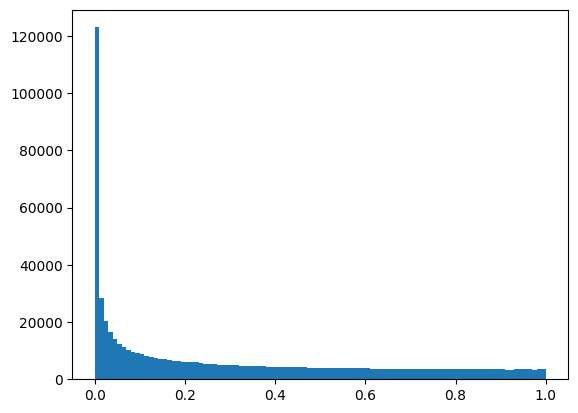

In [11]:
print(gm.values.min())
import matplotlib.pyplot as plt
plt.hist(gm.values.flatten(), bins=100)

In [12]:
gm.to_csv(f'../results_final_Dec22/granger_T_extreme.csv')